# Предсказание цен на автомобили реального рынка

- Денис Рыжов (denis.a.ryzhov@gmail.com)
- Дмитрий Коробов (Pls.mailbox@gmail.com)
- Дмитрий Копылов (kopiloff.dmitry@yandex.ru)

По условиям задачи: 
- нельзя пользоваться нейросетями
- данные должны быть либо взяты из общего доступа, либо скачаны, но не куплены.
- использовать стекинг

Важно:

- качество предсказания;
- скорость предсказания;
- время обучения.

**For your consideration: Performance time of the whole code is about 140 min with my laptop.**

    AMD Ryzen 5 3500U
    RAM 6 GiB @ 2.1 GHz; 4 cores    
    GPU — None

## Краткий отчёт

Работа состояла из 4 этапов:

1. Добыча данных (Data mining)
2. Анализ данных, подготовка и конструирование признаков (EDA and Feature engineering)
3. Исследование, выбор схемы и настройка моделей (Investigation, choice of prediction scheme and model adjustment)
4. Реализация предсказателя для конкретной задачи (предсказание цен ан BMW)

### 1 Добыча данных (Data mining)

Данные были скачаны с сайта *avto.ru*, распарсены и переведы в таблицу *csv*. Изначально извлечено 133274 записей, занимающие 129.1 MB памяти

### 2 Анализ данных, подготовка и конструирование признаков (EDA and Feature engineering)

После удаления дубликатов (8846), обработки пропусков (удалено 17) и удаления аномалий (139 записей) для моделирования доступен датасет с 124271 записями. Аномалиями классифицированы редкие машины (напр. гоночные болиды) и редкие классы (электромобили — 91 ~0.07%, машины с «газовыми» двигателями — 19 ~0.015%), не характерные, по нашему мнению, для российского авторынка.

Всего доступно 62 признака: 4 численных, 2 упорядоченных категориальных и 56 «one-hot» категориальных признака (48 бинарных переменных — в основном описание доп.оборудовния).
Данные приведены к типам `int` и `category`, что позволило уменьшить объём памти занимаемым датасетом до 19 МБ.
Проведено нормирование численных данных при помощи `StandardScaler` и перекодировка «one-hot» переменных в duumy-переменные. Упорядоченные переменные не кодировались.

**Важно:** В качестве целевой переменной использовалась степень логарифма цены (степень равна 2/3). Такой подход позволил улучшить предсказания на несколько процентов MAPE.
Преобразование позволило сделать распределение целевого признака существенно равномернее. Степень логарифма подбиралась из соображений: свести медиану и среднего нового распределения к центру интервала изменения переменных (справа и слева от центра интервала — примерно равное число признаков). 

Определена функция метрики, рассчитывающая MAPE в процентах.
Данные поделены на пять выборок в трёх блоках:
- `train1` (3/9) и `valid1` (1/9) — обучающая и валидационная выборки для базовых моделей
- `train2` (3/9) и `valid2` (1/9) — обучающая и валидационная выборки для мета-модели
-`test` (1/9) - выборка для тестирования всей «сборки»
В обучающих выборках оказалось около 41400 записей, в остальных — по 13800.

### 3 Исследование, выбор схемы и настройка моделей (Investigation, choice of prediction scheme and model adjustment)

Общей схемой построения предсказателя была выбрана двухступенчатая модель стекинга. В качестве как базовых, так и мета моделей рассматривались:
- `DecisionTreeRegressor`
- `RandomForestRegressor`
- `LightGBM`
- `CatBoostRegressor`
- `LinearRegression` (только как мета-модель — блендинг)

`RandomForestRegressor`, `LightGBM`, `CatBoostRegressor` оптимизировались по гиперпараметрам при помощи циклической покоординатной оптимизации:



#### Оптимизация моделей по гиперпараметрам

Пока не достигался заданный максимальный уровень изменения метрики (`tolerance`=0.0001% для MAPE) осуществлялся циклический поиск минимума в пространстве гиперпараметров поиском минимума. Минимум искался на сетке по каждой координате внутри цикла. Каждый цикл осуществлял сужение диапазона поиска центрируясь на достигнутом на данном момент точки минимума. *Сейчас поиск сужен до двух последних циклов, поскольку в полной версии (на широком диапазоне) занимал существенное время.*



#### Выбор моделей

В качестве базовых моделей для стекинга рассматривались 4 упомянутые выше модели. Исследование их по параметрам, а также рассмотрение различных комбинаций в качестве «связки» базовых моделей показало, что в нашем случае будет использование нескольких моделей LightGBM с последующим простым усреднением их прогнозов на мета-этапе.

В конечном варианте собирается набор из 25 моделей LightGBM распределённых в пространстве гиперпараметров вокруг (и включая) лучшей базовой модели.

Исследование признаков при помощи метода `feature_importance` показывает, что наша «информационная достаточность» на этапе базовых моделей составляет 99%, т. е., добавление гипотетических новых признаков, скорее всего, даст только 1% прироста необходимой информации. При тех оговорках, что эта оценка основана на предположениях, что a) мы не пропустили какого-то важного признака, а добавляем признаки меньшей значимости б) распределение признаков по их «информационной значимости» близко к экспогенциальному (что в общем подтверждается из опыта). Стоит заметить, что модель показывала результаты существенно хуже без 46 признаков, описывающих дополнительную комплектацию.

Оказывается усреднение по предсказаниям 25 моделей способно улучшить конечное предсказание, поэтому все обученные модели переводятся на следующий этап, где их предсказания усредняются (бэггинг).
Ни модель линейной регрессии, ни любая из остальных 4 моделей, применённых в качестве мета модели не смогли улучшить результаты бэггинга.

Однако стоит заметить, что анализ «информационной важности» признаков (feature importance) для модели LightGBM показал, что предсказаний всего 25 моделей ей недостаточно для прогноза, а нужно120. Возможно получив столько признаков модель справится с большим разбросом предсказаний.

Однако a) такое предположение гадательно и главное b) требует больших временных рескрсов даже для такой «дёгкой» и быстрой модели как LightGBM.

Как показали исследования, очень важны данные. Самим данным присуща довольна большая дисперсия, и по видимому, именно поэтому простой бэггинг (усреднение) справляется так хорошо — ему свойственно хорошо уменьшать variance предсказаний.

### 4. Реализация предсказателя для конкретной задачи - предсказание цен ан BMW (Estimator realization for BMW price prediction)

Поскольку для предсказания данных выдан набор данных состоящий только из автомобилей BMW, то при реализации предсказателя из обучающего набора отобраны только BMW, ибо нет смысла для предсказания цен на BMW обучать модель на Ладах-Грантах и т.п. Данные обучающей и предоставленной внешней выборки приведены в сооотвестствии друг с другом, созданная модель обучена на обучающей выборке, содержащей только машины BMW, предсказана цена для внешних данных, "предоставленных заказчиком".

### Итог

На основе 25 базовых моделей LightGBM строится усреднённое мета-предсказание (техника бэггинг). Параметры модели выбираются близкими в пространстве гиперпараметров к оптимальной базовой модели. Достигнутая MAPE=13.


### UPD (BMW)

Поскольку в выданном наборе были только модели BMW, модели выбранные на предыдущих этапах были переобучены и оказалось, что:
- бэггинг не улучшает предсказания, в отличие от общего случая, поэтому
- предсказание строится просто лучшей моделью и при этом
- само MAPE уменьшается до уровня $\simeq 11.2$%.


### Мораль

Если бы не застряли так глубоко в общем случае, а просто аккуратно прочли ТЗ и сразу бы, а не в последний день поняли, что предсказывать надо только BMW, наверняка столь же тщательно проанализировав данные только для BMW мы бы заметно улучшили показатели.

**Ergo:**

- **ТЗ надо читать внимательно**
- **читать надо всем**
- **а потом всем вместе и вслух**
- **и минимум дважды в неделю перечитывать**

        `Amen`

## Структура проекта




    1. Подготовка
        1.1 Загрузка модулей, определение констант и т.п.
        1.2 Загрузка данных
    2 Общая информация
        2.1 Дубликаты
        2.2 Пропуски
    3 Исследование признаков 
        3.1 Анализ численных переменных обучающей выборки
            3.1.0 Целевой признак ('price')
            3.1.1 Численные признаки
        3.2 Анализ категориальных признаков  обучающей выборки
            3.2.1 Упорядоченные категориальные признаки (Ordinal features)
            3.2.2 Категориальные 'one-hot' признаки
    4 Преобразование данных
        4.1 Преобразование типа данных
        4.2 Преобразование *One-Hot* переменных
        4.3 Преобразование *Ordinal* переменных
        4.4 Масштабирование численных переменных
    5 Prelaunch
        5.0 Target transformation
        5.1 Metrics function (MAPE)
        5.2 Features and target. Samples.
        5.3 Model optimizer
    6 Optimization of base models
        6.1 LightGBM with default parameters
        6.2 Optimization of base models (*LGBMRegressor*)
        6.3 Collection of nearly best base models for meta-phase
        6.4 About the best base model. Feature importance.
        6.5 Averaged over $\sqrt{N}$ and $N$ best models prediction (*LGBMRegressor*)
    7 STACKING
        7.1 BLENDING
            7.1.1 Average prediction (Bagging)
            7.1.2 Weighted average prediction  (*LinearRegression*)
        7.2 Stacking  with LightGBM
            7.2.1 Optimization of  meta model
            7.2.2 Collect an ensemle of nearly best meta models
            7.2.3. About the best meta model. Feature importance.
        7.3 Averaged over $\sqrt{N}$ and $N$ best meta models prediction (*LGBMRegressor*)    
    8 Приведение в соответствие признаков обучающей и внешней тестовой выборок
		8.1 Приведение в соответствие признаков обучающей и внешней тестовой выборок
		8.2 Извлечение данных из признака 'Комплектация'
		8.3 Приведение в соотвествие типов данных
		8.4 Создание "заточенного" под BMW обучающего набора
    9 Реализация предсказателя для конкретной задачи - предсказание цен на BMW (Estimator realization for BMW price prediction)
		9.1 Создание обучающих и валидационных выборок
		9.2 Оптимизация конкретного предсказателя
		9.3 Создание набора базовых моделей для мета-стадии
		9.4 About the best 'BMW' base model. Feature importance.
		9.5 Мета-фаза. Бэггинг.
		9.6 Итоговое предсказание
    99 Results
    Appendix: Что ещё можно было бы сделать
        VERSIONS

In [1]:
### Versions of libraries

# !pip freeze

# python==3.7.7
# python : datetime, time, warnings

# catboost==0.23
# lightgbm==2.3.0
# matplotlib==3.2.2
# numpy==1.18.5
# pandas==1.0.5
# scipy==1.5.0
# seaborn==0.10.1
# sklearn==0.23.1

# 1. Подготовка

## 1.1 Загрузка модулей, определение констант и т.п.

In [2]:
# Import

import collections
import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import seaborn as sns
import time
import warnings


# from datetime import date


from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import max_error, make_scorer

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, MinMaxScaler

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor


from scipy.stats import gamma, norm


import lightgbm as lgbm
from catboost import CatBoostRegressor

# conda install -c conda-forge catboost
# conda install -c conda-forge lightgbm

In [3]:
### Global constants and settings

FILEPATH = "D:\\Data_Science_0\\Data_Science_=_Skill_Factory\\Real_DS_=_3_auto\\"
RANDOM_STATE = 1607

# warnings.filterwarnings("ignore")

# Plotting

sns.set(style='darkgrid', palette="bright")
sns.set(font_scale = 1.25)
FONT_SIZE = 14

Здесь задаются параметры общие для работы моделей во всё коде.

In [4]:
###  LAUNCH CONTROL CENTER (LCC)

## LGBM parameters (constant)
OBJECTIVE = 'mse'  ## mse, mae, mape
CATEGORICAL_FEATURE_LIST_LGBM = 'auto'
## The point is that lightGBM can handle only features, that are of `category` type, not `object`.


## Parameter for target transformation (power of log)

POWER = 1.5


### fraction of data transferred to models

FRAC = 1
FRAC_MODEL = 1

### Number od data transferred to models
### If exceeds the whole number, model will work with  all data

N_SAMPLE_BASE = 200000
N_SAMPLE_META = 200000


### The distance between vodels in hyperparameter space (for bagging/stacking)
STEP_INT = 1
STEP_LR = 0.001

In [5]:
### AUXILIARY
### Function to print total running time from the start

def running_time(x, x0):
    import pandas
    r_time =  pd.Timestamp(x - x0, unit='s')
    r_hours = r_time.hour
    r_minutes = r_time.minute    
    r_seconds = r_time.second
    r_microseconds = r_time.microsecond
    
    format_string = "[***] This is Houston. The MET is : {}:{}:{}.{}    (H:MM:SS)"
    if r_minutes < 10:
        format_string = "[***] This is Houston. The MET is : {}:0{}:{}.{}    (H:MM:SS)"
        if r_seconds  < 10:
            format_string = "[***] This is Houston. The MET is : {}:0{}:0{}.{}    (H:MM:SS)"
    elif r_seconds  < 10:
        format_string = "[***] This is Houston. The MET is : {}:{}:0{}.{}    (H:MM:SS)"
    print(format_string.format( r_hours, r_minutes, int(r_seconds), int(r_microseconds//1000) ))

In [6]:
### Let's the game begin

total_time_start = time.time()

date_start = datetime.date.today()
time_start = datetime.datetime.now().time()

## 1.2 Загрузка данных

In [7]:
data = pd.read_csv(FILEPATH + "cars_aux.csv")
data

Unnamed: 0   body_type  doors_count        mark       model  \
0                0  COMPACTVAN            4      Nissan      Serena   
1                1     ALLROAD            3  LADA (ВАЗ)  2121 (4x4)   
2                2   HATCHBACK            5  Volkswagen        Polo   
3                3   HATCHBACK            3  LADA (ВАЗ)    1111 Ока   
4                4   HATCHBACK            5  Volkswagen        Golf   
...            ...         ...          ...         ...         ...   
133269      133269     ALLROAD            5         УАЗ     Patriot   
133270      133270     ALLROAD            5   Chevrolet        Niva   
133271      133271     ALLROAD            5  Mitsubishi   Outlander   
133272      133272     ALLROAD            5  Mitsubishi   Outlander   
133273      133273     ALLROAD            3  LADA (ВАЗ)  2121 (4x4)   

       engine_type  displacement  power transmission        gear_type  ...  \
0           DIESEL          1973     91    AUTOMATIC  ALL_WHEEL_DRIVE  ...   
1         GASOLINE          1690     83   MECHANICAL  ALL_WHEEL_DRIVE  ...   
2         GASOLINE          1598     75    AUTOMATIC  FORWARD_CONTROL  ...   
3         GASOLINE           649     29   MECHANICAL  FORWARD_CONTROL  ...   
4         GASOLINE          2324    150   MECHANICAL  FORWARD_CONTROL  ...   
...            ...           ...    ...          ...              ...  ...   
133269    GASOLINE          2693    135   MECHANICAL  ALL_WHEEL_DRIVE  ...   
133270    GASOLINE          1690     80   MECHANICAL  ALL_WHEEL_DRIVE  ...   
133271    GASOLINE          1998    146     VARIATOR  ALL_WHEEL_DRIVE  ...   
133272    GASOLINE          2360    167     VARIATOR  ALL_WHEEL_DRIVE  ...   
133273    GASOLINE          1690     83   MECHANICAL  ALL_WHEEL_DRIVE  ...   

       airbag-1 airbag-2  airbag-4  airbag-6 airbag-curtain  airbag-driver  \
0             0        0         0         0              0              1   
1             0        0         0         0              0              0   
2             0        0         0         0              0              1   
3             0        0         0         0              0              0   
4             0        0         0         0              0              0   
...         ...      ...       ...       ...            ...            ...   
133269        0        0         0         0              0              1   
133270        0        0         0         0              0              1   
133271        0        0         0         0              1              1   
133272        0        0         0         0              0              0   
133273        0        0         0         0              0              0   

        airbag-passenger  airbag-rear-side  airbag-side  knee-airbag  
0                      1                 0            0            0  
1                      0                 0            0            0  
2                      1                 0            1            0  
3                      0                 0            0            0  
4                      0                 0            0            0  
...                  ...               ...          ...          ...  
133269                 1                 0            0            0  
133270                 1                 0            0            0  
133271                 1                 0            1            1  
133272                 0                 0            0            0  
133273                 0                 0            0            0  

[133274 rows x 63 columns]

# 2 Общая информация

In [8]:
data.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 133274 entries, 0 to 133273
Data columns (total 63 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   Unnamed: 0                     133274 non-null  int64  
 1   body_type                      133274 non-null  object 
 2   doors_count                    133274 non-null  int64  
 3   mark                           133274 non-null  object 
 4   model                          133274 non-null  object 
 5   engine_type                    133274 non-null  object 
 6   displacement                   133274 non-null  int64  
 7   power                          133274 non-null  int64  
 8   transmission                   133274 non-null  object 
 9   gear_type                      133274 non-null  object 
 10  steering_wheel                 133274 non-null  object 
 11  color                          133274 non-null  object 
 12  mileage                       

In [9]:
data = data.drop(['Unnamed: 0'], axis=1)
# data = data.drop(['equipment'], axis=1)

In [10]:
data.columns

Index(['body_type', 'doors_count', 'mark', 'model', 'engine_type',
       'displacement', 'power', 'transmission', 'gear_type', 'steering_wheel',
       'color', 'mileage', 'year', 'section', 'owners', 'price', 'abs',
       'activ-suspension', 'air-suspension', 'asr',
       'collision-prevention-assist', 'esp', 'lane-keeping-assist',
       'park-assist-f', 'park-assist-r', 'sport-suspension', 'vsm',
       'climate-control', 'climate-control-1', 'climate-control-2',
       'climate-control-3', 'condition', 'multizone-climate-control',
       'auto-cruise', 'auto-park', 'computer', 'cruise-control',
       'drowsy-driver-alert-system', 'front-camera', 'navigation',
       'night-vision', 'parktronik', 'projection-display', 'rear-camera',
       'adaptive-light', 'automatic-lighting-control',
       'advanced-frontlighting-system', 'decorative-interior-lighting',
       'halogen', 'laser-lights', 'led-lights', 'xenon', 'airbag-1',
       'airbag-2', 'airbag-4', 'airbag-6', 'airbag-cur

## 2.1 Дубликаты

In [11]:
print("There are {} duplicates.".format( data.duplicated().sum() ))

There are 8846 duplicates.


In [12]:
data.drop_duplicates(inplace=True, ignore_index=True)
print("Now we have {} entries.".format( len(data) ))

Now we have 124428 entries.


## 2.2 Пропуски

In [13]:
target_name = 'price'
print("The target has {} missing values.".format( data[target_name].isna().sum() ))

The target has 0 missing values.


In [14]:
missung_values = data.isna().sum().sort_values(ascending=False)
missung_values

owners               12823
price                    0
climate-control-1        0
climate-control          0
vsm                      0
                     ...  
cruise-control           0
computer                 0
auto-park                0
auto-cruise              0
body_type                0
Length: 62, dtype: int64

In [15]:
print("Maximal amount of missing values ({}, i.e. {:.1%}) is in the '{}'.".format( data.isna().sum().max(), 
                                                                                  data.isna().sum().max()/len(data),
                                                                                  data.isna().sum().idxmax() ))

Maximal amount of missing values (12823, i.e. 10.3%) is in the 'owners'.


Пропуски есть только в признаке 'owners'.

In [16]:
data[ data['owners'].isna() ][['year', 'mileage', 'owners']]

year  mileage  owners
3280    2019        0     NaN
3282    2019        0     NaN
3283    2019        0     NaN
3286    2019        0     NaN
3287    2019        0     NaN
...      ...      ...     ...
123366  2018        0     NaN
123373  2018        0     NaN
123378  2018        0     NaN
123383  2018        0     NaN
123388  2018        0     NaN

[12823 rows x 3 columns]

In [17]:
data[ data['owners'].isna() ]['mileage'].value_counts()

0         12806
145000        1
295000        1
66000         1
83000         1
67000         1
200000        1
218000        1
120000        1
163000        1
110158        1
99164         1
74800         1
190000        1
110000        1
160000        1
95000         1
220000        1
Name: mileage, dtype: int64

Подавляющее число пропусков в 'owners' - это машины с нулевым пробегом, т.е., новые. Укажем таким машинам `owners=0`, остальные 13 пропусков удалим.

In [18]:
to_drop_mask = ( data['owners'].isna() ) & (data['mileage'] > 0)
print(to_drop_mask.sum())
# to_drop_mask[ to_drop_mask==True ]

17


In [19]:
data = data.drop(index=to_drop_mask[ to_drop_mask==True ].index).reset_index(drop=True)
data = data.fillna(0)
# data.isna().sum()

# 3 Исследование признаков

Определим какие признаки являются:
- численными (numerical)
- категориальными (categorical) среди которых есть
  - упорядоченные (ordinal)
  - бинарные (binary)
  - прочие неупорядоченные

In [20]:
features_set = set(data.columns) - set('price')

features_numerical = ['displacement', 'power', 'mileage', 'year']
features_numerical_set = set(features_numerical)

features_categorical_set = features_set - features_numerical_set
features_categorical = list(features_categorical_set)

features_ordinal = ['doors_count', 'owners']
features_ordinal_set = set(features_ordinal)

features_one_hot_set = features_categorical_set - features_ordinal_set
features_one_hot = list(features_one_hot_set)


print("There are {} variables.".format(len(features_set)))
print("There are {} numerical variables:".format( len(features_numerical) ), features_numerical)
print("There are {} categorical variables, amongst them:\n    {} ordinal variables:"
      .format( len(features_categorical_set), len(features_ordinal) ), features_ordinal)
print("        and")
print("    {} 'one-hot' variables:\n".
      format( len(features_one_hot) ), features_one_hot)

There are 62 variables.
There are 4 numerical variables: ['displacement', 'power', 'mileage', 'year']
There are 58 categorical variables, amongst them:
    2 ordinal variables: ['doors_count', 'owners']
        and
    56 'one-hot' variables:
 ['computer', 'led-lights', 'projection-display', 'section', 'parktronik', 'gear_type', 'abs', 'price', 'navigation', 'esp', 'condition', 'rear-camera', 'xenon', 'airbag-curtain', 'air-suspension', 'night-vision', 'engine_type', 'airbag-2', 'laser-lights', 'body_type', 'airbag-passenger', 'drowsy-driver-alert-system', 'climate-control-2', 'collision-prevention-assist', 'mark', 'activ-suspension', 'sport-suspension', 'adaptive-light', 'auto-park', 'transmission', 'airbag-4', 'multizone-climate-control', 'park-assist-f', 'airbag-6', 'airbag-driver', 'knee-airbag', 'lane-keeping-assist', 'advanced-frontlighting-system', 'model', 'climate-control-1', 'climate-control', 'vsm', 'airbag-rear-side', 'park-assist-r', 'asr', 'decorative-interior-lighting', 

## 3.1 Анализ численных переменных обучающей выборки

In [21]:
def num_variable_analysis(df, item, target_name, n_bins=100):
    if item != target_name:
        fig, axes = plt.subplots(1, 3, figsize=(15, 10))
    else:
        fig, axes = plt.subplots(1, 2, figsize=(15, 10))
    
    
    # ==== FIG 1 (boxplot)    
    df.boxplot(column=item, ax=axes[0])
    axes[0].set_title(item, fontsize=FONT_SIZE)

    
    # ==== FIG 2 (distplot)
    sns.distplot(df[item], bins=n_bins, kde=True, ax=axes[1], vertical=True)
    axes[1].set_title(item, fontsize=FONT_SIZE)
    plt.xticks(rotation=45)
    # axes.set_xlim((0, 100))
    
    
    # === FIG 3 (scatterplot)
    if item != target_name:
        axes[2] = sns.scatterplot(x=item, y=target_name, data=df)
    
    plt.show()
    
    # === Descriptive statistics
    describer = pd.DataFrame(df[item].describe()).T    
    print("==== {} ====".format(item))
    print(describer, "\n")
    
    
    # Pearson correlation coefficient for feature/target
    if item != target_name:
        corr_coeff = np.array(df[[item, target_name]].corr())[0, 1]
        print("Pearson correlation coefficient between '{}' and '{}' is {:.4f}.".format( item, target_name, corr_coeff ), "\n")
    
    
    # === Missing values
    print("There are {} missing values in '{}'.".format( df[item].isna().sum(), item ), "\n"*2)

### 3.1.0 Целевой признак ('price')


  
Анализировались как распределения собственно цены на автомобиль, так и её логарифма (эта версия сейчас активна, переключение обратно на анализ цены - закомментировать ячейку `### MARK: TARGET TRANSFORMATION`)

In [22]:
data[target_name].min()

15000

In [23]:
### MARK: TARGET TRANSFORMATION

data['price_log10'] = np.log10(data[target_name])
target_name = 'price_log10'

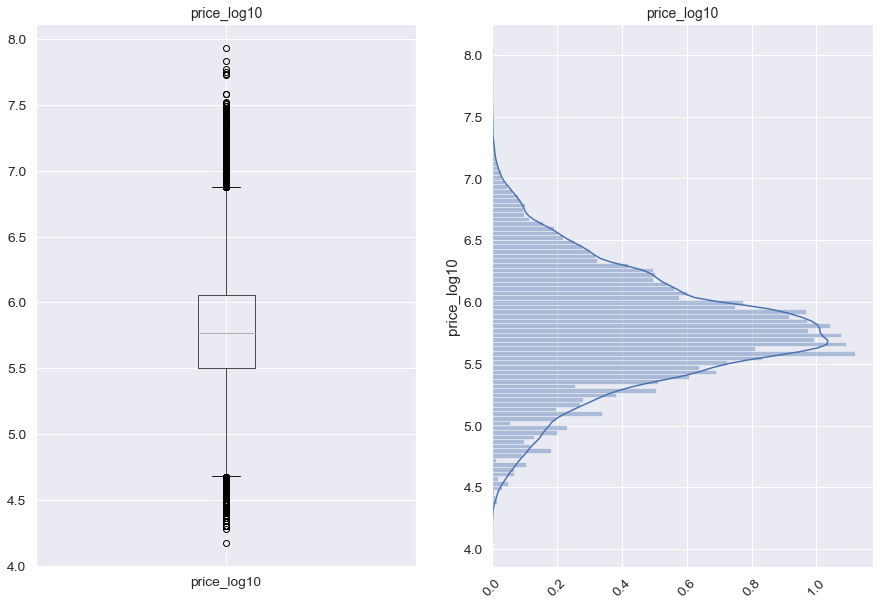

==== price_log10 ====
                count      mean       std       min      25%       50%  \
price_log10  124411.0  5.776436  0.452597  4.176091  5.50515  5.767156   

                  75%       max  
price_log10  6.054613  7.929419   

There are 0 missing values in 'price_log10'. 




In [24]:
num_variable_analysis(data, target_name, target_name)

Рассмотрим отдельно несколько диапазонов цен:

1. "Низкие" цены (меньше 10 млн руб.)

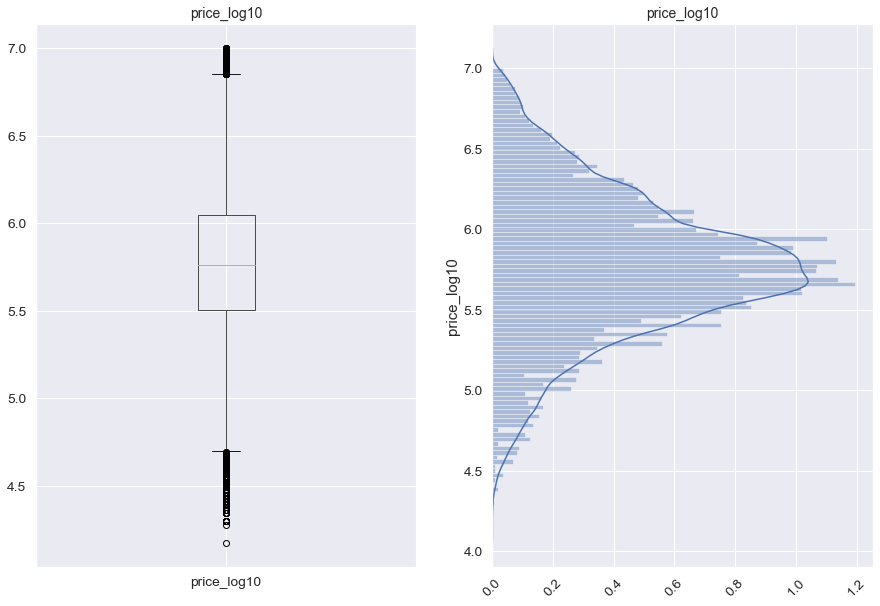

==== price_log10 ====
                count      mean       std       min      25%       50%  \
price_log10  123882.0  5.770604  0.444567  4.176091  5.50515  5.763428   

                  75%       max  
price_log10  6.045323  6.999957   

There are 0 missing values in 'price_log10'. 




In [25]:
if target_name == 'price_log10':
    upper_price_limit = 7
else:
    upper_price_limit = 10*10**6

df = data[ data[target_name] < upper_price_limit ]

num_variable_analysis(df, target_name, target_name)

2. Высокие цены (выше 10 млн. руб.)

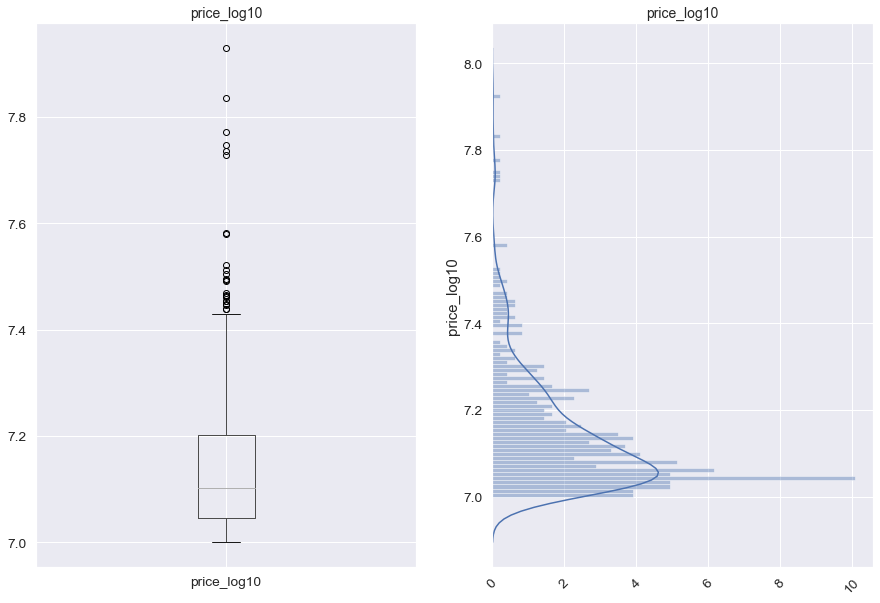

==== price_log10 ====
             count     mean       std       min       25%       50%       75%  \
price_log10  523.0  7.14384  0.136565  7.000182  7.045552  7.103256  7.202337   

                  max  
price_log10  7.929419   

There are 0 missing values in 'price_log10'. 




In [26]:
df = data[ data[target_name] > upper_price_limit ]

num_variable_analysis(df, target_name, target_name)

3. Промежуточный (с перекрытием) диапазон цен: от 5 до 15 млн руб.

In [27]:
np.log10(1.5), np.log10(2)

(0.17609125905568124, 0.3010299956639812)

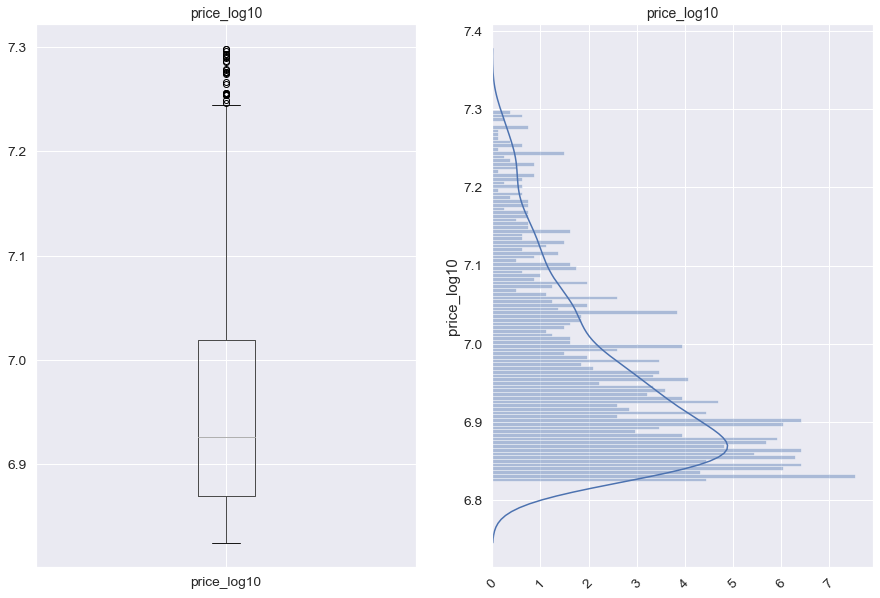

==== price_log10 ====
              count     mean       std      min       25%       50%       75%  \
price_log10  1707.0  6.95565  0.109543  6.82436  6.868832  6.925737  7.019454   

                  max  
price_log10  7.298853   

There are 0 missing values in 'price_log10'. 




In [28]:
if target_name == 'price_log10':
    df = data[ (upper_price_limit-np.log10(1.5) < data[target_name]) & (data[target_name] < upper_price_limit+np.log10(2)) ]
else:
    df = data[ (0.5*upper_price_limit < data[target_name]) & (data[target_name] < 1.5*upper_price_limit) ]

num_variable_analysis(df, target_name, target_name)

На этоп этапе никаких аномалий не выявлено.

### 3.1.1 Численные признаки

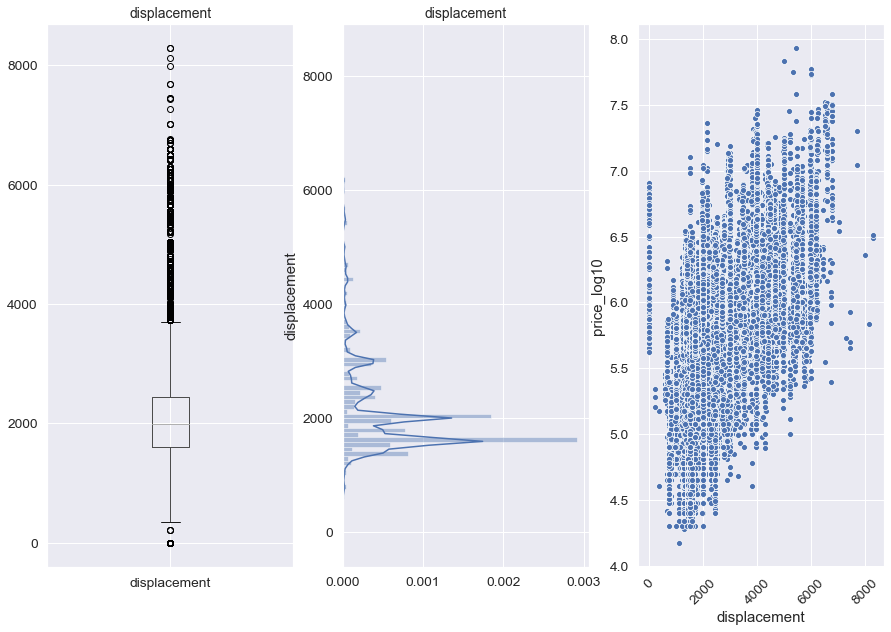

==== displacement ====
                 count         mean         std  min     25%     50%     75%  \
displacement  124411.0  2151.674185  873.758248  0.0  1596.0  1984.0  2445.0   

                 max  
displacement  8285.0   

Pearson correlation coefficient between 'displacement' and 'price_log10' is 0.4397. 

There are 0 missing values in 'displacement'. 




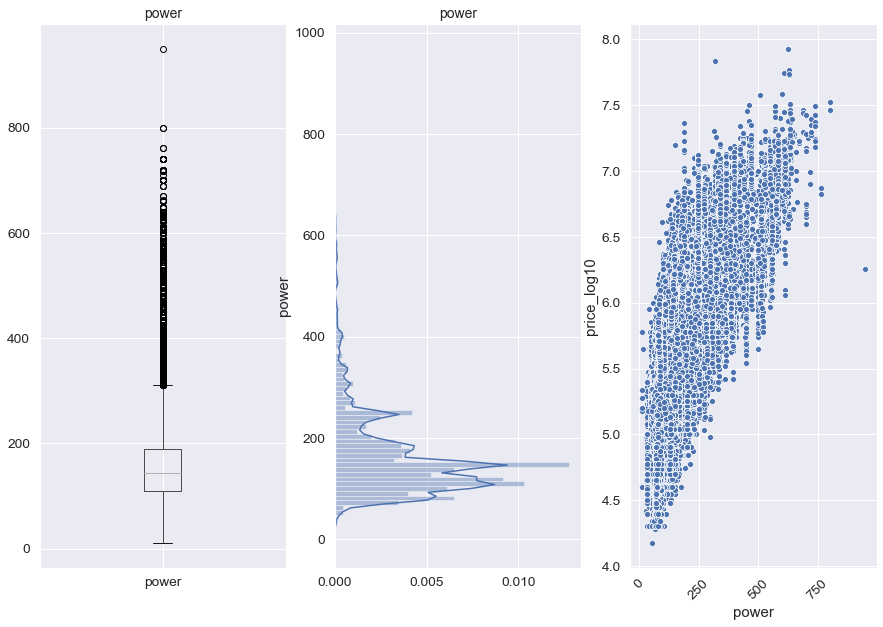

==== power ====
          count        mean        std   min    25%    50%    75%    max
power  124411.0  163.082332  82.868188  11.0  109.0  144.0  190.0  950.0 

Pearson correlation coefficient between 'power' and 'price_log10' is 0.6318. 

There are 0 missing values in 'power'. 




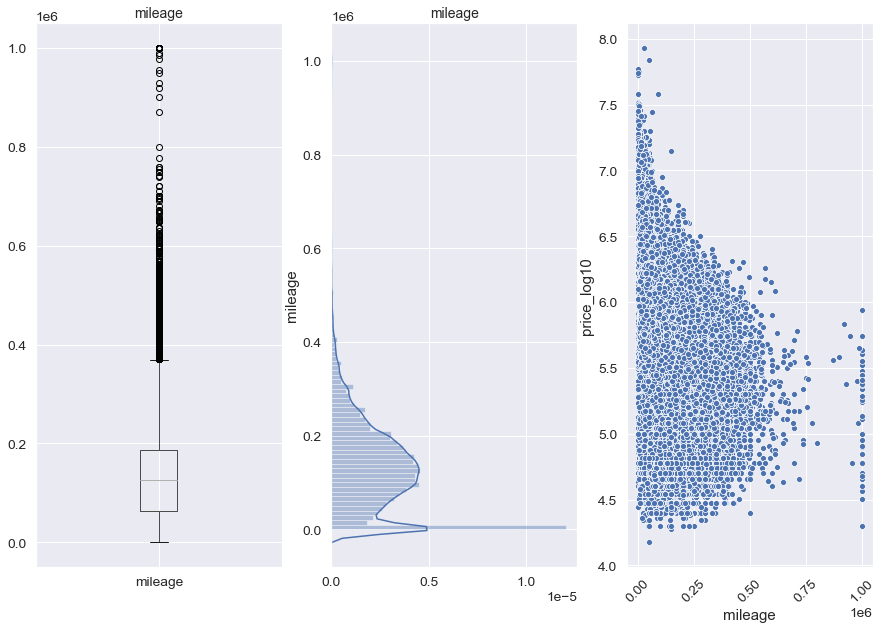

==== mileage ====
            count           mean          std  min      25%       50%  \
mileage  124411.0  132174.555682  95572.06816  0.0  63426.5  125000.0   

              75%        max  
mileage  186043.5  1000000.0   

Pearson correlation coefficient between 'mileage' and 'price_log10' is -0.5256. 

There are 0 missing values in 'mileage'. 




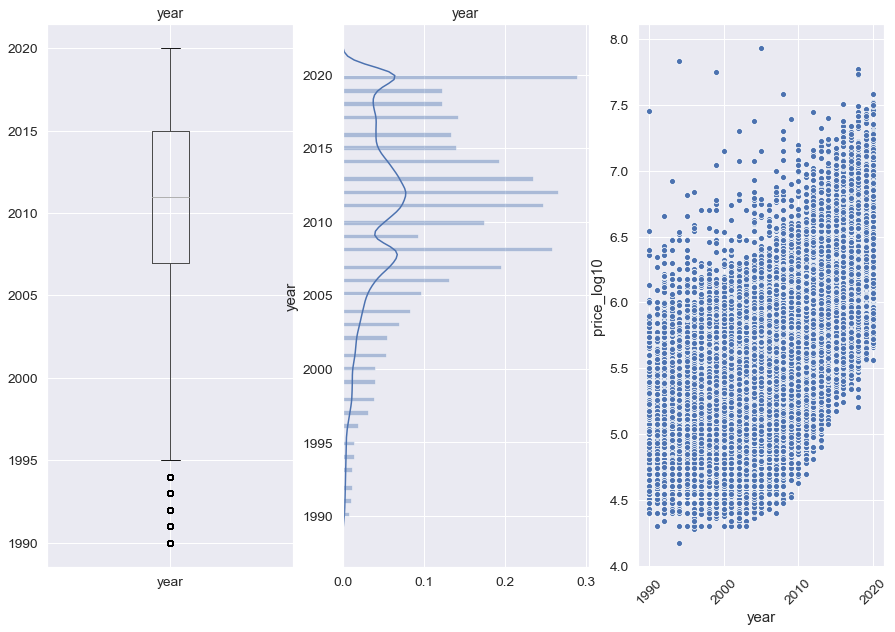

==== year ====
         count         mean       std     min     25%     50%     75%     max
year  124411.0  2010.744388  6.285782  1990.0  2007.0  2011.0  2015.0  2020.0 

Pearson correlation coefficient between 'year' and 'price_log10' is 0.7145. 

There are 0 missing values in 'year'. 




In [29]:
for item in features_numerical:
    num_variable_analysis(data, item, target_name)

**Выделяются**:
1. 6 машин с ценой выше 40 млн руб.
2. несколько машин с объёмом двигателя свыше 7 л
3. автомобиль с мощностью двигателя 950 л.с.
4. минимальная мощность двигателя 11 л.с.
5. автомобили с нулевым объёмом двигателя
6. раритет 1990 года ценой за 2 млн руб

In [30]:
if target_name != 'price_log10':
    limit = 40*10**6
else:
    limit = np.log10(40*10**6)
         
data[ data[target_name] > limit]

body_type  doors_count           mark            model engine_type  \
30726      SEDAN            4  Mercedes-Benz          S-Класс    GASOLINE   
54032      COUPE            2  Mercedes-Benz      SLR McLaren    GASOLINE   
86989      COUPE            2   Aston Martin       V8 Vantage    GASOLINE   
122346     SEDAN            4  Mercedes-Benz  Maybach S-Класс    GASOLINE   
122350     SEDAN            4  Mercedes-Benz  Maybach S-Класс    GASOLINE   
122356     SEDAN            4  Mercedes-Benz  Maybach S-Класс    GASOLINE   

        displacement  power transmission   gear_type steering_wheel  ...  \
30726           4973    320    AUTOMATIC  REAR_DRIVE           LEFT  ...   
54032           5439    626    AUTOMATIC  REAR_DRIVE           LEFT  ...   
86989           5341    608   MECHANICAL  REAR_DRIVE           LEFT  ...   
122346          5980    630    AUTOMATIC  REAR_DRIVE           LEFT  ...   
122350          5980    630    AUTOMATIC  REAR_DRIVE           LEFT  ...   
122356          5980    630    AUTOMATIC  REAR_DRIVE           LEFT  ...   

       airbag-2  airbag-4  airbag-6 airbag-curtain  airbag-driver  \
30726         0         0         0              0              0   
54032         0         0         0              0              0   
86989         0         0         0              0              0   
122346        0         0         0              1              1   
122350        0         0         0              1              1   
122356        0         0         0              1              1   

        airbag-passenger  airbag-rear-side  airbag-side  knee-airbag  \
30726                  0                 0            0            0   
54032                  0                 0            0            0   
86989                  0                 0            0            0   
122346                 1                 1            1            0   
122350                 1                 1            1            0   
122356                 1                 1            1            0   

        price_log10  
30726      7.835691  
54032      7.929419  
86989      7.748188  
122346     7.728138  
122350     7.771496  
122356     7.736878  

[6 rows x 63 columns]

In [31]:
print(len(data[ data['displacement'] >= 7000 ]))
data[ data['displacement'] >= 7000 ]

13


body_type  doors_count       mark      model engine_type  \
251       ALLROAD            5  Chevrolet   Suburban    GASOLINE   
373       ALLROAD            5  Chevrolet   Suburban    GASOLINE   
18638   LIMOUSINE            4        ЗИЛ       4104    GASOLINE   
32035     ALLROAD            5  Chevrolet   Suburban    GASOLINE   
35709       COUPE            2  Chevrolet   Corvette    GASOLINE   
54290    ROADSTER            2      Dodge      Viper    GASOLINE   
54418      PICKUP            4  Chevrolet  Avalanche    GASOLINE   
87020   LIMOUSINE            4        ЗИЛ       4104    GASOLINE   
88366     MINIVAN            4       Ford  Econoline      DIESEL   
102671      COUPE            2  Chevrolet   Corvette    GASOLINE   
103622   ROADSTER            2      Dodge      Viper    GASOLINE   
105181      COUPE            2  Chevrolet   Corvette    GASOLINE   
117267      COUPE            2      Dodge      Viper    GASOLINE   

        displacement  power transmission        gear_type steering_wheel  ...  \
251             7446    290    AUTOMATIC  ALL_WHEEL_DRIVE           LEFT  ...   
373             7446    290    AUTOMATIC  ALL_WHEEL_DRIVE           LEFT  ...   
18638           7680    315    AUTOMATIC       REAR_DRIVE           LEFT  ...   
32035           7443    233    AUTOMATIC  ALL_WHEEL_DRIVE           LEFT  ...   
35709           7011    513   MECHANICAL       REAR_DRIVE           LEFT  ...   
54290           8285    507   MECHANICAL       REAR_DRIVE           LEFT  ...   
54418           8128    325    AUTOMATIC  ALL_WHEEL_DRIVE           LEFT  ...   
87020           7680    315    AUTOMATIC       REAR_DRIVE           LEFT  ...   
88366           7270    215    AUTOMATIC       REAR_DRIVE           LEFT  ...   
102671          7011    513   MECHANICAL       REAR_DRIVE           LEFT  ...   
103622          8285    507   MECHANICAL       REAR_DRIVE           LEFT  ...   
105181          7011    513   MECHANICAL       REAR_DRIVE           LEFT  ...   
117267          7990    456   MECHANICAL       REAR_DRIVE           LEFT  ...   

       airbag-2  airbag-4  airbag-6 airbag-curtain  airbag-driver  \
251           0         0         0              0              0   
373           0         0         0              0              1   
18638         0         0         0              0              0   
32035         0         0         0              0              0   
35709         0         0         0              0              0   
54290         0         0         0              0              1   
54418         0         0         0              0              1   
87020         0         0         0              0              0   
88366         0         0         0              0              0   
102671        0         0         0              0              0   
103622        0         0         0              0              0   
105181        0         0         0              0              0   
117267        0         0         0              0              0   

        airbag-passenger  airbag-rear-side  airbag-side  knee-airbag  \
251                    0                 0            0            0   
373                    0                 0            0            0   
18638                  0                 0            0            0   
32035                  0                 0            0            0   
35709                  0                 0            0            0   
54290                  1                 0            0            0   
54418                  1                 1            1            0   
87020                  0                 0            0            0   
88366                  0                 0            0            0   
102671                 0                 0            0            0   
103622                 0                 0            0            0   
105181                 0                 0            0            0   
117267           

In [32]:
data[ data['power'] >= 900 ]

body_type  doors_count            mark                model  \
40871  SPEEDSTER            0  Гоночный болид  Шоу-кар «Формула-1»   

      engine_type  displacement  power transmission   gear_type  \
40871    GASOLINE          3000    950        ROBOT  REAR_DRIVE   

      steering_wheel  ... airbag-2  airbag-4  airbag-6 airbag-curtain  \
40871           LEFT  ...        0         0         0              0   

       airbag-driver  airbag-passenger  airbag-rear-side  airbag-side  \
40871              0                 0                 0            0   

       knee-airbag  price_log10  
40871            0     6.255273  

[1 rows x 63 columns]

In [33]:
data[ data['power']<30 ]

body_type  doors_count        mark     model engine_type  \
3       HATCHBACK            3  LADA (ВАЗ)  1111 Ока    GASOLINE   
1743    HATCHBACK            3  LADA (ВАЗ)  1111 Ока    GASOLINE   
8018        COUPE            2     Renault     Twizy     ELECTRO   
30826   HATCHBACK            3  LADA (ВАЗ)  1111 Ока    GASOLINE   
31847   HATCHBACK            3  LADA (ВАЗ)  1111 Ока    GASOLINE   
31902       COUPE            2         СМЗ      С-3Д    GASOLINE   
32182       COUPE            2         СМЗ      С-3Д    GASOLINE   
79284       COUPE            2     Renault     Twizy     ELECTRO   
89022   HATCHBACK            3  LADA (ВАЗ)  1111 Ока    GASOLINE   
122344  HATCHBACK            4       Bajaj      Qute    GASOLINE   
122432  HATCHBACK            4       Bajaj      Qute    GASOLINE   
122576  HATCHBACK            4       Bajaj      Qute    GASOLINE   

        displacement  power transmission        gear_type steering_wheel  ...  \
3                649     29   MECHANICAL  FORWARD_CONTROL           LEFT  ...   
1743             649     29   MECHANICAL  FORWARD_CONTROL           LEFT  ...   
8018               0     17    AUTOMATIC       REAR_DRIVE           LEFT  ...   
30826            649     29   MECHANICAL  FORWARD_CONTROL           LEFT  ...   
31847            649     29   MECHANICAL  FORWARD_CONTROL           LEFT  ...   
31902            346     12   MECHANICAL       REAR_DRIVE           LEFT  ...   
32182            346     12   MECHANICAL       REAR_DRIVE           LEFT  ...   
79284              0     11    AUTOMATIC       REAR_DRIVE           LEFT  ...   
89022            649     29   MECHANICAL  FORWARD_CONTROL           LEFT  ...   
122344           217     13        ROBOT       REAR_DRIVE           LEFT  ...   
122432           217     13        ROBOT       REAR_DRIVE           LEFT  ...   
122576           217     13        ROBOT       REAR_DRIVE           LEFT  ...   

       airbag-2  airbag-4  airbag-6 airbag-curtain  airbag-driver  \
3             0         0         0              0              0   
1743          0         0         0              0              0   
8018          0         0         0              0              0   
30826         0         0         0              0              0   
31847         0         0         0              0              0   
31902         0         0         0              0              0   
32182         0         0         0              0              0   
79284         0         0         0              0              1   
89022         0         0         0              0              0   
122344        0         0         0              0              0   
122432        0         0         0              0              0   
122576        0         0         0              0              0   

        airbag-passenger  airbag-rear-side  airbag-side  knee-airbag  \
3                      0                 0            0            0   
1743                   0                 0            0            0   
8018                   0                 0            0            0   
30826                  0                 0            0            0   
31847                  0                 0            0            0   
31902                  0                 0            0            0   
32182                  0                 0            0            0   
79284                  0                 0            0            0   
89022                  0                 0            0            0   
122344                 0                 0            0            0   
122432                 0                 0            0            0   
122576                 0                 0            0            0   

        price_log10  
3          4.414973  
1743       4.977724  
8018       5.652246  
30826      4.698970  
31847      5.290035  
31902      4.602060  
32182      5.176091  
79284      5.777427  
89022      4.653213  
122344     5.2

In [34]:
limit_t = 20*10**6
if target_name == 'price_log10':
    limit_t = np.log10(20*10**6)
    
    
data[ (data['year']==1990) & (data[target_name] > limit_t)]

body_type  doors_count         mark  model engine_type  displacement  \
30735    PICKUP            4  Lamborghini  LM002    GASOLINE          5167   

       power transmission        gear_type steering_wheel  ... airbag-2  \
30735    455   MECHANICAL  ALL_WHEEL_DRIVE           LEFT  ...        0   

       airbag-4  airbag-6 airbag-curtain  airbag-driver  airbag-passenger  \
30735         0         0              0              0                 0   

       airbag-rear-side  airbag-side  knee-airbag  price_log10  
30735                 0            0            0     7.454845  

[1 rows x 63 columns]

In [35]:
print(len(data[ data['displacement']==0 ]))
data[ data['displacement']==0 ]['engine_type']

91


3295      ELECTRO
5587      ELECTRO
5625      ELECTRO
5636      ELECTRO
5761      ELECTRO
           ...   
101455    ELECTRO
115383    ELECTRO
115685    ELECTRO
123096    ELECTRO
123101    ELECTRO
Name: engine_type, Length: 91, dtype: object

In [36]:
data[ data['displacement']==0 ]['engine_type'].value_counts()

ELECTRO    91
Name: engine_type, dtype: int64

1. 6 машин с ценой выше 40 млн руб.- несколько машин с объёмом двигателя свыше 7 л
 - люксовые (Maybach S-Класс и Mercedes-Benz S-Класс (W220)) и спортивные машины (Mercedes-Benz SLR McLaren, Aston Martin Vantage). С Aston Martin Vantage есть загадка: модель выпускалась с 2005, а в базе стоит 1999 год...
2. 13 машин с объёмом двигателя свыше 7 л
 - 3 "пассажирских грузовика" (SUV) Chevrolet Suburban 9-го поколения и его производная Chevrolet Avalanche
 - 2 "членовоза" ЗИЛ-41047
 - "спортсмены" Dodge Viper и Chevrolet Corvette (по 3 штуки)
 - фургон Ford Econoline
3. автомобиль с мощностью двигателя 950 л.с.
 - Шоу-кар «Формула-1»
4. аавтомобили с мощностью двигателя меньше 30 л.с.:
 - СМЗ С-3Д - инвалидка" (2)
 - Bajaj Qute - индийский квадрицикл (3)
 - Renault Twizy - еропейский электро-квадрицикл (2)
 - LADA (ВАЗ) - 1111 Ока (5) 
5. автомобили с нулевым объёмом двигателя
 - электромобили
6. раритет 1990 года ценой за 2 млн
 - Это внедорожник Lamborghini LM002 ! 
 
Далеко не рядовые 120 машин. Все они имеют право на существование, но для общего рынка некоторые будут скорее аномалиями и способны подпортить предсказатель.

Сейчас удаляем все, кроме "Оки" и электромобилей.

In [37]:
if target_name == 'price_log10':
    data = data[ data[target_name] < np.log10(40*10**6)]
else:
    data = data[ data[target_name] < 40*10**6]

data = data[ data['displacement'] <= 7000 ]
data = data[ data['power'] < 900 ]
data = data[ data['power'] > 20 ]
# data = data[ data['engine_type'] != 'ELECTRO' ]

if target_name == 'price_log10':
    index_to_drop = data[ (data['year']==1990) & (data[target_name] > np.log10(20*10**6))].index
else:
    index_to_drop = data[ (data['year']==1990) & (data[target_name] > 20*10**6)].index
    
data = data.drop(index=index_to_drop).reset_index(drop=True)
# data

После "первичной очистки" снова глянем на численные признаки:

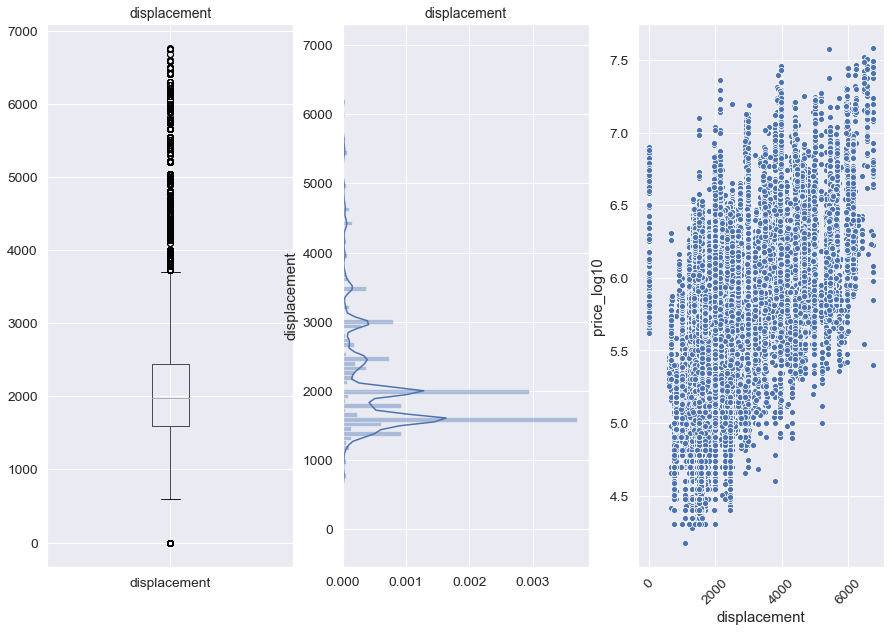

==== displacement ====
                 count         mean         std  min     25%     50%     75%  \
displacement  124383.0  2151.017808  871.567139  0.0  1596.0  1984.0  2445.0   

                 max  
displacement  6761.0   

Pearson correlation coefficient between 'displacement' and 'price_log10' is 0.4393. 

There are 0 missing values in 'displacement'. 




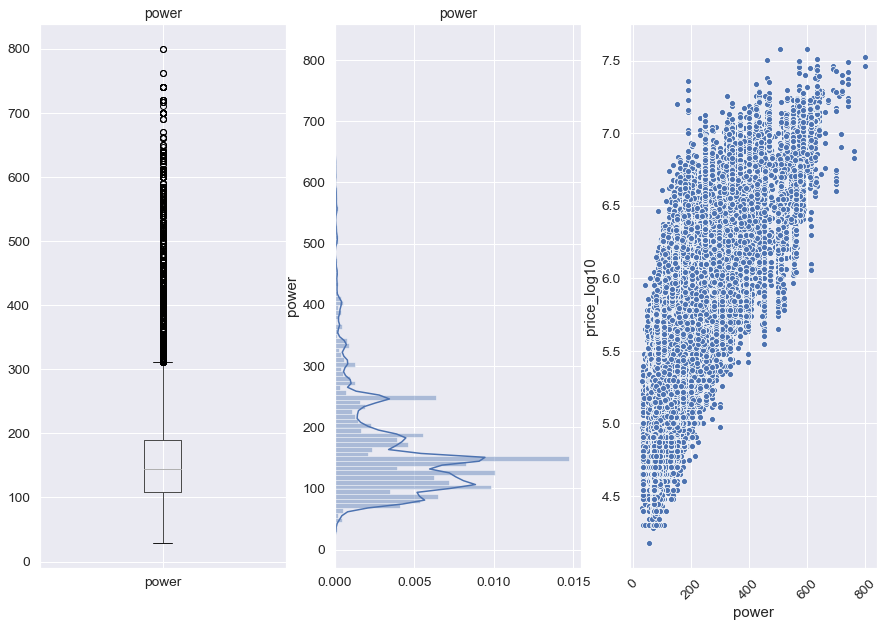

==== power ====
          count        mean        std   min    25%    50%    75%    max
power  124383.0  163.039193  82.743772  29.0  109.0  144.0  190.0  800.0 

Pearson correlation coefficient between 'power' and 'price_log10' is 0.6315. 

There are 0 missing values in 'power'. 




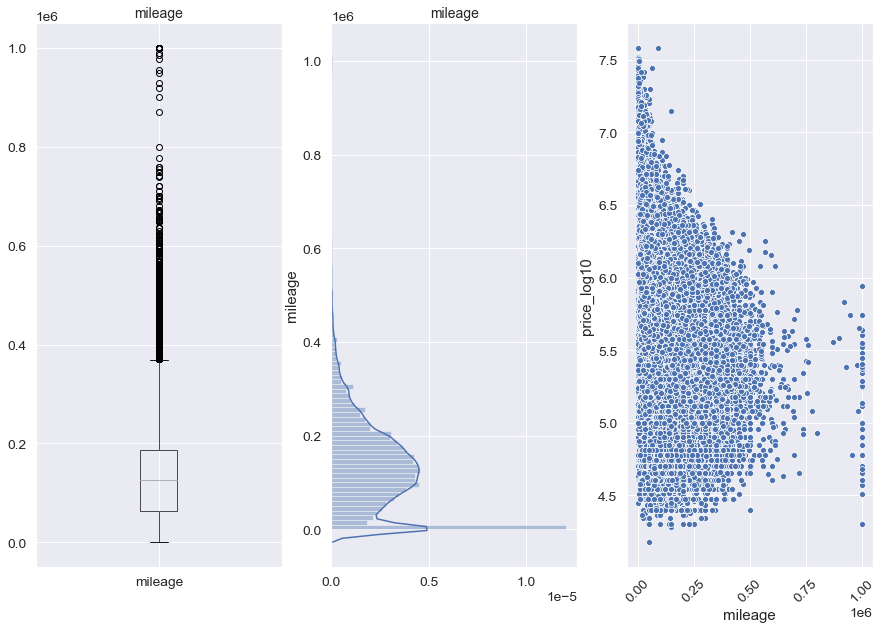

==== mileage ====
            count           mean           std  min      25%       50%  \
mileage  124383.0  132190.782736  95562.212821  0.0  63500.0  125000.0   

              75%        max  
mileage  186097.5  1000000.0   

Pearson correlation coefficient between 'mileage' and 'price_log10' is -0.5257. 

There are 0 missing values in 'mileage'. 




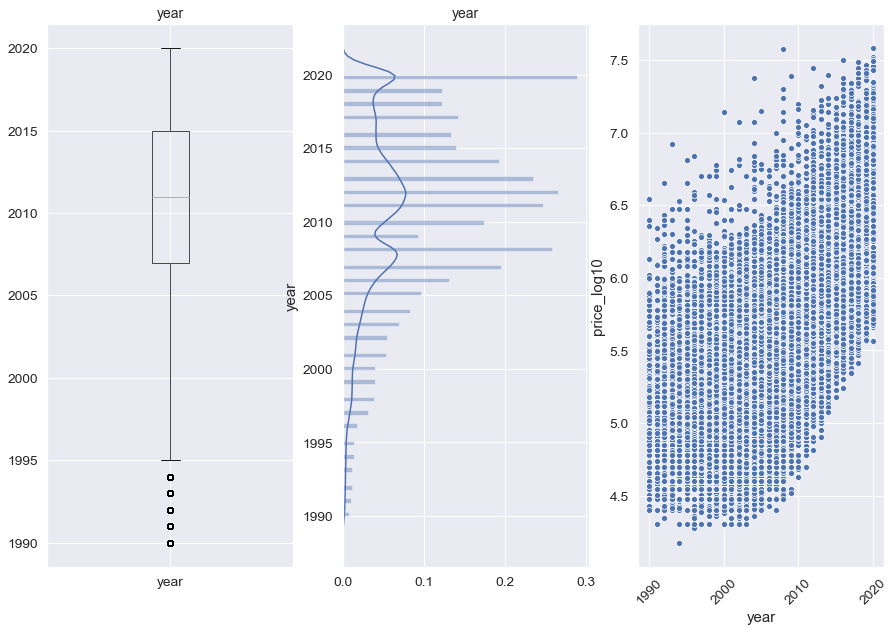

==== year ====
         count         mean       std     min     25%     50%     75%     max
year  124383.0  2010.745657  6.284494  1990.0  2007.0  2011.0  2015.0  2020.0 

Pearson correlation coefficient between 'year' and 'price_log10' is 0.7155. 

There are 0 missing values in 'year'. 




In [38]:
for item in features_numerical:
    num_variable_analysis(data, item, target_name)

Вопиющих аномалий не видно.

## 3.2 Анализ категориальных признаков  обучающей выборки

Сколько в каждом категориальном признаке категорий:

In [39]:
categorical_unique_dict = dict()
for item in features_categorical:
    categorical_unique_dict[item] = data[item].nunique()

categorical_unique = pd.Series(categorical_unique_dict, index=categorical_unique_dict.keys()).sort_values(ascending=False)
categorical_unique

price                            10666
model                             1400
mark                               121
color                               16
body_type                           16
doors_count                          5
engine_type                          5
owners                               4
transmission                         4
gear_type                            3
airbag-passenger                     2
airbag-2                             2
laser-lights                         2
collision-prevention-assist          2
drowsy-driver-alert-system           2
climate-control-2                    2
activ-suspension                     2
night-vision                         2
halogen                              2
air-suspension                       2
sport-suspension                     2
xenon                                2
rear-camera                          2
condition                            2
esp                                  2
navigation               

In [40]:
print("We have {} binary variables.".format(categorical_unique[ categorical_unique == 2 ].count()))

We have 48 binary variables.


### 3.2.1 Упорядоченные категориальные признаки (Ordinal features)

In [41]:
def ordinal_variable_analysis(df, item, target_name):
    fig, axes = plt.subplots(1, 3, figsize=(15, 10))
    
    # ==== FIG 1 (barplot)
    bar_data = df.groupby(item)[item].count()
    br_plot = sns.barplot(x=bar_data.index, y=bar_data, ax = axes[0], palette="Blues_d")
    br_plot.set_xticklabels(bar_data.index, rotation=45)
    axes[0].set_title(item, fontsize=FONT_SIZE)
    
    
    # ==== FIG 2 (boxplots for classes)
    bx_plot = sns.boxplot(x=item, y=target_name, data=df, ax=axes[1])    
    bx_plot.set_xticklabels(bar_data.index, rotation=45)
    plt.xticks(rotation=45)
    axes[1].set_title(item, fontsize=FONT_SIZE)

        
    # ==== FIG 3 (kdeplots for classes)
    values = df[item].value_counts()
    
    for value in values.index:
        sns.kdeplot(df[ df[item] == value ][target_name], vertical=True, ax=axes[2], label=value)    
    axes[2].set_title(item, fontsize=FONT_SIZE)
    axes[2].legend(fontsize=FONT_SIZE)
    
    plt.show()
    
    # === Descriptive statistics
    
    print("==== {} ====\n".format(item))
    if item != target_name:
        print("Pearson correlation coefficient between '{}' and '{}' is {:.4f}."
              .format( item, 
                      target_name, 
                      np.array(df[[item, target_name]].corr())[0, 1] ), "\n")
    
    print(bar_data, "\n")
    
    print("There are {} missing values in '{}'.".format( df[item].isna().sum(), item ), '\n'*2)

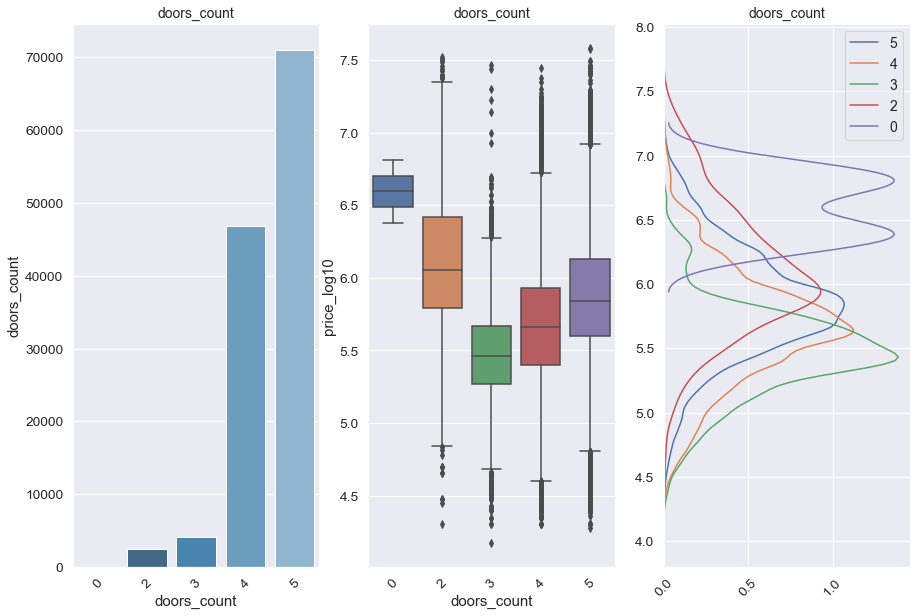

==== doors_count ====

Pearson correlation coefficient between 'doors_count' and 'price_log10' is 0.1405. 

doors_count
0        2
2     2464
3     4165
4    46752
5    71000
Name: doors_count, dtype: int64 

There are 0 missing values in 'doors_count'. 




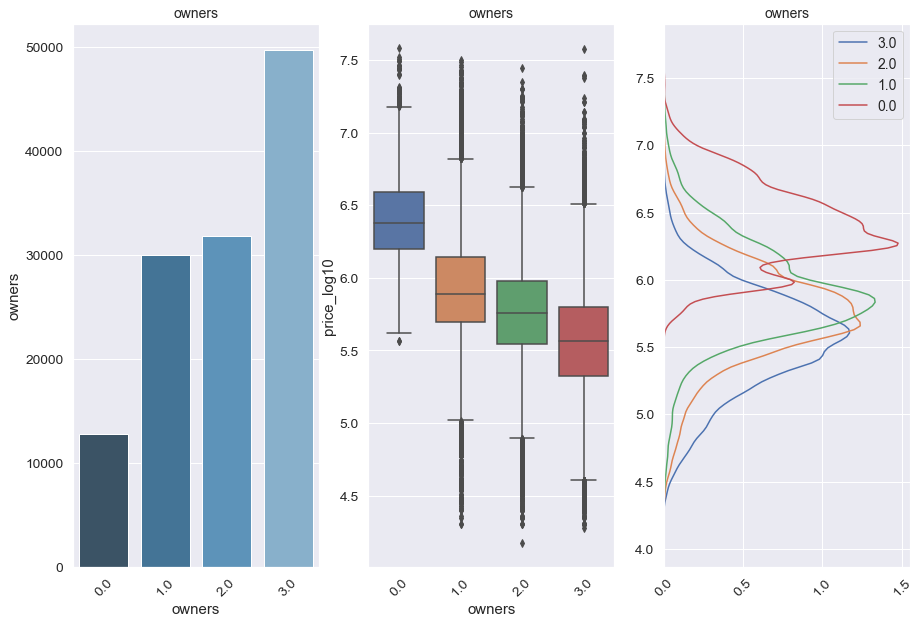

==== owners ====

Pearson correlation coefficient between 'owners' and 'price_log10' is -0.5453. 

owners
0.0    12803
1.0    29986
2.0    31835
3.0    49759
Name: owners, dtype: int64 

There are 0 missing values in 'owners'. 




In [42]:
for item in features_ordinal:
    ordinal_variable_analysis(data, item, target_name)

Из аномалий - 0-дверная машина (2 штуки) и пятидверки с ценой свыше 35 млн руб.

In [43]:
data[ data['doors_count']==0 ]

body_type  doors_count            mark             model engine_type  \
35788   ROADSTER            0           Ariel              Atom    GASOLINE   
87012  SPEEDSTER            0  Гоночный болид  Dallara F399/300    GASOLINE   

       displacement  power transmission   gear_type steering_wheel  ...  \
35788          1998    300   MECHANICAL  REAR_DRIVE           LEFT  ...   
87012          2000    215   MECHANICAL  REAR_DRIVE           LEFT  ...   

      airbag-2  airbag-4  airbag-6 airbag-curtain  airbag-driver  \
35788        0         0         0              0              0   
87012        0         0         0              0              0   

       airbag-passenger  airbag-rear-side  airbag-side  knee-airbag  \
35788                 0                 0            0            0   
87012                 0                 0            0            0   

       price_log10  
35788     6.812913  
87012     6.381669  

[2 rows x 63 columns]

In [44]:
limit_t = 35*10**6

if target_name == 'price_log10':
    limit_t = np.log10(limit_t)

# print(limit_t)
data[ (data['doors_count']==5) & (data[target_name]>limit_t) ]

body_type  doors_count           mark        model engine_type  \
73136    ALLROAD            5  Mercedes-Benz  G-Класс AMG    GASOLINE   
120147   ALLROAD            5    Rolls-Royce     Cullinan    GASOLINE   

        displacement  power transmission        gear_type steering_wheel  ...  \
73136           5439    507    AUTOMATIC  ALL_WHEEL_DRIVE           LEFT  ...   
120147          6749    600    AUTOMATIC  ALL_WHEEL_DRIVE           LEFT  ...   

       airbag-2  airbag-4  airbag-6 airbag-curtain  airbag-driver  \
73136         0         0         0              0              0   
120147        0         0         0              1              1   

        airbag-passenger  airbag-rear-side  airbag-side  knee-airbag  \
73136                  0                 0            0            0   
120147                 1                 1            1            0   

        price_log10  
73136      7.579784  
120147     7.582063  

[2 rows x 63 columns]

Машинами без дверей оказались гоночные болиды Dallara F399/300 и Ariel Atom. Удаляем как редкую редкость.

Машинами с ценой за 35 млн руб. оказался люксовый внедорожник Rolls-Royce Cullinan и Geländewagen. Тоже удаляем как редких птиц для российского (даже московского) авторынка.

In [45]:
data = data[ data['doors_count']>0 ]

limit_t = 35*10**6

if target_name == 'price_log10':
    limit_t = np.log10(limit_t)

data = data[ data[target_name]<limit_t ].reset_index(drop=True)

После "первичной очистки" снова глянем на упорядоченные категориальные признаки:

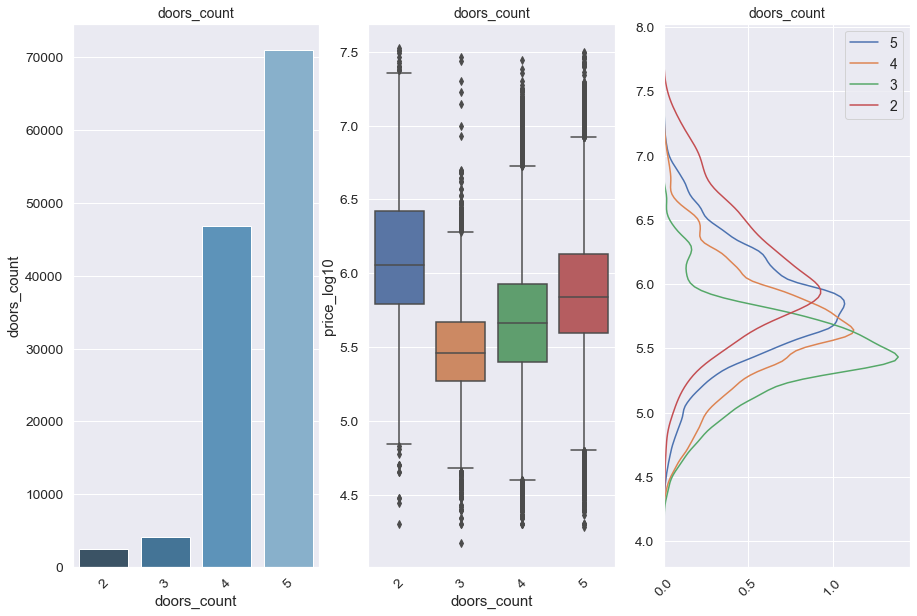

==== doors_count ====

Pearson correlation coefficient between 'doors_count' and 'price_log10' is 0.1407. 

doors_count
2     2464
3     4165
4    46752
5    70998
Name: doors_count, dtype: int64 

There are 0 missing values in 'doors_count'. 




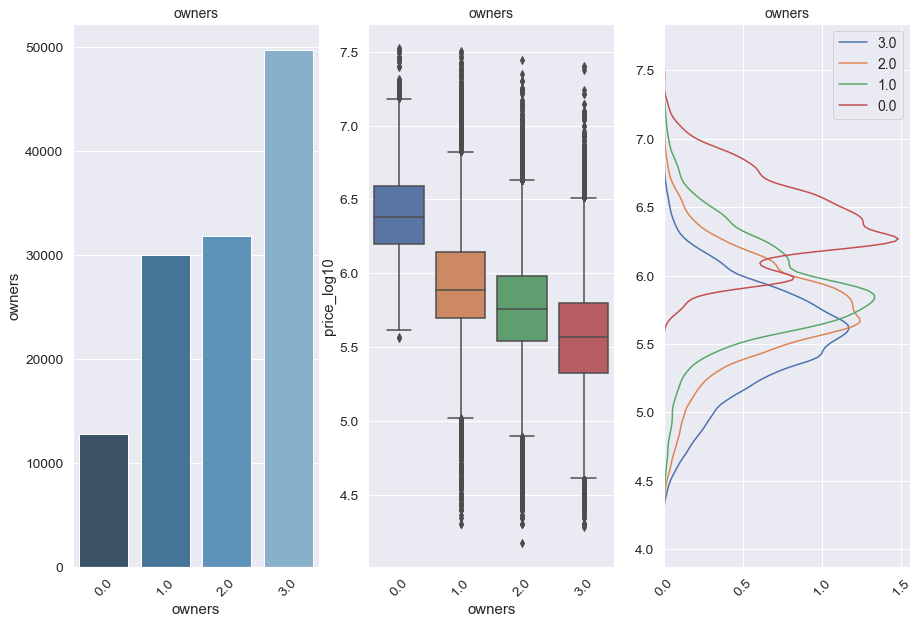

==== owners ====

Pearson correlation coefficient between 'owners' and 'price_log10' is -0.5453. 

owners
0.0    12802
1.0    29984
2.0    31835
3.0    49758
Name: owners, dtype: int64 

There are 0 missing values in 'owners'. 




In [46]:
for item in features_ordinal:
    ordinal_variable_analysis(data, item, target_name)

Вопиющих аномалий не видно.

### 3.2.2 Категориальные 'one-hot' признаки

In [47]:
features_one_hot

['computer',
 'led-lights',
 'projection-display',
 'section',
 'parktronik',
 'gear_type',
 'abs',
 'price',
 'navigation',
 'esp',
 'condition',
 'rear-camera',
 'xenon',
 'airbag-curtain',
 'air-suspension',
 'night-vision',
 'engine_type',
 'airbag-2',
 'laser-lights',
 'body_type',
 'airbag-passenger',
 'drowsy-driver-alert-system',
 'climate-control-2',
 'collision-prevention-assist',
 'mark',
 'activ-suspension',
 'sport-suspension',
 'adaptive-light',
 'auto-park',
 'transmission',
 'airbag-4',
 'multizone-climate-control',
 'park-assist-f',
 'airbag-6',
 'airbag-driver',
 'knee-airbag',
 'lane-keeping-assist',
 'advanced-frontlighting-system',
 'model',
 'climate-control-1',
 'climate-control',
 'vsm',
 'airbag-rear-side',
 'park-assist-r',
 'asr',
 'decorative-interior-lighting',
 'airbag-side',
 'airbag-1',
 'automatic-lighting-control',
 'cruise-control',
 'front-camera',
 'climate-control-3',
 'steering_wheel',
 'color',
 'auto-cruise',
 'halogen']

Вновь выведем количество уникальных значений для 'one-hot' переменных.

In [48]:
one_hot_unique = data[features_one_hot].nunique().sort_values(ascending=False)
one_hot_unique

price                            10663
model                             1398
mark                               119
color                               16
body_type                           16
engine_type                          5
transmission                         4
gear_type                            3
air-suspension                       2
collision-prevention-assist          2
climate-control-2                    2
drowsy-driver-alert-system           2
airbag-passenger                     2
laser-lights                         2
airbag-2                             2
night-vision                         2
halogen                              2
airbag-curtain                       2
activ-suspension                     2
rear-camera                          2
condition                            2
esp                                  2
navigation                           2
abs                                  2
parktronik                           2
section                  

Поскольку у двух признаков `model` и `mark` очень много категорий (1317 и 108, соответственно), их подвергать "классическому анализу".

Опустим сейчас и анализ доп.оборудования.

In [49]:
equipment_active_safety = ['abs', 'activ-suspension', 'air-suspension', 
                           'asr', 'collision-prevention-assist', 'esp', 
                           'lane-keeping-assist', 'park-assist-f', 'park-assist-r',
                           'sport-suspension', 'vsm']

equipment_climatic = ['climate-control', 'climate-control-1', 'climate-control-2',
                      'climate-control-3', 'condition', 'multizone-climate-control']

equipment_electronic_assistance = ['auto-cruise', 'auto-park', 'computer',
                                   'cruise-control', 'drowsy-driver-alert-system', 'front-camera',
                                   'navigation', 'night-vision', 'parktronik', 
                                   'projection-display', 'rear-camera']

equipment_light = ['adaptive-light', 'automatic-lighting-control', 'advanced-frontlighting-system', 
                   'decorative-interior-lighting', 'halogen', 'laser-lights', 
                   'led-lights', 'xenon']

equipment_passive_safety = ['airbag-1', 'airbag-2', 'airbag-4', 
                            'airbag-6', 'airbag-curtain', 'airbag-driver',
                            'airbag-passenger', 'airbag-rear-side', 'airbag-side', 
                            'knee-airbag']


equipment = (equipment_active_safety + equipment_climatic + equipment_electronic_assistance 
             + equipment_light + equipment_passive_safety)

# equipment

In [50]:
if target_name == 'price_log10':
    features_one_hot_short = list(set(features_one_hot) - set( ['model', 'mark', 'price'] + equipment ))
else:
    features_one_hot_short = list(set(features_one_hot) - set( ['model', 'mark'] + equipment ))
        
features_one_hot_short

['engine_type',
 'section',
 'transmission',
 'gear_type',
 'body_type',
 'steering_wheel',
 'color']

In [51]:
print( "Всего {} признаков, описывающих доп.оборудование.".format(len(equipment)) )

Всего 46 признаков, описывающих доп.оборудование.


In [52]:
# data['color'].value_counts(ascending=False)

Преобразуем 16-ричную кодировку цвета в названия.

In [53]:
## https://hysy.org/color/97948F
## https://www.colorhexa.com/0000cc

color_dict = {}

color_dict['040001'] = 'black'  ## в ПТС как чёрный (#601)
color_dict['FAFBFB'] = 'white'
color_dict['CACECB'] = 'silver'
color_dict['97948F'] = 'grey'
color_dict['0000CC'] = 'strong-blue'

color_dict['200204'] = 'mostly-black-red'  ## в ПТС как коричневый металлик (#798)
color_dict['EE1D19'] = 'vivid-red'
color_dict['007F00'] = 'dark-green'
color_dict['C49648'] = 'french-beige'
color_dict['22A0F8'] = 'vivid-blue'  ## лазурный

color_dict['FFD600'] = 'yellow'
color_dict['660099'] = 'purple'
color_dict['4A2197'] = 'dark-violet'
color_dict['DEA522'] = 'golden'
color_dict['FF8649'] = 'orange'
color_dict['FFC0CB'] = 'pink'

data['color'] = data['color'].map(color_dict)
data

body_type  doors_count        mark       model engine_type  \
0       COMPACTVAN            4      Nissan      Serena      DIESEL   
1          ALLROAD            3  LADA (ВАЗ)  2121 (4x4)    GASOLINE   
2        HATCHBACK            5  Volkswagen        Polo    GASOLINE   
3        HATCHBACK            3  LADA (ВАЗ)    1111 Ока    GASOLINE   
4        HATCHBACK            5  Volkswagen        Golf    GASOLINE   
...            ...          ...         ...         ...         ...   
124374     ALLROAD            5         УАЗ     Patriot    GASOLINE   
124375     ALLROAD            5   Chevrolet        Niva    GASOLINE   
124376     ALLROAD            5  Mitsubishi   Outlander    GASOLINE   
124377     ALLROAD            5  Mitsubishi   Outlander    GASOLINE   
124378     ALLROAD            3  LADA (ВАЗ)  2121 (4x4)    GASOLINE   

        displacement  power transmission        gear_type steering_wheel  ...  \
0               1973     91    AUTOMATIC  ALL_WHEEL_DRIVE          RIGHT  ...   
1               1690     83   MECHANICAL  ALL_WHEEL_DRIVE           LEFT  ...   
2               1598     75    AUTOMATIC  FORWARD_CONTROL           LEFT  ...   
3                649     29   MECHANICAL  FORWARD_CONTROL           LEFT  ...   
4               2324    150   MECHANICAL  FORWARD_CONTROL           LEFT  ...   
...              ...    ...          ...              ...            ...  ...   
124374          2693    135   MECHANICAL  ALL_WHEEL_DRIVE           LEFT  ...   
124375          1690     80   MECHANICAL  ALL_WHEEL_DRIVE           LEFT  ...   
124376          1998    146     VARIATOR  ALL_WHEEL_DRIVE           LEFT  ...   
124377          2360    167     VARIATOR  ALL_WHEEL_DRIVE           LEFT  ...   
124378          1690     83   MECHANICAL  ALL_WHEEL_DRIVE           LEFT  ...   

       airbag-2  airbag-4  airbag-6 airbag-curtain  airbag-driver  \
0             0         0         0              0              1   
1             0         0         0              0              0   
2             0         0         0              0              1   
3             0         0         0              0              0   
4             0         0         0              0              0   
...         ...       ...       ...            ...            ...   
124374        0         0         0              0              1   
124375        0         0         0              0              1   
124376        0         0         0              1              1   
124377        0         0         0              0              0   
124378        0         0         0              0              0   

        airbag-passenger  airbag-rear-side  airbag-side  knee-airbag  \
0                      1                 0            0            0   
1                      0                 0            0            0   
2                      1                 0            1            0   
3                      0                 0            0            0   
4                      0                 0            0            0   
...                  ...               ...          ...          ...   
124374                 1                 0            0            0   
124375                 1                 0            0            0   
124376                 1                 0            1            1   
124377                 0                 0            0            0   
124378                 0                 0            0            0   

        price_log10  
0          5.290035  
1          5.469822  
2          5.227887  
3          4.414973  
4          5.161368  
...             ...  
124374     5.929419  
124375     5.755112  
124376     6.217484  
124377     6.267172  
124378     5.707570  

[124379 rows x 63 columns]

In [54]:
def rounder(x, m=2):
    return round(x, m)

def one_hot_variable_analysis(df, item, target_name, n_bins=100, class_balance_threshold=3):
    if item != target_name:
        fig, axes = plt.subplots(1, 3, figsize=(15, 10))
    else:
        fig, axes = plt.subplots(1, 2, figsize=(15, 10))
    
    
    # ==== FIG 1 (barplot)
    bar_data = df.groupby(item)[item].count().sort_values(ascending=False)
    br_plot = sns.barplot(x=bar_data.index, y=bar_data, ax = axes[0])#, palette="Blues_d")
    br_plot.set_xticklabels(bar_data.index, rotation=90)
    axes[0].set_title(item, fontsize=FONT_SIZE)
    
    # ==== FIG 2 (boxplot)
    bx_plot = sns.boxplot(x=item, y=target_name, data=df, ax=axes[1])
    bx_plot.set_xticklabels(bar_data.index, rotation=90)
    axes[1].set_title(item, fontsize=FONT_SIZE)

    
    # ==== FIG 3 (distplot)
    values = df[item].value_counts()
    
    for value in values.index:
        sns.distplot(df[ df[item] == value ][target_name], bins=n_bins, kde=True, norm_hist=True, 
                     vertical=True, ax=axes[2], label=value)
    
    axes[2].set_title(item, fontsize=FONT_SIZE)
    axes[2].legend(fontsize=FONT_SIZE)
    
    plt.show()
    
    # === Descriptive statistics    
    
    print("==== {} ====\n".format(item))
    
    
    print(bar_data, "\n")
    
    
    values = df[item].value_counts()
    k = 0
    for value in values.index:
        describer_value = pd.DataFrame(df[ df[item] == value ][target_name].describe())
#         ! print("!!!\n", values, "\n")
        if k == 0:
            describer = describer_value.copy()
        else:
            describer = pd.concat([describer, describer_value], axis=1)
        k += 1    
    describer.columns = values.index
    describer = describer.T
    describer_moments = pd.DataFrame([describer.mean(), describer.std()], index=['MEAN', 'STD'])
    describer = pd.concat([describer, describer_moments], axis=0)
    describer = describer.apply(rounder)
    print(describer, "\n")
    
    print("There are {} missing values in '{}'.".format( df[item].isna().sum(), item ), '\n'*2)
    
#     if class_balance_threshold > 0:
#         print("Class balance ratio (to previous):")
#         bar_data_sorted = bar_data.sort_values()
#         class_balance_ratio = round(np.exp(np.log(bar_data_sorted).diff()), 2)
#         print(class_balance_ratio, "\n")    
#         if class_balance_ratio.max() > class_balance_threshold:
#             print("It seems to be a severe CLASS IMBALANCE: Maximal Class balance ratio (to previous) is", 
#                   class_balance_ratio.max(), "\n")
#         else:
#             print("Maximal Class balance ratio (to previous) is ", class_balance_ratio.max(), "\n")
#         return class_balance_ratio.max()

In [55]:
features_one_hot_short

['engine_type',
 'section',
 'transmission',
 'gear_type',
 'body_type',
 'steering_wheel',
 'color']

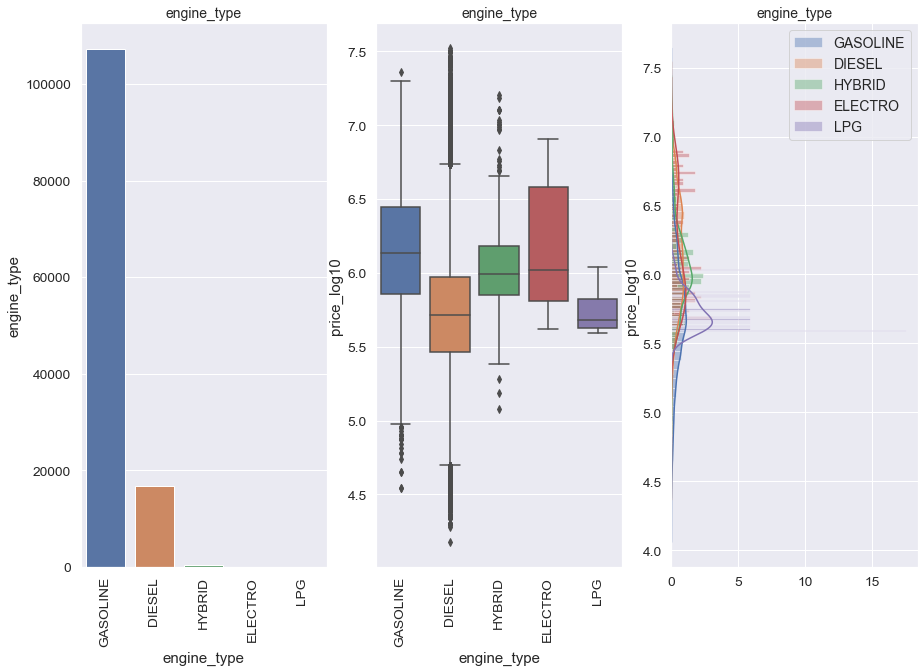

==== engine_type ====

engine_type
GASOLINE    107178
DIESEL       16718
HYBRID         375
ELECTRO         89
LPG             19
Name: engine_type, dtype: int64 

              count  mean   std   min   25%   50%   75%   max
GASOLINE  107178.00  5.72  0.43  4.18  5.46  5.72  5.97  7.52
DIESEL     16718.00  6.15  0.40  4.54  5.85  6.13  6.45  7.36
HYBRID       375.00  6.04  0.34  5.08  5.85  6.00  6.18  7.20
ELECTRO       89.00  6.14  0.40  5.62  5.81  6.02  6.59  6.91
LPG           19.00  5.72  0.12  5.59  5.63  5.68  5.82  6.04
MEAN       24875.80  5.95  0.34  5.00  5.72  5.91  6.20  7.01
STD        46563.77  0.22  0.13  0.64  0.17  0.20  0.32  0.59 

There are 0 missing values in 'engine_type'. 




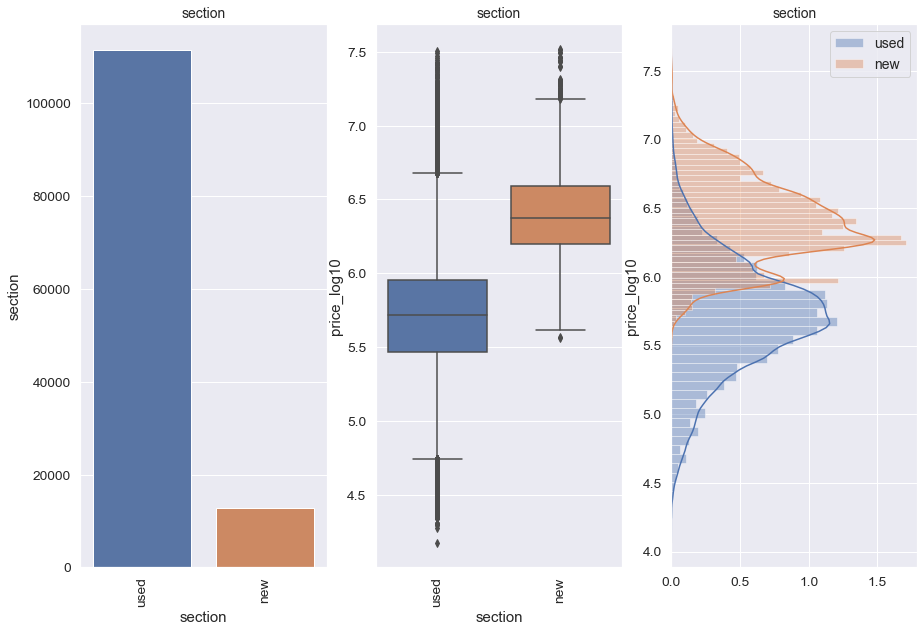

==== section ====

section
used    111577
new      12802
Name: section, dtype: int64 

          count  mean   std   min   25%   50%   75%   max
used  111577.00  5.71  0.41  4.18  5.47  5.72  5.95  7.51
new    12802.00  6.39  0.30  5.56  6.20  6.38  6.59  7.52
MEAN   62189.50  6.05  0.36  4.87  5.84  6.05  6.27  7.51
STD    69844.47  0.49  0.08  0.98  0.52  0.47  0.45  0.01 

There are 0 missing values in 'section'. 




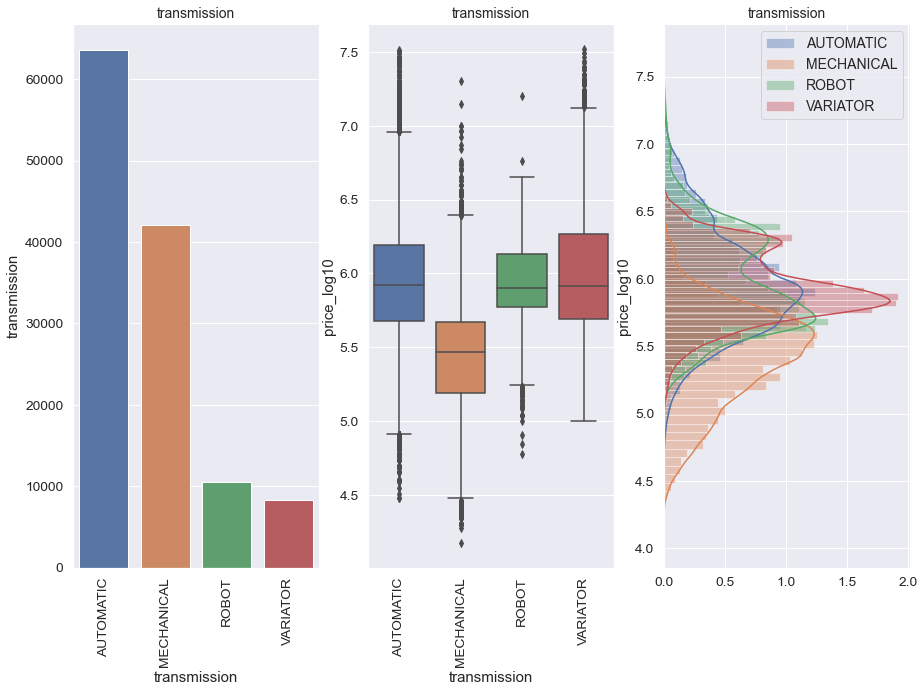

==== transmission ====

transmission
AUTOMATIC     63608
MECHANICAL    42048
ROBOT         10482
VARIATOR       8241
Name: transmission, dtype: int64 

               count  mean   std   min   25%   50%   75%   max
AUTOMATIC   63608.00  5.96  0.40  4.48  5.68  5.92  6.19  7.51
MECHANICAL  42048.00  5.42  0.36  4.18  5.19  5.47  5.67  7.30
ROBOT       10482.00  5.98  0.37  5.00  5.69  5.91  6.27  7.52
VARIATOR     8241.00  5.94  0.26  4.78  5.77  5.90  6.13  7.20
MEAN        31094.75  5.82  0.35  4.61  5.58  5.80  6.07  7.38
STD         26609.93  0.27  0.06  0.36  0.27  0.22  0.27  0.16 

There are 0 missing values in 'transmission'. 




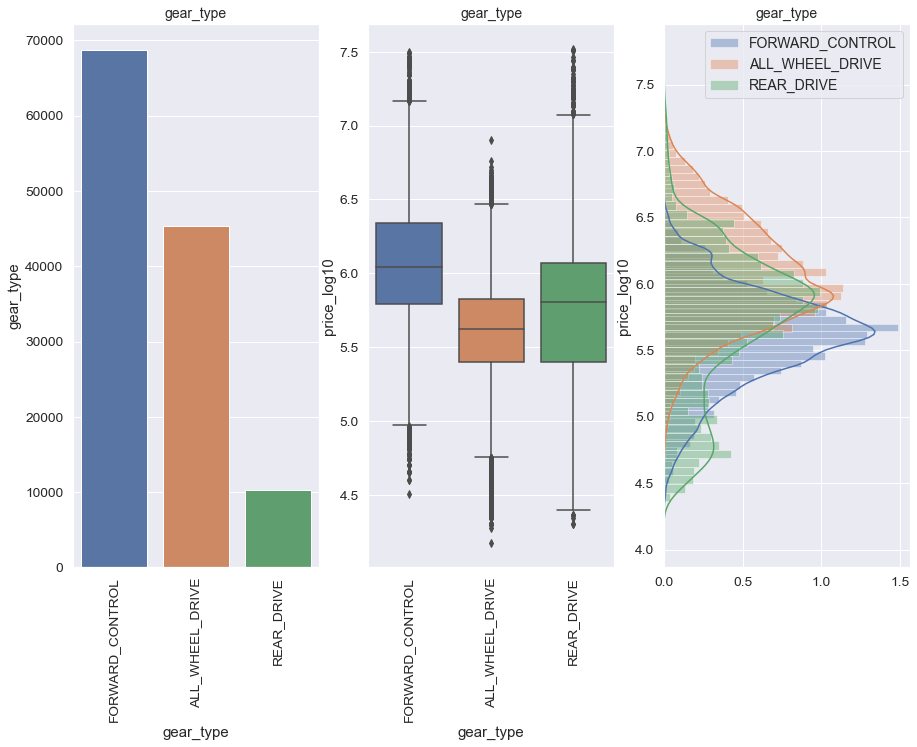

==== gear_type ====

gear_type
FORWARD_CONTROL    68760
ALL_WHEEL_DRIVE    45315
REAR_DRIVE         10304
Name: gear_type, dtype: int64 

                    count  mean   std   min   25%   50%   75%   max
FORWARD_CONTROL  68760.00  5.60  0.36  4.18  5.40  5.62  5.83  6.90
ALL_WHEEL_DRIVE  45315.00  6.06  0.41  4.51  5.79  6.04  6.34  7.50
REAR_DRIVE       10304.00  5.70  0.55  4.30  5.40  5.81  6.07  7.52
MEAN             41459.67  5.79  0.44  4.33  5.53  5.82  6.08  7.31
STD              29418.08  0.24  0.10  0.17  0.23  0.21  0.26  0.35 

There are 0 missing values in 'gear_type'. 




C:\Users\DNS\anaconda3\lib\site-packages\seaborn\distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)


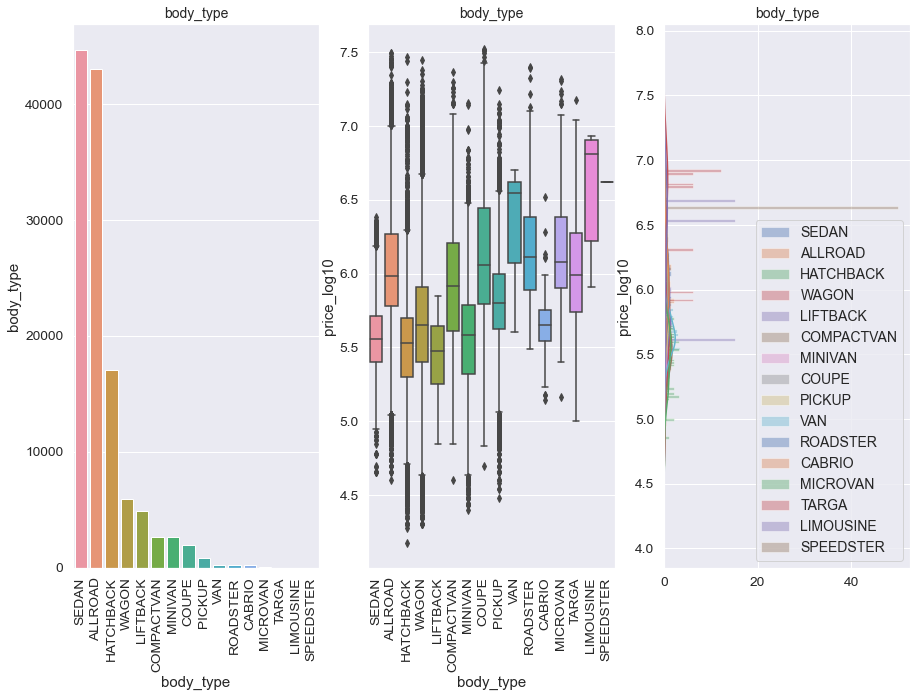

==== body_type ====

body_type
SEDAN         44664
ALLROAD       43019
HATCHBACK     17081
WAGON          5918
LIFTBACK       4910
COMPACTVAN     2635
MINIVAN        2622
COUPE          1959
PICKUP          834
VAN             268
ROADSTER        209
CABRIO          201
MICROVAN         47
TARGA             8
LIMOUSINE         3
SPEEDSTER         1
Name: body_type, dtype: int64 

               count  mean   std   min   25%   50%   75%   max
SEDAN       44664.00  5.65  0.45  4.30  5.40  5.65  5.91  7.45
ALLROAD     43019.00  6.03  0.37  4.60  5.78  5.99  6.27  7.50
HATCHBACK   17081.00  5.49  0.36  4.18  5.30  5.53  5.70  7.47
WAGON        5918.00  5.55  0.38  4.40  5.32  5.59  5.79  7.16
LIFTBACK     4910.00  5.80  0.36  4.48  5.62  5.80  6.00  7.24
COMPACTVAN   2635.00  5.58  0.27  4.65  5.40  5.56  5.72  6.38
MINIVAN      2622.00  5.93  0.41  4.60  5.61  5.92  6.20  7.36
COUPE        1959.00  6.12  0.50  4.70  5.79  6.06  6.45  7.52
PICKUP        834.00  6.01  0.36  5.00  5.74  5.99

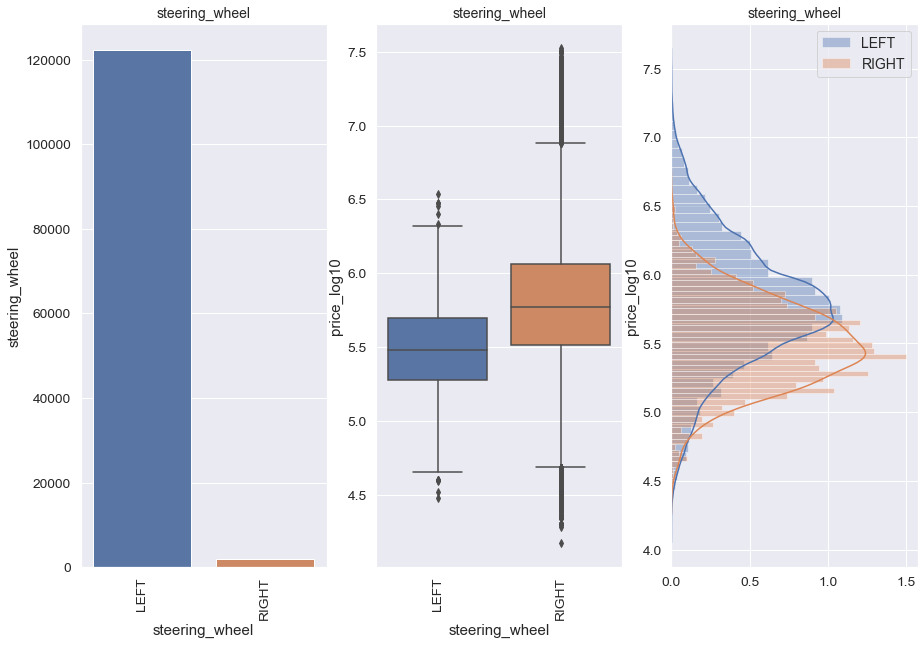

==== steering_wheel ====

steering_wheel
LEFT     122371
RIGHT      2008
Name: steering_wheel, dtype: int64 

           count  mean   std   min   25%   50%   75%   max
LEFT   122371.00  5.78  0.45  4.18  5.51  5.77  6.06  7.52
RIGHT    2008.00  5.49  0.31  4.48  5.28  5.48  5.70  6.54
MEAN    62189.50  5.64  0.38  4.33  5.40  5.62  5.88  7.03
STD     85109.49  0.21  0.10  0.21  0.16  0.21  0.26  0.70 

There are 0 missing values in 'steering_wheel'. 




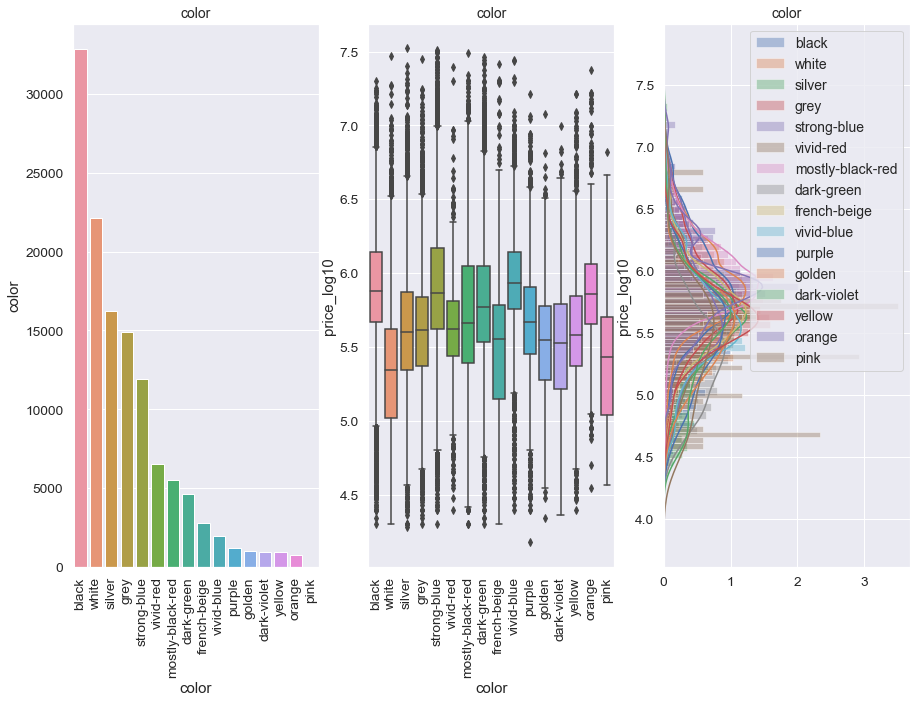

==== color ====

color
black               32810
white               22103
silver              16234
grey                14882
strong-blue         11952
vivid-red            6533
mostly-black-red     5534
dark-green           4626
french-beige         2780
vivid-blue           1951
purple               1188
golden               1054
dark-violet           985
yellow                951
orange                758
pink                   38
Name: color, dtype: int64 

                     count  mean   std   min   25%   50%   75%   max
black             32810.00  5.90  0.43  4.30  5.62  5.87  6.17  7.51
white             22103.00  5.90  0.39  4.30  5.67  5.88  6.15  7.30
silver            16234.00  5.60  0.38  4.30  5.37  5.61  5.84  7.45
grey              14882.00  5.80  0.45  4.30  5.53  5.77  6.05  7.47
strong-blue       11952.00  5.71  0.51  4.30  5.39  5.66  6.05  7.49
vivid-red          6533.00  5.61  0.46  4.28  5.34  5.60  5.87  7.52
mostly-black-red   5534.00  5.96  0.33  4.40  5.76

In [56]:
for item in features_one_hot_short:
    one_hot_variable_analysis(data, item, target_name, n_bins=50)

Странности:
1. `body_type` - три типа кузова с очень малым числом машин:
 - TARGA            - 8 
 - LIMOUSINE        - 3 
 - SPEEDSTER        - 1 

2. `engine_type` - Всего 19 машин с двигателем на газу. Они погоду не сделают - удалим.
 - LPG            - 19

In [57]:
data['body_type'].value_counts()

SEDAN         44664
ALLROAD       43019
HATCHBACK     17081
WAGON          5918
LIFTBACK       4910
COMPACTVAN     2635
MINIVAN        2622
COUPE          1959
PICKUP          834
VAN             268
ROADSTER        209
CABRIO          201
MICROVAN         47
TARGA             8
LIMOUSINE         3
SPEEDSTER         1
Name: body_type, dtype: int64

In [58]:
data[ data['body_type']=='TARGA' ]

body_type  doors_count     mark model engine_type  displacement  power  \
13996     TARGA            2  Porsche   911    GASOLINE          3436    350   
14411     TARGA            2  Porsche   911    GASOLINE          3800    430   
14676     TARGA            2  Porsche   911    GASOLINE          3800    400   
19652     TARGA            2  Porsche   911    GASOLINE          3596    320   
31278     TARGA            2   Toyota   MR2    GASOLINE          1998    170   
32200     TARGA            2   Toyota   MR2    GASOLINE          1998    170   
71985     TARGA            2  Porsche   911    GASOLINE          2981    370   
72530     TARGA            2  Porsche   911    GASOLINE          2981    370   

      transmission        gear_type steering_wheel  ... airbag-2  airbag-4  \
13996        ROBOT  ALL_WHEEL_DRIVE           LEFT  ...        0         0   
14411        ROBOT  ALL_WHEEL_DRIVE           LEFT  ...        0         0   
14676        ROBOT  ALL_WHEEL_DRIVE           LEFT  ...        0         0   
19652   MECHANICAL       REAR_DRIVE           LEFT  ...        0         0   
31278   MECHANICAL       REAR_DRIVE           LEFT  ...        0         0   
32200   MECHANICAL       REAR_DRIVE          RIGHT  ...        0         0   
71985        ROBOT  ALL_WHEEL_DRIVE           LEFT  ...        0         0   
72530        ROBOT  ALL_WHEEL_DRIVE           LEFT  ...        0         0   

       airbag-6 airbag-curtain  airbag-driver  airbag-passenger  \
13996         0              1              1                 1   
14411         0              0              0                 0   
14676         0              1              1                 1   
19652         0              0              1                 1   
31278         0              0              0                 0   
32200         0              0              0                 0   
71985         0              0              0                 0   
72530         0              1              1                 1   

       airbag-rear-side  airbag-side  knee-airbag  price_log10  
13996                 1            1            0     6.792392  
14411                 0            0            0     6.919078  
14676                 0            1            0     6.822822  
19652                 0            0            0     6.301030  
31278                 0            0            0     5.980003  
32200                 0            0            0     5.909741  
71985                 0            0            0     6.903090  
72530                 0            1            0     6.929419  

[8 rows x 63 columns]

In [59]:
data[ data['body_type']=='LIMOUSINE' ]

body_type  doors_count           mark    model engine_type  \
73     LIMOUSINE            4  Mercedes-Benz  S-Класс    GASOLINE   
20755  LIMOUSINE            4  Mercedes-Benz  S-Класс    GASOLINE   
87227  LIMOUSINE            4  Mercedes-Benz  S-Класс    GASOLINE   

       displacement  power transmission   gear_type steering_wheel  ...  \
73             5987    394    AUTOMATIC  REAR_DRIVE           LEFT  ...   
20755          5513    500    AUTOMATIC  REAR_DRIVE           LEFT  ...   
87227          4966    306    AUTOMATIC  REAR_DRIVE           LEFT  ...   

      airbag-2  airbag-4  airbag-6 airbag-curtain  airbag-driver  \
73           0         0         0              0              0   
20755        0         0         0              0              0   
87227        0         0         0              0              0   

       airbag-passenger  airbag-rear-side  airbag-side  knee-airbag  \
73                    0                 0            0            0   
20755                 0                 0            0            0   
87227                 0                 0            0            0   

       price_log10  
73        6.544068  
20755     6.698970  
87227     5.602060  

[3 rows x 63 columns]

In [60]:
data[ (data['mark']=='Mercedes-Benz') & (data['model']=='S-Класс') ]['body_type'].value_counts()

SEDAN        796
COUPE         36
LIMOUSINE      3
CABRIO         1
Name: body_type, dtype: int64

In [61]:
data[ data['body_type']=='SPEEDSTER' ]

body_type  doors_count     mark model engine_type  displacement  \
117271  SPEEDSTER            2  Ferrari   360    GASOLINE          3586   

        power transmission   gear_type steering_wheel  ... airbag-2  airbag-4  \
117271    400        ROBOT  REAR_DRIVE           LEFT  ...        0         0   

        airbag-6 airbag-curtain  airbag-driver  airbag-passenger  \
117271         0              0              0                 0   

        airbag-rear-side  airbag-side  knee-airbag  price_log10  
117271                 0            0            0     6.623249  

[1 rows x 63 columns]

Основываясь на статье в вики "[Car body style]" (https://en.wikipedia.org/wiki/Car_body_style) укрупним категории кузова в соответсвии с таблицей (невошедшие - без изменений):

| было | стало |
| :-- | :-- |
| WAGON          | VAN |
| MINIVAN        | VAN |
| COMPACTVAN     | VAN |
| MICROVAN       | VAN |
| TARGA          | CABRIO |
| LIMOUSINE      | SEDAN |
| SPEEDSTER      | COUPE  |

In [62]:
dict_body = {}

dict_body['ALLROAD'] = 'ALLROAD'
dict_body['SEDAN'] = 'SEDAN'
dict_body['HATCHBACK'] = 'HATCHBACK'

dict_body['WAGON'] = 'VAN'
dict_body['MINIVAN'] = 'VAN'
dict_body['COMPACTVAN'] = 'VAN'

dict_body['COUPE'] = 'COUPE'
dict_body['PICKUP'] = 'PICKUP'
dict_body['VAN'] = 'VAN'
dict_body['ROADSTER'] = 'ROADSTER'
dict_body['CABRIO'] = 'CABRIO'

dict_body['MICROVAN'] = 'VAN'
dict_body['TARGA'] = 'CABRIO'
dict_body['LIMOUSINE'] = 'SEDAN'
dict_body['SPEEDSTER'] = 'COUPE'

data['body_type'] = data['body_type'].map(dict_body)
data['body_type'].value_counts()

SEDAN        44667
ALLROAD      43019
HATCHBACK    17081
VAN          11490
COUPE         1960
PICKUP         834
CABRIO         209
ROADSTER       209
Name: body_type, dtype: int64

In [64]:
data = data[ data['engine_type'] != 'LPG' ]
data['engine_type'].value_counts()

GASOLINE    107178
DIESEL       16718
HYBRID         375
ELECTRO         89
Name: engine_type, dtype: int64

После "первичной очистки" снова глянем на категориальные one_hot признаки:

In [65]:
features_one_hot_short

['engine_type',
 'section',
 'transmission',
 'gear_type',
 'body_type',
 'steering_wheel',
 'color']

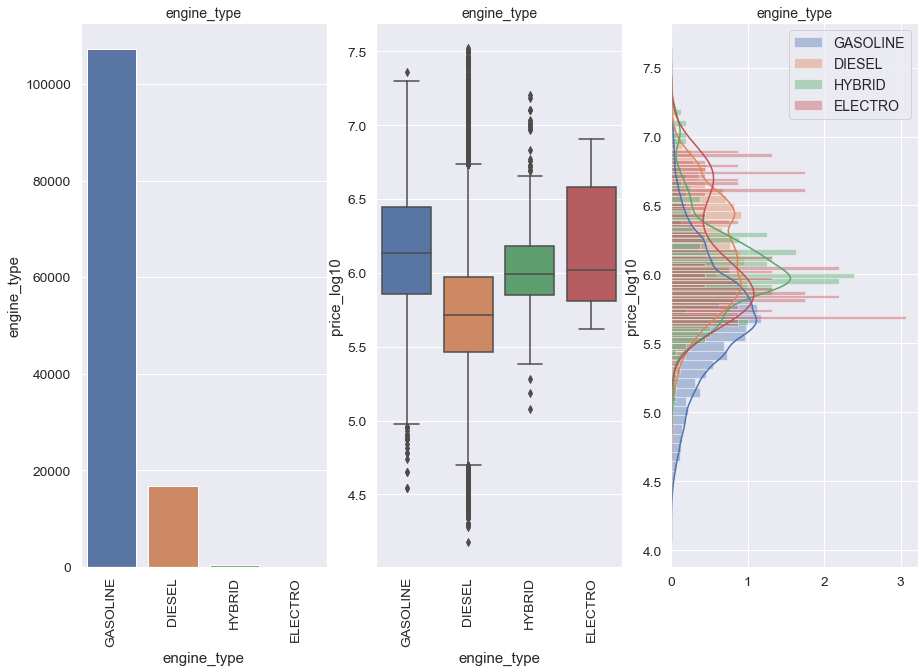

==== engine_type ====

engine_type
GASOLINE    107178
DIESEL       16718
HYBRID         375
ELECTRO         89
Name: engine_type, dtype: int64 

              count  mean   std   min   25%   50%   75%   max
GASOLINE  107178.00  5.72  0.43  4.18  5.46  5.72  5.97  7.52
DIESEL     16718.00  6.15  0.40  4.54  5.85  6.13  6.45  7.36
HYBRID       375.00  6.04  0.34  5.08  5.85  6.00  6.18  7.20
ELECTRO       89.00  6.14  0.40  5.62  5.81  6.02  6.59  6.91
MEAN       31090.00  6.01  0.39  4.86  5.74  5.97  6.30  7.25
STD        51317.35  0.20  0.04  0.63  0.19  0.18  0.27  0.26 

There are 0 missing values in 'engine_type'. 




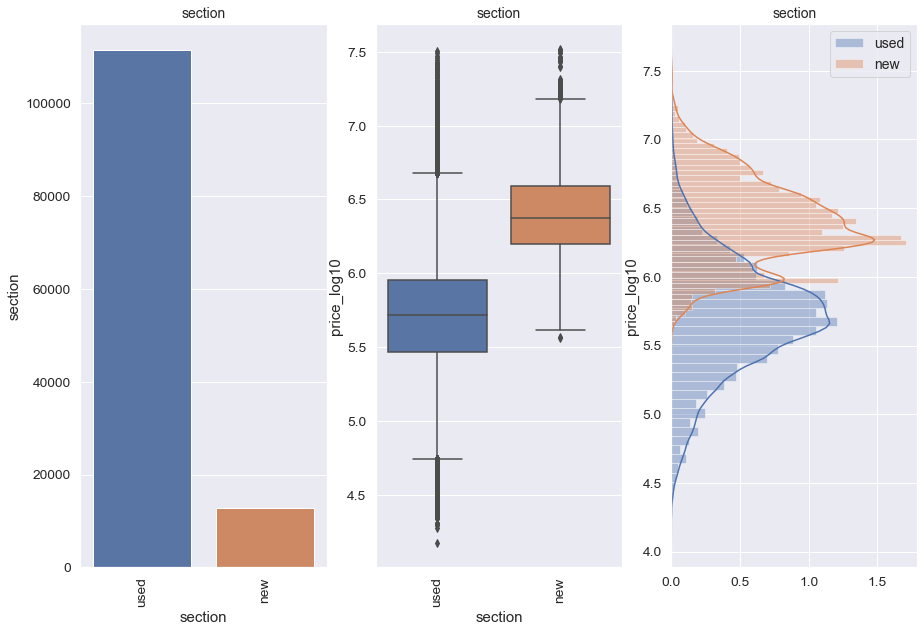

==== section ====

section
used    111559
new      12801
Name: section, dtype: int64 

          count  mean   std   min   25%   50%   75%   max
used  111559.00  5.71  0.41  4.18  5.47  5.72  5.95  7.51
new    12801.00  6.39  0.30  5.56  6.20  6.38  6.59  7.52
MEAN   62180.00  6.05  0.36  4.87  5.84  6.05  6.27  7.51
STD    69832.45  0.49  0.08  0.98  0.52  0.47  0.45  0.01 

There are 0 missing values in 'section'. 




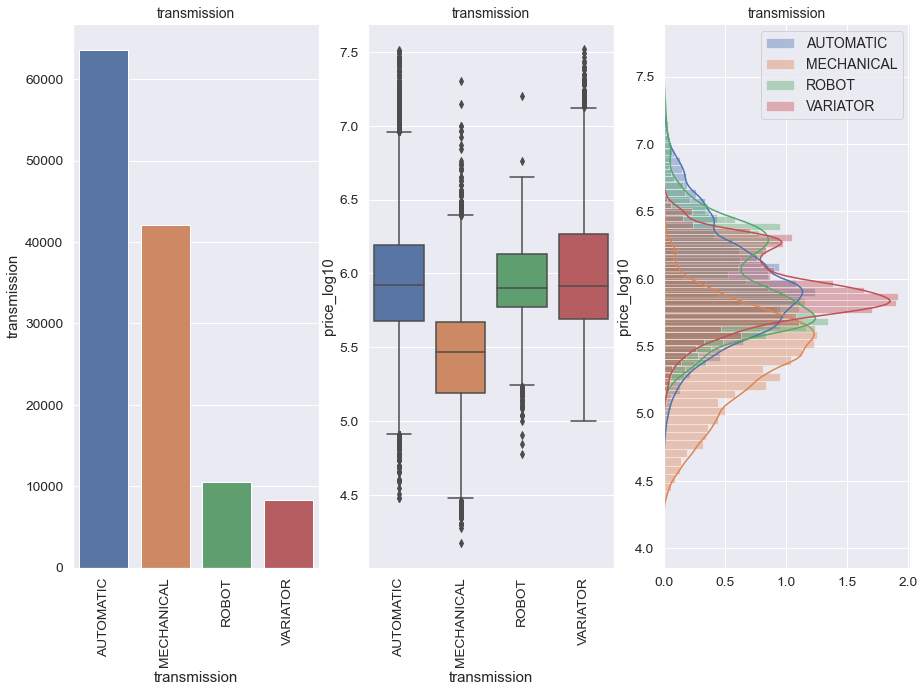

==== transmission ====

transmission
AUTOMATIC     63606
MECHANICAL    42042
ROBOT         10471
VARIATOR       8241
Name: transmission, dtype: int64 

               count  mean   std   min   25%   50%   75%   max
AUTOMATIC   63606.00  5.96  0.40  4.48  5.68  5.92  6.19  7.51
MECHANICAL  42042.00  5.42  0.36  4.18  5.19  5.47  5.67  7.30
ROBOT       10471.00  5.98  0.37  5.00  5.69  5.91  6.27  7.52
VARIATOR     8241.00  5.94  0.26  4.78  5.77  5.90  6.13  7.20
MEAN        31090.00  5.82  0.35  4.61  5.58  5.80  6.07  7.38
STD         26611.13  0.27  0.06  0.36  0.27  0.22  0.27  0.16 

There are 0 missing values in 'transmission'. 




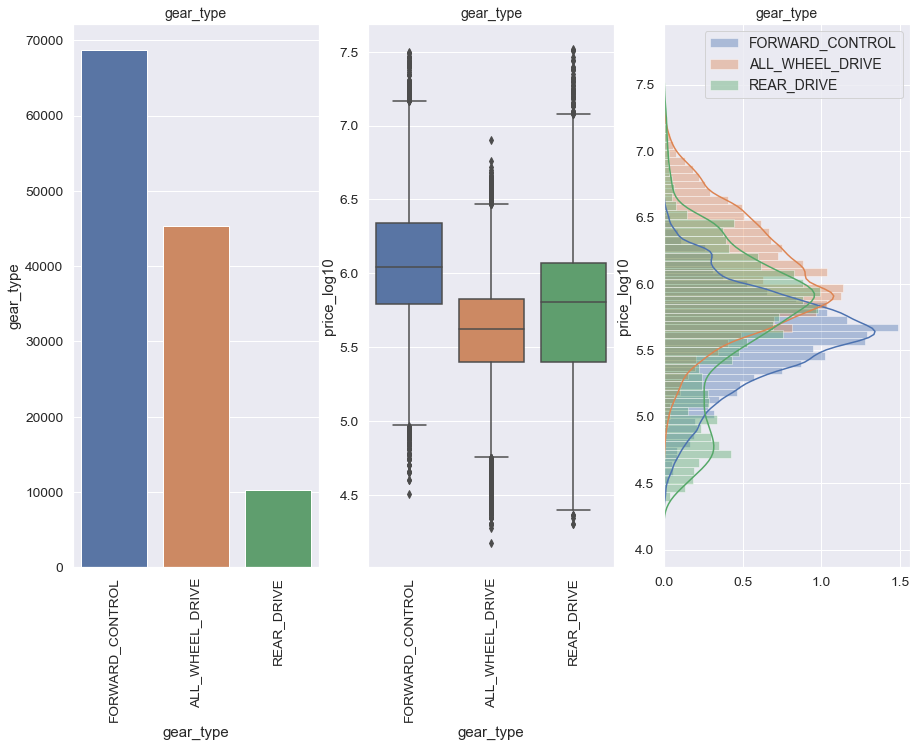

==== gear_type ====

gear_type
FORWARD_CONTROL    68743
ALL_WHEEL_DRIVE    45315
REAR_DRIVE         10302
Name: gear_type, dtype: int64 

                    count  mean   std   min   25%   50%   75%   max
FORWARD_CONTROL  68743.00  5.60  0.36  4.18  5.40  5.62  5.83  6.90
ALL_WHEEL_DRIVE  45315.00  6.06  0.41  4.51  5.79  6.04  6.34  7.50
REAR_DRIVE       10302.00  5.70  0.55  4.30  5.40  5.81  6.07  7.52
MEAN             41453.33  5.79  0.44  4.33  5.53  5.82  6.08  7.31
STD              29411.26  0.24  0.10  0.17  0.23  0.21  0.26  0.35 

There are 0 missing values in 'gear_type'. 




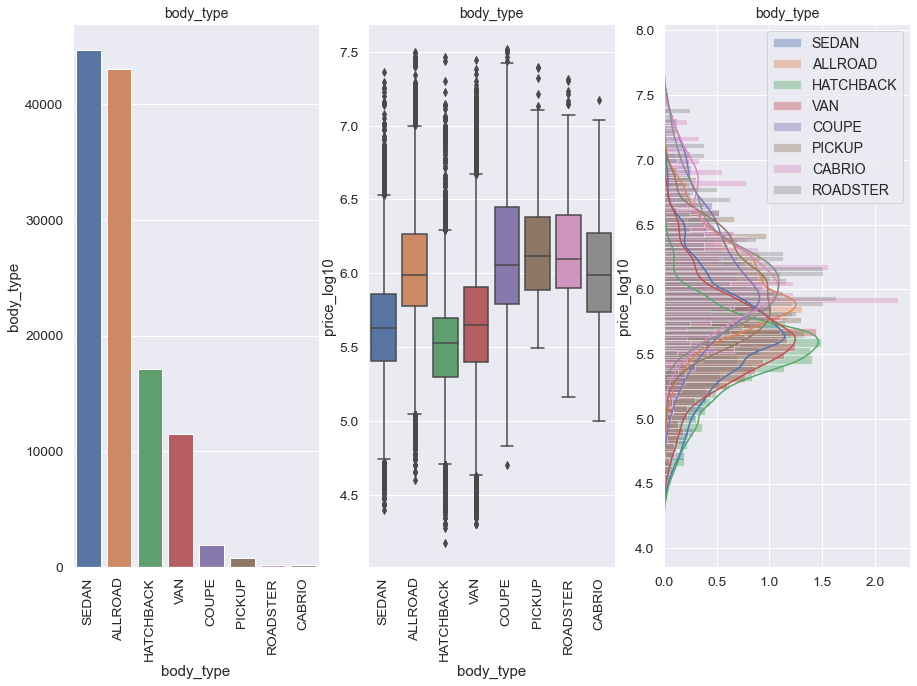

==== body_type ====

body_type
SEDAN        44661
ALLROAD      43019
HATCHBACK    17081
VAN          11477
COUPE         1960
PICKUP         834
ROADSTER       209
CABRIO         209
Name: body_type, dtype: int64 

              count  mean   std   min   25%   50%   75%   max
SEDAN      44661.00  5.65  0.45  4.30  5.40  5.65  5.91  7.45
ALLROAD    43019.00  6.03  0.37  4.60  5.78  5.99  6.27  7.50
HATCHBACK  17081.00  5.49  0.36  4.18  5.30  5.53  5.70  7.47
VAN        11477.00  5.64  0.39  4.40  5.41  5.63  5.86  7.36
COUPE       1960.00  6.12  0.50  4.70  5.79  6.06  6.45  7.52
PICKUP       834.00  6.01  0.36  5.00  5.74  5.99  6.27  7.18
CABRIO       209.00  6.19  0.43  5.16  5.90  6.10  6.40  7.32
ROADSTER     209.00  6.17  0.39  5.49  5.89  6.11  6.38  7.40
MEAN       14931.25  5.91  0.41  4.73  5.65  5.88  6.15  7.40
STD        18859.66  0.27  0.05  0.46  0.24  0.24  0.29  0.11 

There are 4910 missing values in 'body_type'. 




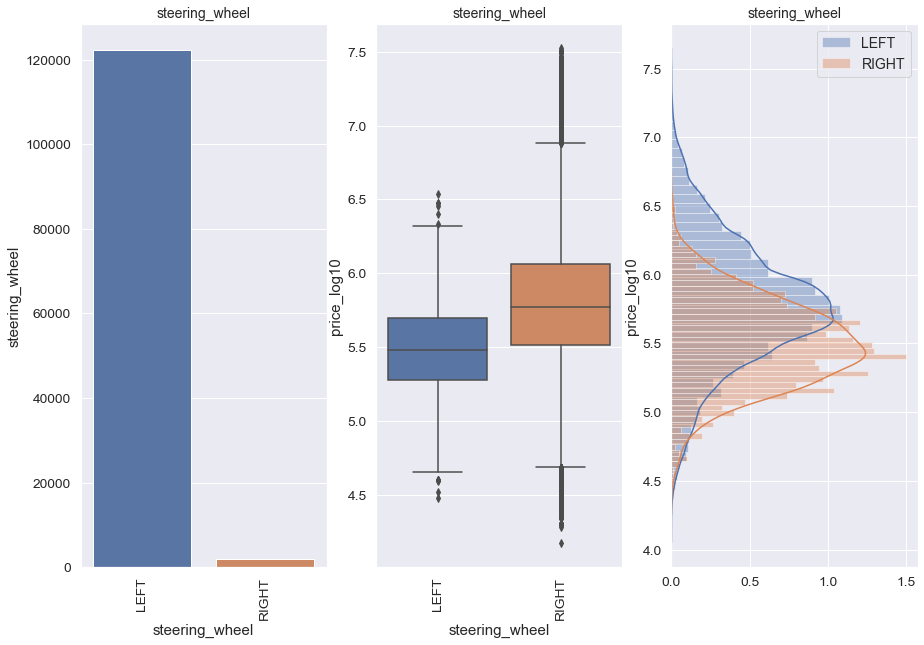

==== steering_wheel ====

steering_wheel
LEFT     122352
RIGHT      2008
Name: steering_wheel, dtype: int64 

           count  mean   std   min   25%   50%   75%   max
LEFT   122352.00  5.78  0.45  4.18  5.51  5.77  6.06  7.52
RIGHT    2008.00  5.49  0.31  4.48  5.28  5.48  5.70  6.54
MEAN    62180.00  5.64  0.38  4.33  5.40  5.62  5.88  7.03
STD     85096.06  0.21  0.10  0.21  0.16  0.21  0.26  0.70 

There are 0 missing values in 'steering_wheel'. 




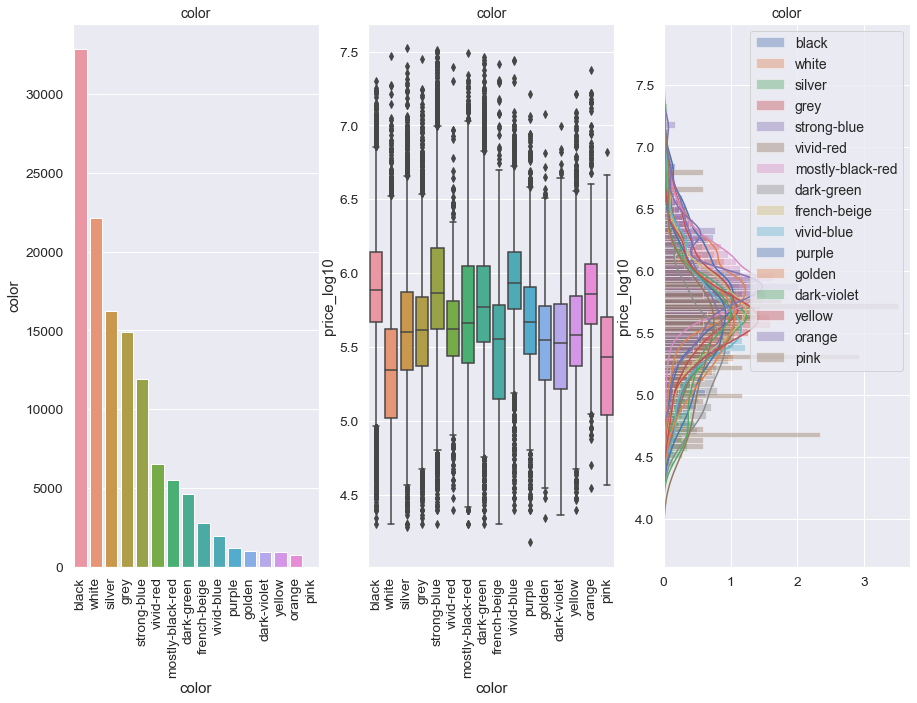

==== color ====

color
black               32807
white               22097
silver              16233
grey                14881
strong-blue         11949
vivid-red            6532
mostly-black-red     5533
dark-green           4625
french-beige         2780
vivid-blue           1949
purple               1188
golden               1054
dark-violet           985
yellow                951
orange                758
pink                   38
Name: color, dtype: int64 

                     count  mean   std   min   25%   50%   75%   max
black             32807.00  5.90  0.43  4.30  5.62  5.87  6.17  7.51
white             22097.00  5.90  0.39  4.30  5.67  5.88  6.15  7.30
silver            16233.00  5.60  0.38  4.30  5.37  5.61  5.84  7.45
grey              14881.00  5.80  0.45  4.30  5.53  5.77  6.05  7.47
strong-blue       11949.00  5.71  0.51  4.30  5.39  5.66  6.05  7.49
vivid-red          6532.00  5.61  0.46  4.28  5.34  5.60  5.87  7.52
mostly-black-red   5533.00  5.96  0.33  4.40  5.76

In [66]:
for item in features_one_hot_short:
    one_hot_variable_analysis(data, item, target_name, n_bins=50)

Вопиющих аномалий не видно.

# 4 Преобразование данных

In [67]:
data = data.drop(['price_log10'], axis=1)

target_name = 'price'

## 4.1 Преобразование типа данных

In [68]:
data.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 124360 entries, 0 to 124378
Data columns (total 62 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   body_type                      119450 non-null  object 
 1   doors_count                    124360 non-null  int64  
 2   mark                           124360 non-null  object 
 3   model                          124360 non-null  object 
 4   engine_type                    124360 non-null  object 
 5   displacement                   124360 non-null  int64  
 6   power                          124360 non-null  int64  
 7   transmission                   124360 non-null  object 
 8   gear_type                      124360 non-null  object 
 9   steering_wheel                 124360 non-null  object 
 10  color                          124360 non-null  object 
 11  mileage                        124360 non-null  int64  
 12  year                          

In [69]:
data['owners'] = data['owners'].astype('int')
features_as_category = list( features_categorical_set - set(['doors_count', 'owners', 'price']) )

features_as_category

['computer',
 'led-lights',
 'projection-display',
 'section',
 'parktronik',
 'gear_type',
 'abs',
 'navigation',
 'esp',
 'condition',
 'rear-camera',
 'xenon',
 'airbag-curtain',
 'air-suspension',
 'night-vision',
 'engine_type',
 'airbag-2',
 'laser-lights',
 'body_type',
 'airbag-passenger',
 'drowsy-driver-alert-system',
 'climate-control-2',
 'collision-prevention-assist',
 'mark',
 'activ-suspension',
 'sport-suspension',
 'adaptive-light',
 'auto-park',
 'transmission',
 'airbag-4',
 'multizone-climate-control',
 'park-assist-f',
 'airbag-6',
 'airbag-driver',
 'knee-airbag',
 'lane-keeping-assist',
 'advanced-frontlighting-system',
 'model',
 'climate-control-1',
 'climate-control',
 'vsm',
 'airbag-rear-side',
 'park-assist-r',
 'asr',
 'decorative-interior-lighting',
 'airbag-side',
 'airbag-1',
 'automatic-lighting-control',
 'cruise-control',
 'front-camera',
 'climate-control-3',
 'steering_wheel',
 'color',
 'auto-cruise',
 'halogen']

In [70]:
for item in features_as_category:
    data[item] = data[item].astype('category')
    
data.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 124360 entries, 0 to 124378
Data columns (total 62 columns):
 #   Column                         Non-Null Count   Dtype   
---  ------                         --------------   -----   
 0   body_type                      119450 non-null  category
 1   doors_count                    124360 non-null  int64   
 2   mark                           124360 non-null  category
 3   model                          124360 non-null  category
 4   engine_type                    124360 non-null  category
 5   displacement                   124360 non-null  int64   
 6   power                          124360 non-null  int64   
 7   transmission                   124360 non-null  category
 8   gear_type                      124360 non-null  category
 9   steering_wheel                 124360 non-null  category
 10  color                          124360 non-null  category
 11  mileage                        124360 non-null  int64   
 12  year            

## 4.2 Преобразование *One-Hot* переменных

*One-Hot* переменные преобразуем в *dummy*-переменные, откинув одну *dummy*-переменную во избежании *dummy*-ловушки. Это необходимо мделать для "дерева" и "леса". Поэтому в конечной версии, когда применяется LightGBM, это и следующий пункт не применяются.

In [71]:
data_model = data.copy()

In [72]:
# data_model = pd.get_dummies(data, columns=features_one_hot, drop_first=True).copy()
# data_model.columns
# data_model

## 4.3 Преобразование *Ordinal* переменных

Не требуется.

In [73]:
# data = data.drop(['owners'], axis=1)

In [74]:
print(features_ordinal)

# ord_encoder = OrdinalEncoder()

# data_ordinal = pd.DataFrame(ord_encoder.fit_transform(data_model[features_ordinal]), 
#                             columns=data_model[features_ordinal].columns, index=data_model.index)

# data_model[features_ordinal]

['doors_count', 'owners']


In [75]:
# minmax_scaler = MinMaxScaler()
# data_scaled = minmax_scaler.fit_transform(data_ordinal)
# data_model[data_ordinal] = data_scaled

## 4.4 Масштабирование численных переменных

In [76]:
features_numerical

['displacement', 'power', 'mileage', 'year']

In [77]:
stand_scaler = StandardScaler()
stand_scaler.fit(data_model[features_numerical])
data_scaled = pd.DataFrame(stand_scaler.transform(data_model[features_numerical]), 
                          columns=data_model[features_numerical].columns, index=data_model.index, )
data_model[features_numerical] = data_scaled[features_numerical]
data_model

body_type  doors_count        mark       model engine_type  \
0             VAN            4      Nissan      Serena      DIESEL   
1         ALLROAD            3  LADA (ВАЗ)  2121 (4x4)    GASOLINE   
2       HATCHBACK            5  Volkswagen        Polo    GASOLINE   
3       HATCHBACK            3  LADA (ВАЗ)    1111 Ока    GASOLINE   
4       HATCHBACK            5  Volkswagen        Golf    GASOLINE   
...           ...          ...         ...         ...         ...   
124374    ALLROAD            5         УАЗ     Patriot    GASOLINE   
124375    ALLROAD            5   Chevrolet        Niva    GASOLINE   
124376    ALLROAD            5  Mitsubishi   Outlander    GASOLINE   
124377    ALLROAD            5  Mitsubishi   Outlander    GASOLINE   
124378    ALLROAD            3  LADA (ВАЗ)  2121 (4x4)    GASOLINE   

        displacement     power transmission        gear_type steering_wheel  \
0          -0.204315 -0.870679    AUTOMATIC  ALL_WHEEL_DRIVE          RIGHT   
1          -0.529058 -0.967374   MECHANICAL  ALL_WHEEL_DRIVE           LEFT   
2          -0.634628 -1.064069    AUTOMATIC  FORWARD_CONTROL           LEFT   
3          -1.723606 -1.620067   MECHANICAL  FORWARD_CONTROL           LEFT   
4           0.198458 -0.157552   MECHANICAL  FORWARD_CONTROL           LEFT   
...              ...       ...          ...              ...            ...   
124374      0.621886 -0.338855   MECHANICAL  ALL_WHEEL_DRIVE           LEFT   
124375     -0.529058 -1.003635   MECHANICAL  ALL_WHEEL_DRIVE           LEFT   
124376     -0.175627 -0.205899     VARIATOR  ALL_WHEEL_DRIVE           LEFT   
124377      0.239768  0.047926     VARIATOR  ALL_WHEEL_DRIVE           LEFT   
124378     -0.529058 -0.967374   MECHANICAL  ALL_WHEEL_DRIVE           LEFT   

        ... airbag-1  airbag-2  airbag-4 airbag-6  airbag-curtain  \
0       ...        0         0         0        0               0   
1       ...        0         0         0        0               0   
2       ...        0         0         0        0               0   
3       ...        0         0         0        0               0   
4       ...        0         0         0        0               0   
...     ...      ...       ...       ...      ...             ...   
124374  ...        0         0         0        0               0   
124375  ...        0         0         0        0               0   
124376  ...        0         0         0        0               1   
124377  ...        0         0         0        0               0   
124378  ...        0         0         0        0               0   

        airbag-driver airbag-passenger airbag-rear-side airbag-side  \
0                   1                1                0           0   
1                   0                0                0           0   
2                   1                1                0           1   
3                   0                0                0           0   
4                   0                0                0           0   
...               ...              ...              ...         ...   
124374              1                1                0           0   
124375              1                1                0           0   
124376              1                1                0           1   
124377              0                0                0           0   
124378              0                0                0           0   

       knee-airbag  
0                0  
1                0  
2                0  
3                0  
4                0  
...            ...  
124374           0  
124375           0  
124376           1  
124377           0  
124378           0  

[124360 rows x 62 columns]

In [78]:
running_time(time.time(), total_time_start)

[***] This is Houston. The MET is : 0:00:54.690    (H:MM:SS)


<div class="alert alert-block alert-success">
<div style="border:solid green 2px; padding: 20px"> <h1 style="color:green; margin-bottom:20px">
Отсюда начинается этап моделирования</h1>


IGNITION SEQUENCE START

</div>

Обучим следующие модели модели:
- Решающее дерево
- Случайный лес
- CatBoostRegressor 
- LightGBM

# 5 Prelaunch

## 5.0 Target transformation

$$z = \log_{10}y$$

$${\rm transform:}\qquad s = z^{1/p} = (\log_{10}y)^{1/p}$$

$${\rm inverse \,\, transform:}\qquad y = 10^{p^y}$$

In [79]:
def sqrtn(x, power):
    ans = []
    for z in x:
        if z >= 0:
            ans.append( z**(1/power) )
        else:
            ans.append( -np.abs(z)**(1/power) )
    return np.array(ans)
    


def target_transform(y, p):
    z = np.log10(y)
    s = sqrtn(z, p)
    return s



def target_transform_inv(s, p):
    z = s**p
    y = 10**z
    return y

## 5.1 Metrics function (MAPE)

In [80]:
import numpy as np
def mean_absolute_percent_error(y_true, y_pred):
    
    """
    The mean absolute percentage error (MAPE).
    Note 1: Here MAPE is measured in %%.
    Note 2: The zero values of y_true are ignored.
    """
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    mask = (y_true != 0)
    y_true = y_true[mask]
    y_pred = y_pred[mask]
    return np.mean(np.abs( (y_true - y_pred) / y_true) ) * 100

# mape_scorer = make_scorer(mean_absolute_percent_error, greater_is_better=False)

## 5.2 Features and target. Samples.

In [81]:
frac = FRAC

print("There are {} entities in whole dataset.".format(len(data)))

data_whole = data.copy()
# data_whole = data_model.copy()
data = data_whole.sample(frac=frac, random_state=RANDOM_STATE)


data_1_2, data_test = train_test_split(data, test_size=1/9,random_state=RANDOM_STATE)
data_1, data_2 = train_test_split(data_1_2, test_size=0.5, random_state=RANDOM_STATE)
data_train1, data_valid1 = train_test_split(data_1, test_size=0.25, random_state=RANDOM_STATE)
data_train2, data_valid2 = train_test_split(data_2, test_size=0.25, random_state=RANDOM_STATE)


del data_1_2

print("We took {} entities now."
      .format( len(data) ))
print("We took {} entities for `train1` dataset and {} entities for valid1 dataset.\n"
      .format( len(data_train1), len(data_valid1) ))

print("The target values in `train1` are in range      [{}, {}] "
      .format( data_train1[target_name].min(), data_train1[target_name].max() ))
print("The target values in `valid1` are in range      [{}, {}] "
      .format( data_valid1[target_name].min(), data_valid1[target_name].max() ))
print("The target values in whole dataset are in range [{}, {}] "
      .format( data_whole[target_name].min(), data_whole[target_name].max() ))

There are 124360 entities in whole dataset.
We took 124360 entities now.
We took 41453 entities for `train1` dataset and 13818 entities for valid1 dataset.

The target values in `train1` are in range      [20000, 33277000] 
The target values in `valid1` are in range      [19000, 29500000] 
The target values in whole dataset are in range [15000, 33277000] 


The maximal relative error of target transformation = 5.16047601757076e-15


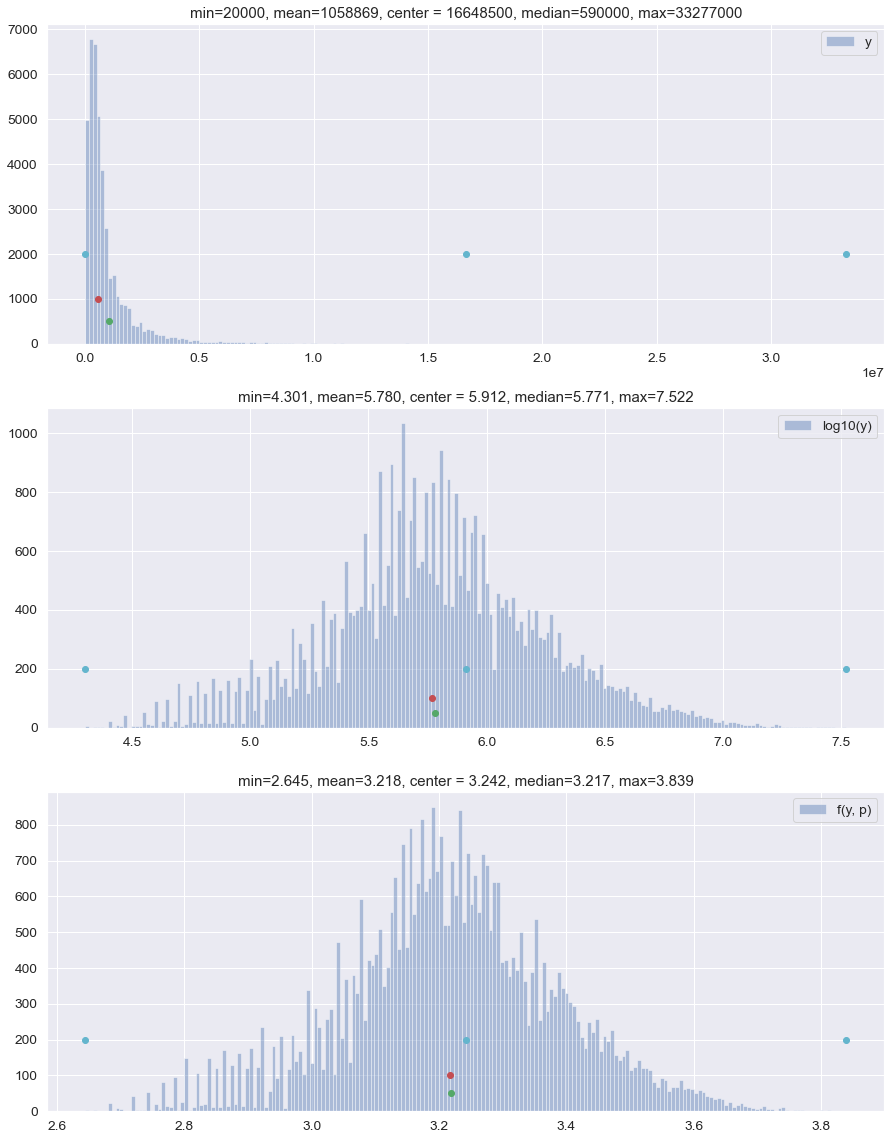

In [82]:
y = data_train1[target_name]

p = 1.5
z = target_transform(y, p)
s = target_transform_inv(z, p)


n_bins = 200

plt.subplots(3, 1, figsize=(15, 20))

plt.subplot(3, 1, 1)
level = 1000
sns.distplot(y, bins=n_bins, kde=False, label='y')
plt.plot(y.min(), 2*level, 'co')
plt.plot(y.mean(), level/2, 'go')
plt.plot(np.median(y), level, 'ro')
plt.plot(y.max(), 2*level, 'co')
plt.plot((y.max()+y.min())/2, 2*level, 'co')
plt.title("min={}, mean={:.0f}, center = {:.0f}, median={:.0f}, max={}"
          .format(y.min(), y.mean(), (y.max()+y.min())/2, np.median(y), y.max()))
plt.legend()
plt.xlabel('')

y_log = np.log10(y)

plt.subplot(3, 1, 2)
level = 100
sns.distplot(y_log, bins=n_bins, kde=False, label='log10(y)')
plt.plot(y_log.min(), 2*level, 'co')
plt.plot(y_log.mean(), level/2, 'go')
plt.plot(np.median(y_log), level, 'ro')
plt.plot((y_log.max()+y_log.min())/2, 2*level, 'co')
plt.plot(y_log.max(), 2*level, 'co')
plt.title("min={:.3f}, mean={:.3f}, center = {:.3f}, median={:.3f}, max={:.3f}"
          .format(y_log.min(), y_log.mean(), (y_log.max()+y_log.min())/2, np.median(y_log), y_log.max()))
plt.legend()
plt.xlabel('')

plt.subplot(3, 1, 3)
level = 100
sns.distplot(z, bins=n_bins, kde=False, label='f(y, p)')
plt.plot(z.min(), 2*level, 'co')
plt.plot(z.mean(), level/2, 'go')
plt.plot(np.median(z), level, 'ro')
plt.plot(z.max(), 2*level, 'co')
plt.plot((z.max()+z.min())/2, 2*level, 'co')
plt.title("min={:.3f}, mean={:.3f}, center = {:.3f}, median={:.3f}, max={:.3f}"
          .format(z.min(), z.mean(), (z.max()+z.min())/2, np.median(z), z.max()))
plt.legend()
plt.xlabel('')

print("The maximal relative error of target transformation =",
      ( np.abs( target_transform_inv(target_transform(y, p), p) - y )/y ).max())

## 5.3 Model optimizer

In [83]:
def model_one_coord_search(EstimatorClass, params_fixed, params_limits, 
                           data_trr, data_vall, target_name, n_sample, 
                           num_points=21, metrics_func=None,
                           lgb_categorical_feature_list='auto',
                           verbose=False, visualize=False):
    """
    This FUNCTION 
    - creates the model;
    - trains it with the train data;
    - makes the prediction from valid data;
    - calculate metrics and
    - measures the time of performance of all above actions.
    
    NOTE:
    ...
    ...LighnGBM (marked as 'lgb')
    
    INPUT:
    
    
    OUTPUT:
    
    Version 1.1
    Needs libraries:
    - pandas
    - numpy
    - scikit-learn
    - time
    
    """
    
    
    
    param_current = params_fixed.copy()

    data_tr = data_trr.copy()
    data_val = data_vall.copy()
    
    if n_sample < len(data_tr):        
        data_tr = data_tr.sample(n_sample, random_state=param_current['random_state'])
        
    ### target transformation
    ###
#     data_tr[target_name] = np.log10(data_tr[target_name])  ## log10-transformation
    data_tr[target_name] = target_transform(data_tr[target_name], POWER)
        
    feat_train = data_tr.drop([target_name], axis=1)
    targ_train = data_tr[target_name]
    
    feat_valid = data_val.drop([target_name], axis=1)
    targ_valid = data_val[target_name]
    
    
    for key in params_limits.keys():
        if params_limits[key][2] == 'int':
            param_range = np.linspace(params_limits[key][0], params_limits[key][1], num=num_points, dtype=int)
        else:
            param_range = np.linspace(params_limits[key][0], params_limits[key][1], num=num_points)
                        
        param_range = np.unique(param_range)
        
        metrics_list = []
        performance_list = []
        metrics_best = 10**10
        best_param = None
        
        for k, point in enumerate(param_range):
            param_current[key] = point
            
            ### ** - The best way to initialise estimator with the parameters
            ### would be to unpack dictionary
            if EstimatorClass != 'lgbm':
                t0 = time.time()
                model = EstimatorClass(**param_current)
                model.fit(feat_train, targ_train)
            else:
                # We should give LightGBM data converted to his own form 
                # Here data is pandas.DataFrame with catecorical data, label is target
                train_data = lgbm.Dataset(data_tr.drop([target_name], axis=1), label=data_tr[target_name], 
                                          categorical_feature=lgb_categorical_feature_list)
                t0 = time.time()
                model = lgbm.train(param_current, train_data)
                
            ### target inverse transformation
            ###
#             prediction = model.predict(feat_valid)
#             prediction_log10 = model.predict(feat_valid)
            prediction_transformed = model.predict(feat_valid)
            prediction = np.round(target_transform_inv(prediction_transformed, POWER)).astype(int)
        
            
            metrics = metrics_func(targ_valid, prediction)
            metrics_list.append(metrics)
            
            if metrics < metrics_best:
                metrics_best = metrics
                best_param = point
            
            performance_time = time.time() - t0
            performance_list.append(performance_time)
            
            if verbose:
                print("{} : {} = {:.6f} : METRICS = {:.4f} ; eval_time = {:.3f} sec"
                      .format( k, key, point, metrics, performance_time ))
        
        metrics_array = np.array(metrics_list)
        performance_array = np.array(performance_list)
        
        if visualize:
            fig, ax = plt.subplots(1, 1, figsize=(16, 8))
            
            plt.plot(best_param, metrics_best, 'o', markersize=14, 
                     markerfacecolor='w', markeredgecolor='r', label="best point")
            plt.plot(param_range, metrics_array, '-bo', label="")
            plt.legend()
            plt.title("The best metrics is {:.4f} for {}={}"
                      .format( metrics_best, key, best_param ))
        
    return metrics_array, param_range, performance_array, best_param, metrics_best

Test of `model_one_coord_search` (Stage 1)

In [84]:
# features_categorical

In [85]:
# EstimatorClass = 'lgbm'

# model_type = 'LGBM'

# ### fixed parameters

# try:
#     param_dict_fix
# except NameError:
#     pass
# else:
#     del param_dict_fix

# param_dict_fix = {}

# param_dict_fix['objective'] = OBJECTIVE
# # param_dict_fix['boosting_type'] = 'gbdt'
# param_dict_fix['random_state'] = RANDOM_STATE
# # param_dict_fix['silent'] = False
# param_dict_fix['free_raw_data'] = False

# param_dict_fix['n_estimators'] = 3495
# param_dict_fix['learning_rate'] = 0.0218
# param_dict_fix['num_leaves'] = 26
# param_dict_fix['min_data_in_leaf'] = 21
# param_dict_fix['max_depth'] = 16

# # param_dict_fix['max_depth'] = -1, ## no limit
# ### limit the max depth for tree model. This is used to deal with over-fitting when #data is small. Tree still grows leaf-wise
# ### <= 0 means no limit

# ### variable parameters

# params_lim = {}
# # params_lim['n_estimators'] = [2, 1000, 'int']
# # params_lim['learning_rate'] = [0.001, 2, 'float']
# params_lim['min_data_in_leaf'] = [11, 31, 'int']

In [86]:
# ### TEST OF ONE COORDINATE SEARCH

# result = model_one_coord_search(EstimatorClass, param_dict_fix, params_lim, 
#                                 data_train1, data_valid1, target_name, N_SAMPLE_BASE, 
#                                 metrics_func=mean_absolute_percent_error,
#                                 lgb_categorical_feature_list=CATEGORICAL_FEATURE_LIST_LGBM,  ## lgb_categorical_feature_list='auto',
#                                 verbose=True, visualize=True)

# metrics_array, param_range, performance_array, best_param, metrics_best = result

# print()
# print("metrics_array:", metrics_array)
# print()

# print("param_range:", param_range)
# print()

# print("performance_array:", performance_array)
# print()

# print("best_param =", best_param)
# print()

# print("metrics_best =", metrics_best)
# print()

In [87]:
def model_coord_search_loop(EstimatorClass, params_fixed, params_limits, 
                            data_tr, data_val, target_name, n_sample, 
                            num_points=21, metrics_func=None,
                            lgb_categorical_feature_list='auto',
                            verbose=False, visualize=False):
    
    
    param_current = params_fixed.copy()
    
    best_param_loop = {}
    metrics_best_loop = 10**10
    
    param_lim_1 = {}
    result_dict = {}
    for key in params_limits.keys():
        param_lim_1[key] = params_limits[key]
        if verbose:
            print()
            print("^^^")
            print("Fixed", param_current)
            print("Varies", param_lim_1)
            print("^^^\n")
        result = model_one_coord_search(EstimatorClass, param_current, param_lim_1, 
                                        data_tr, data_val, target_name, n_sample, 
                                        num_points=num_points, metrics_func=metrics_func,
                                        lgb_categorical_feature_list=lgb_categorical_feature_list,
                                        verbose=verbose, visualize=visualize)
        metrics_array, param_range, performance_array, best_param, metrics_best = result
        
        if best_param < metrics_best_loop:
            metrics_best_loop = best_param
        
        param_current[key] = best_param
        result_dict[key] = best_param
        param_lim_1 = {}
        
        if verbose:
            print()
            print("*** Best {} = {} witn METRICS = {}".format(key, best_param, metrics_best))
        
    return result_dict, metrics_best

Test of `model_coord_search_loop` (Stage 2)

In [88]:
# EstimatorClass = 'lgbm'

# model_type = 'LGBM'

# ### fixed parameters

# try:
#     param_dict_fix
# except NameError:
#     pass
# else:
#     del param_dict_fix

# param_dict_fix = {}

# param_dict_fix['objective'] = OBJECTIVE
# # param_dict_fix['boosting_type'] = 'gbdt'
# param_dict_fix['random_state'] = RANDOM_STATE
# # param_dict_fix['silent'] = False
# param_dict_fix['free_raw_data'] = False

# param_dict_fix['n_estimators'] = 3495
# param_dict_fix['learning_rate'] = 0.0218
# param_dict_fix['num_leaves'] = 26
# param_dict_fix['min_data_in_leaf'] = 21
# param_dict_fix['max_depth'] = 16
# # param_dict_fix['max_depth'] = -1, ## no limit
# ### limit the max depth for tree model. This is used to deal with over-fitting when #data is small. Tree still grows leaf-wise
# ### <= 0 means no limit





# ### variable parameters

# params_lim = {}
# params_lim['n_estimators'] = [2, 100, 'int']
# params_lim['max_depth'] = [2, 22, 'int']
# # params_lim['learning_rate'] = [0.001, 2.001, 'float']

In [89]:
# result = model_coord_search_loop(EstimatorClass, param_dict_fix, params_lim, 
#                                  data_train1, data_valid1, target_name, N_SAMPLE_BASE, 
#                                  metrics_func=mean_absolute_percent_error,
#                                  lgb_categorical_feature_list=CATEGORICAL_FEATURE_LIST_LGBM,  ## lgb_categorical_feature_list='auto',
#                                  verbose=True, visualize=True)

# result_dict, metrics_best = result

# print("***")
# print("*** result_dict :", result_dict)
# print("*** metrics_best =", metrics_best)
# print("***")

In [90]:
def model_coord_search(EstimatorClass, params_fixed, params_limits, 
                       data_tr, data_val, target_name, n_sample, 
                       num_points=21, metrics_func=None, tol=0.0001, iter_lim=100,
                       lgb_categorical_feature_list='auto',
                       verbose_cycle=False, verbose_detail=False, 
                       visualize_cycle=False, visualize_detail=False):
    
    """
    This fuction performs the search of the best parameters over specified parameter values 
    for an estimator using coordinate search.
    
    PARAMETERS:
        
    EstimatorClass - estimator object. 
        This is assumed to implement the scikit-learn estimator interface with `fit` and `predict` methods. 
        LightGBM is a special case - you should define EstimatorClass as a string 'lgbm' and
        `import lightgbm as lgbm` .
    
    params_fixed - dict. 
        Dictionary with parameters names (str) as keys and lists of parameter settings to try. 
        Such a list contains three elements: 
            First - the minimal limit for the parameter grid ('int' or 'float')
            Second - the maximal limit for the parameter grid ('int' or 'float')
            Third - the type of variable (str: 'int' or 'float'). The string which is not 'int' treated as 'float'.    
    
    params_limits - dict.
    
                       data_tr, data_val, target_name, n_sample, 
                       num_points=21, metrics_func=None, tol=0.0001, iter_lim=100,
                       lgb_categorical_feature_list='auto',
                       verbose_cycle=False, verbose_detail=False, 
                       visualize_cycle=False, visualize_detail=False
    """
    
    metrics_in = 10**10
    metrics_out = 10**9
    
    metrics_best = 10**10
    best_params = {}
    
    k = 0
    metrics_to_plot = []
    while metrics_in - metrics_out >= tol: 
        t0 = time.time()
        if verbose_cycle:
            print("[{}]".format(k))
            print("params_limits :", params_limits)
            
        metrics_in = metrics_out        
        result_dict, metrics_out = model_coord_search_loop(EstimatorClass, params_fixed, params_limits, 
                                                            data_tr, data_val, target_name, n_sample, 
                                                            num_points=num_points, metrics_func=metrics_func,
                                                            lgb_categorical_feature_list='auto',
                                                            verbose=verbose_detail, visualize=visualize_detail)
        if metrics_out < metrics_best:
            metrics_best = metrics_out
            best_params = result_dict
        
        
        metrics_to_plot.append(metrics_out)
        
        for key in params_limits.keys():
            step_key = ( params_limits[key][1] - params_limits[key][0] ) / ( num_points - 1 )
            if params_limits[key][2] == 'int':
                step_key = int(np.ceil(step_key))
                
            lim_min = result_dict[key] - step_key
            if lim_min < params_limits[key][0]:
                lim_min = params_limits[key][0]
            lim_max = result_dict[key] + step_key
            params_limits[key] = [ lim_min, lim_max, params_limits[key][2] ]
            
        
        if verbose_cycle:
            print("OUT [{}]: M(i) = {:.6f}; M(i+1) = {:.6f} (tol={})"
                  .format(k, metrics_in, metrics_out, tol))
            print("result_dict", result_dict)
            print("Iteration time = {:.2f} sec".format( time.time() - t0 ))
            print("\n", "~ "*9, "\n")
        k += 1
        if k > iter_lim:
            print("The limit of iterations is achieved. Sorry!")
            break
            
    print(min(metrics_to_plot))
    if visualize_cycle:        
        shift = 0.03*(max(metrics_to_plot) - min(metrics_to_plot))
        x = np.arange(0, len(metrics_to_plot))
        
        fig, ax = plt.subplots(1, 1, figsize=(16, 8))
        plt.plot(x, metrics_to_plot, '-bo')
        plt.xlabel("Iteration", fontsize=14)
        plt.ylabel("Metrics", fontsize=14)
        for a, b in zip(x, metrics_to_plot): 
            plt.text(a, b+shift, str( np.round(b, 4)), fontsize=12)
        plt.show()
    
    print()
    print("Done. Congratulations!")
    
    return best_params, metrics_best

# 6 Optimization of base models

## 6.1 LightGBM with default parameters

In [91]:
param_current = {}

data_tr_unopt = data_train1.copy()
data_val_unopt = data_valid1.copy()

# data_tr_unopt[target_name] = np.log10(data_tr_unopt[target_name])
# data_val_unopt[target_name] = np.log10(data_val_unopt[target_name])
data_tr_unopt[target_name] = target_transform(data_tr_unopt[target_name], POWER)
data_val_unopt[target_name] = target_transform(data_val_unopt[target_name], POWER)

train_data = lgbm.Dataset(data_tr_unopt.drop([target_name], axis=1), label=data_tr_unopt[target_name])

model = lgbm.train(param_current, train_data)
# prediction = model.predict(data_val_unopt.drop([target_name], axis=1))
# prediction_log10 = model.predict(data_val_unopt.drop([target_name], axis=1))
# prediction = 10**prediction_log10
prediction_transformed = model.predict(data_val_unopt.drop([target_name], axis=1))
prediction = np.round(target_transform_inv(prediction_transformed, POWER)).astype(int)

mape_unoptimized = mean_absolute_percent_error(data_valid1[target_name], prediction)

print("We have MAPE={:.4f} for unoptimized model.".format(mape_unoptimized))

We have MAPE=13.9246 for unoptimized model.


<div class="alert alert-block alert-success">
<div style="border:solid green 2px; padding: 20px"> <h2 style="color:green; margin-bottom:20px">
6.2 Optimization of base models (*LGBMRegressor*)</h2>

</div>

- [Basic info](https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMRegressor.html#lightgbm.LGBMRegressor)

In [92]:
EstimatorClass = 'lgbm'

model_type = 'LGBM'

### fixed parameters

try:
    param_dict_fix
except NameError:
    pass
else:
    del param_dict_fix

param_dict_fix = {}

param_dict_fix['objective'] = OBJECTIVE
# param_dict_fix['boosting_type'] = 'gbdt'
param_dict_fix['random_state'] = RANDOM_STATE
# param_dict_fix['silent'] = False
param_dict_fix['free_raw_data'] = False

param_dict_fix['n_estimators'] = 2988
param_dict_fix['learning_rate'] = 0.0239
# param_dict_fix['num_leaves'] = 26
# param_dict_fix['min_data_in_leaf'] = 21
param_dict_fix['max_depth'] = 8
# param_dict_fix['max_depth'] = -1, ## no limit
### limit the max depth for tree model. This is used to deal with over-fitting when #data is small. Tree still grows leaf-wise
### <= 0 means no limit





### variable parameters

params_lim = {}

params_lim['n_estimators'] = [2987, 2989, 'int']
params_lim['learning_rate'] = [0.013, 0.033, 'float']
params_lim['max_depth'] = [8, 10, 'int']
# params_lim['num_leaves'] = [2, 127, 'int']
# params_lim['min_data_in_leaf'] = [2, 1002, 'int']

[0]
params_limits : {'n_estimators': [2987, 2989, 'int'], 'learning_rate': [0.013, 0.033, 'float'], 'max_depth': [8, 10, 'int']}


C:\Users\DNS\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


OUT [0]: M(i) = 1000000000.000000; M(i+1) = 13.163932 (tol=0.0001)
result_dict {'n_estimators': 2987, 'learning_rate': 0.023, 'max_depth': 9}
Iteration time = 384.52 sec

 ~ ~ ~ ~ ~ ~ ~ ~ ~  

[1]
params_limits : {'n_estimators': [2987, 2988, 'int'], 'learning_rate': [0.022, 0.024, 'float'], 'max_depth': [8, 10, 'int']}
OUT [1]: M(i) = 13.163932; M(i+1) = 13.145399 (tol=0.0001)
result_dict {'n_estimators': 2987, 'learning_rate': 0.0239, 'max_depth': 8}
Iteration time = 369.46 sec

 ~ ~ ~ ~ ~ ~ ~ ~ ~  

[2]
params_limits : {'n_estimators': [2987, 2988, 'int'], 'learning_rate': [0.0238, 0.024, 'float'], 'max_depth': [8, 9, 'int']}
OUT [2]: M(i) = 13.145399; M(i+1) = 13.145399 (tol=0.0001)
result_dict {'n_estimators': 2987, 'learning_rate': 0.0239, 'max_depth': 8}
Iteration time = 358.60 sec

 ~ ~ ~ ~ ~ ~ ~ ~ ~  

13.145399463883734


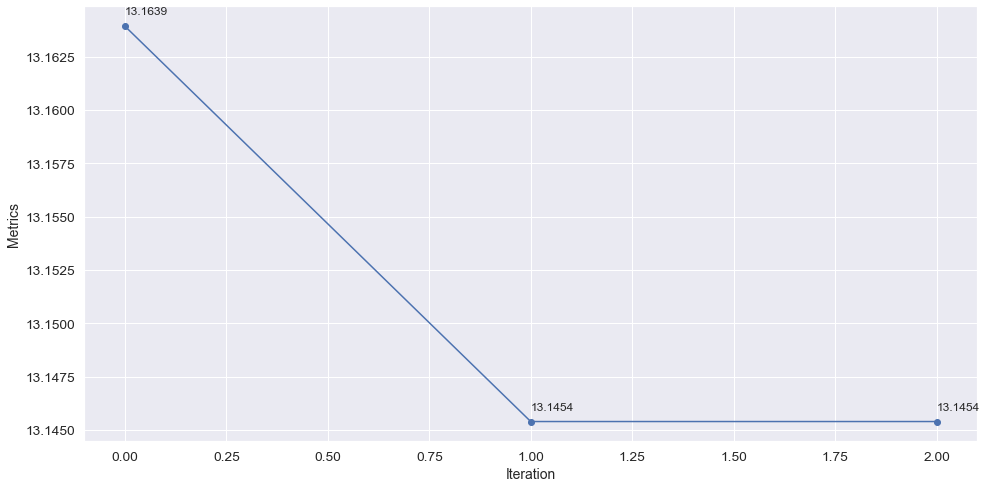


Done. Congratulations!
[***] This is Houston. The MET is : 0:19:31.636    (H:MM:SS)
==== ==== ==== ==== ==== 
The parameters of the best base model are:  {'n_estimators': 2987, 'learning_rate': 0.0239, 'max_depth': 8}
The best base model has MAPE=13.1454
Wall time: 18min 33s


In [93]:
%%time

result = model_coord_search(EstimatorClass, param_dict_fix, params_lim, 
                            data_train1, data_valid1, target_name, N_SAMPLE_BASE, 
                            num_points=21,
                            metrics_func=mean_absolute_percent_error, tol=0.0001, iter_lim=100, 
                            lgb_categorical_feature_list=CATEGORICAL_FEATURE_LIST_LGBM,  ## lgb_categorical_feature_list='auto',
                            verbose_cycle=True, verbose_detail=False, 
                            visualize_cycle=True, visualize_detail=False)

result_dict, metrics_out = result

running_time(time.time(), total_time_start)

print("==== "*5)
print("The parameters of the best base model are: ", result_dict)
print("The best base model has MAPE={:.4f}".format(metrics_out))

In [94]:
best_model_1_mape = metrics_out
best_parameters = result_dict
print("The best parameters for the base model are: ", best_parameters)
print("We have the MAPE = {:.4f} for the best base model. ".format(best_model_1_mape))

The best parameters for the base model are:  {'n_estimators': 2987, 'learning_rate': 0.0239, 'max_depth': 8}
We have the MAPE = 13.1454 for the best base model. 


## 6.3 Collection of nearly best base models for meta-phase

In [95]:
def model_collector(EstimatorClass, params_fixed, params_opt, 
                    data_trr, data_vall, target_name, n_sample,
                    metrics_func=None,
                    lgb_categorical_feature_list='auto'):
    
    """
    """
    
    
    import itertools
    
    data_tr = data_trr.copy()
    data_val = data_vall.copy()
    
    try:
        rs = params_fixed['random_state']
    except:
        rs = None
    
    
    if n_sample < len(data_tr):        
        data_tr = data_tr.sample(n_sample, random_state=rs)
    

    
    ### target transformation
    ###
#     data_tr[target_name] = np.log10(data_tr[target_name])  ## log10-transformation
    data_tr[target_name] = target_transform(data_tr[target_name], POWER)
    
    feat_train = data_tr.drop([target_name], axis=1)
    targ_train = data_tr[target_name]
        
    feat_valid = data_val.drop([target_name], axis=1)
    targ_valid = data_val[target_name]
    
    result_df = pd.DataFrame( columns=list(params_opt.keys())+["metrics", "performance_time", "model"] )
    print(list(result_df.columns))
    
    keys, values = zip(*params_opt.items())
    ## list of dicts
    permutations_dicts = [dict(zip(keys, v)) for v in itertools.product(*values)]
    
    for k, dict_point in enumerate(permutations_dicts):
        param_current = {**params_fixed, **dict_point}
        
        if EstimatorClass != 'lgbm':
            t0 = time.time()
            model = EstimatorClass(**param_current)
            model.fit(feat_train, targ_train)
        else:
            # We should give LightGBM data converted to his own form 
            # Here data is pandas.DataFrame with catecorical data, label is target
            train_data = lgbm.Dataset(data_tr.drop([target_name], axis=1), label=data_tr[target_name], 
                                      categorical_feature=lgb_categorical_feature_list)
            t0 = time.time()
            model = lgbm.train(param_current, train_data)
                
#         prediction = model.predict(feat_valid)
        prediction_transformed = model.predict(feat_valid)
        prediction = np.round(target_transform_inv(prediction_transformed, POWER)).astype(int)
        
        metrics = metrics_func(targ_valid, prediction)
        
        performance_time = time.time() - t0
        
        list_to_append = list( dict_point.values() ) + [metrics, performance_time, model]
        print(list_to_append)
        result_df = result_df.append(pd.DataFrame([list_to_append], columns=result_df.columns), ignore_index=True)
        
    result_df = result_df.sort_values('metrics', ascending=True).reset_index(drop=True)
        
    return result_df

In [96]:
N_grid = 3

In [97]:
EstimatorClass = 'lgbm'

model_type = 'LGBM'

### fixed parameters

try:
    param_dict_fix
except NameError:
    pass
else:
    del param_dict_fix

param_dict_fix = {}

param_dict_fix['objective'] = OBJECTIVE
# param_dict_fix['boosting_type'] = 'gbdt'
# param_dict_fix['random_state'] = RANDOM_STATE
# param_dict_fix['silent'] = False
param_dict_fix['free_raw_data'] = False

param_dict_fix['n_estimators'] = 2988
param_dict_fix['learning_rate'] =  np.round(best_parameters['learning_rate'], 9)  ## 0.023
# param_dict_fix['num_leaves'] = 26
# param_dict_fix['min_data_in_leaf'] = 21
param_dict_fix['max_depth'] = 9


# param_dict_fix['max_depth'] = -1, ## no limit
# param_dict_fix['n_estimators'] = 100
# param_dict_fix['learning_rate'] = 0.01



### best optimised parameters

n_es_0 = best_parameters['n_estimators']
md_0 = best_parameters['max_depth']
# lr_0 = np.round(best_parameters['learning_rate'], 9)
# n_l_0 = best_parameters['num_leaves']
# mdil_0 = best_parameters['min_data_in_leaf']

params_optim = {}

params_optim['n_estimators'] = np.linspace( max( [2, n_es_0-STEP_INT*(N_grid-1)/2] ),
                                           max( [2, n_es_0-STEP_INT*(N_grid-1)/2] ) + STEP_INT*(N_grid-1), 
                                           num=N_grid, dtype='int' )
params_optim['max_depth'] = np.linspace( max( [2, md_0-STEP_INT*(N_grid-1)/2] ), 
                                        max( [2, md_0-STEP_INT*(N_grid-1)/2] ) + STEP_INT*(N_grid-1),
                                        num = N_grid, dtype='int'  )

# params_optim['n_estimators'] = [max([2, n_es_0-STEP_INT]), n_es_0-STEP_INT,
#                                 n_es_0, n_es_0+STEP_INT, n_es_0+STEP_INT ]
# params_optim['max_depth'] = [ max([2, md_0-STEP_INT]), md_0, md_0+STEP_INT, md_0+2*STEP_INT, md_0+3*STEP_INT ]

# params_optim['n_estimators'] = [max([2, n_es_0-100*STEP_INT]), n_es_0, n_es_0+100*STEP_INT ]
# params_optim['max_depth'] = [ max([2, md_0-STEP_INT]), md_0, md_0+STEP_INT ]

# params_optim['num_leaves'] = [max([2, n_l_0-STEP_INT]), n_l_0, n_l_0+STEP_INT ]
# params_optim['min_data_in_leaf'] = [max([2, mdil_0-STEP_INT]), mdil_0, mdil_0+STEP_INT ]
# params_optim['learning_rate'] = [ max(0.0001, np.round(lr_0-STEP_LR, 9)), lr_0, np.round(lr_0+STEP_LR, 9) ]

# params_optim = {}
# params_optim['n_estimators'] = [1482, 1483, 1484] ##2264
# params_optim['max_depth'] = [10, 11, 12] ## 12
# params_optim['learning_rate'] = [0.067, 0.068, 0.069] ## 0.099

params_optim

{'n_estimators': array([2986, 2987, 2988]), 'max_depth': array([7, 8, 9])}

In [98]:
%%time
base_model_storage =  model_collector(EstimatorClass, param_dict_fix, params_optim, 
                          data_train1, data_valid1, target_name, N_SAMPLE_BASE, 
                          metrics_func=mean_absolute_percent_error,
                          lgb_categorical_feature_list=CATEGORICAL_FEATURE_LIST_LGBM)  ## lgb_categorical_feature_list='auto',)

running_time(time.time(), total_time_start)

['n_estimators', 'max_depth', 'metrics', 'performance_time', 'model']


C:\Users\DNS\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[2986, 7, 13.18962028080189, 13.922725915908813, <lightgbm.basic.Booster object at 0x000001E7809C0C88>]
[2986, 8, 13.145605338131663, 14.442665338516235, <lightgbm.basic.Booster object at 0x000001E78063CAC8>]
[2986, 9, 13.145887896390477, 14.193186521530151, <lightgbm.basic.Booster object at 0x000001E78020A248>]
[2987, 7, 13.189562770212406, 14.29543662071228, <lightgbm.basic.Booster object at 0x000001E781A0D608>]
[2987, 8, 13.145399463883734, 15.280310869216919, <lightgbm.basic.Booster object at 0x000001E78065FE08>]
[2987, 9, 13.146071381146715, 14.308709621429443, <lightgbm.basic.Booster object at 0x000001E780BF9B88>]
[2988, 7, 13.189710921783915, 14.221455097198486, <lightgbm.basic.Booster object at 0x000001E7805B6308>]
[2988, 8, 13.14523297713895, 15.183013200759888, <lightgbm.basic.Booster object at 0x000001E781A6B808>]
[2988, 9, 13.145902138050339, 13.66415548324585, <lightgbm.basic.Booster object at 0x000001E7808AA3C8>]
[***] This is Houston. The MET is : 0:21:41.396    (H:MM:SS

In [99]:
base_model_storage = base_model_storage[ -base_model_storage['metrics'].duplicated() ]
base_model_storage.reset_index(inplace=True)
base_model_storage

index n_estimators max_depth    metrics  performance_time  \
0      0         2988         8  13.145233         15.183013   
1      1         2987         8  13.145399         15.280311   
2      2         2986         8  13.145605         14.442665   
3      3         2986         9  13.145888         14.193187   
4      4         2988         9  13.145902         13.664155   
5      5         2987         9  13.146071         14.308710   
6      6         2987         7  13.189563         14.295437   
7      7         2986         7  13.189620         13.922726   
8      8         2988         7  13.189711         14.221455   

                                               model  
0  <lightgbm.basic.Booster object at 0x000001E781...  
1  <lightgbm.basic.Booster object at 0x000001E780...  
2  <lightgbm.basic.Booster object at 0x000001E780...  
3  <lightgbm.basic.Booster object at 0x000001E780...  
4  <lightgbm.basic.Booster object at 0x000001E780...  
5  <lightgbm.basic.Booster object at 0x000001E780...  
6  <lightgbm.basic.Booster object at 0x000001E781...  
7  <lightgbm.basic.Booster object at 0x000001E780...  
8  <lightgbm.basic.Booster object at 0x000001E780...

## 6.4 About the best base model. Feature importance.

In [100]:
best_base_model = base_model_storage.loc[0, "model"]
print("Best base model demonstrates MAPE = {:.4f} with 'valid1' sample."
      .format(base_model_storage.loc[0, "metrics"]))

Best base model demonstrates MAPE = 13.1452 with 'valid1' sample.


In [101]:
# print(best_base_model.feature_importance().shape)

features_importances_best_base_model = pd.DataFrame(
    data=100*best_base_model.feature_importance()/best_base_model.feature_importance().sum(), 
    index=data_train1.drop([target_name], axis=1).columns, columns=['Importance_(%)'])

features_importances_best_base_model = features_importances_best_base_model.sort_values(by='Importance_(%)', 
                                                                                        ascending=False)
# print(best_base_model.feature_importance())
features_importances_best_base_model.head(20)

Importance_(%)
mileage                          20.731338
year                             17.049978
model                            14.049272
power                            11.316566
displacement                      8.405566
mark                              5.038182
color                             4.966416
owners                            2.054295
gear_type                         1.652855
doors_count                       1.634914
transmission                      1.473441
body_type                         1.030512
abs                               0.947532
engine_type                       0.846612
computer                          0.565155
airbag-driver                     0.505724
cruise-control                    0.454143
condition                         0.418260
automatic-lighting-control        0.394712
navigation                        0.382377

In [102]:
z = features_importances_best_base_model[(features_importances_best_base_model['Importance_(%)'] != 0) & 
                                         (features_importances_best_base_model['Importance_(%)'].notna())].values.flatten()
y = np.log(z)
x = np.arange(0, len(y))

p = np.polyfit(x, y, 1)
length = float(-1/p[0])
feature_deficiency = 1/( np.exp(len(y)/length) - 1  )

print("The 'exponential decay length' is {:.2f} 'features'.".format( length ))
print("A lack od features is about {:.1%}.".format(float(feature_deficiency)))
# print("\n If you see 'nan', it means that at least one of feature has a zero-importance.")

real_importance = np.exp( np.polyval(p, x) )

The 'exponential decay length' is 9.72 'features'.
A lack od features is about 0.4%.


In [103]:
feature_deficient = 0.01
print("We need {} instead of {} now for feature sufficiency of {:.1%}, while now we have {:.1%}."
      .format( int(np.ceil( -length*np.log(feature_deficiency) )), len(x), 
              1-feature_deficient, 1-feature_deficiency ))

We need 54 instead of 54 now for feature sufficiency of 99.0%, while now we have 99.6%.


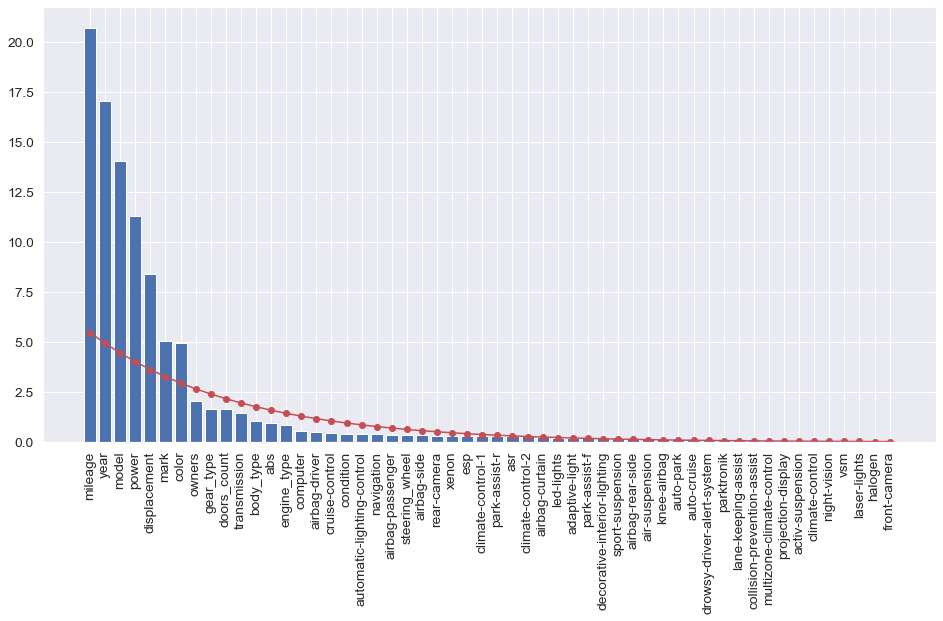

In [104]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))

plt.bar(x, z)
plt.plot(x, real_importance, '-ro')
plt.xticks(x, features_importances_best_base_model.index, rotation=90)

plt.show()

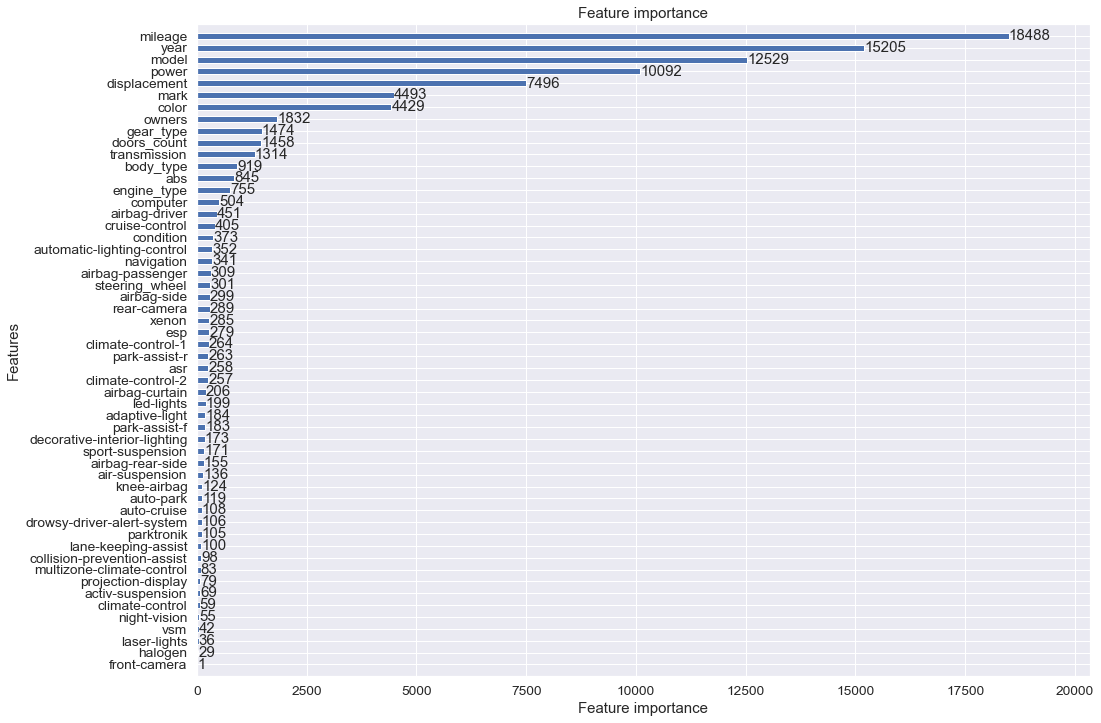

In [105]:
lgbm.plot_importance(best_base_model, height=0.5,  figsize=(16, 12))

The range of prediction for Model No. 0 are: [28316.0, 26548085.0] with the width of 26519769.0
The range of prediction for Model No. 1 are: [28378.0, 26547562.0] with the width of 26519184.0
The range of prediction for Model No. 2 are: [28378.0, 26547472.0] with the width of 26519094.0


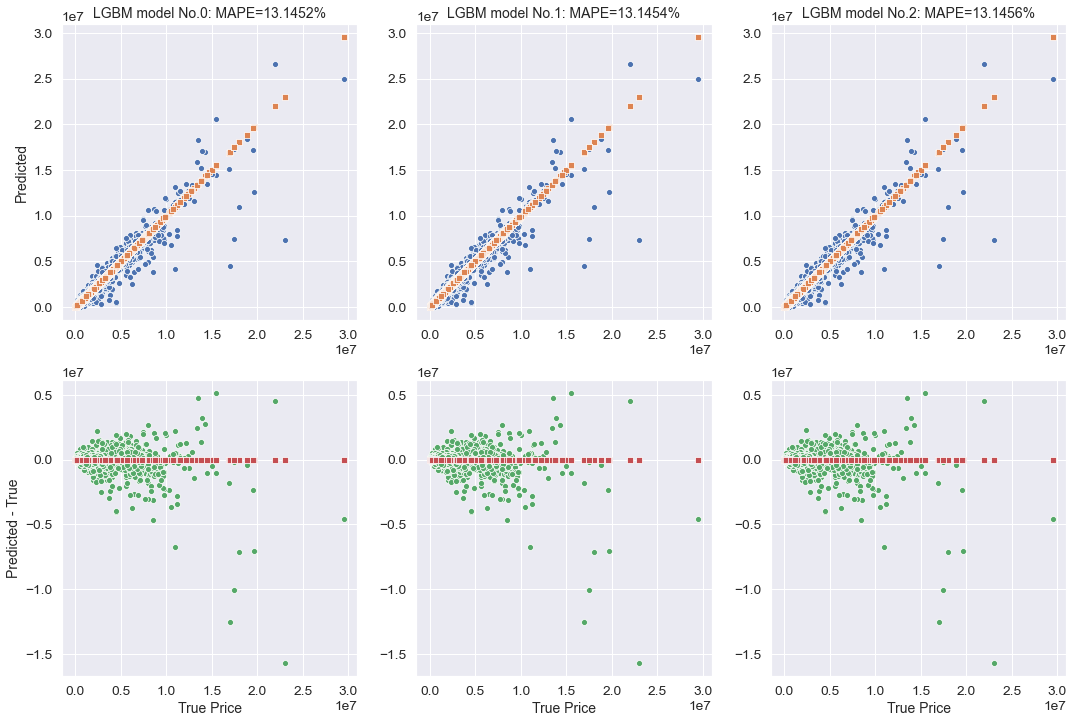

In [106]:
df = base_model_storage


n = min(3, len(df))

fig, axes = plt.subplots(2, n, figsize=(6*n, 12) )

for i in range(n):
    model = df.loc[i, "model"]
#     prediction = model.predict(data_valid1.drop([target_name], axis=1))
#     prediction_log10 = model.predict(data_valid1.drop([target_name], axis=1))
#     prediction = 10**prediction_log10
    prediction_transformed = model.predict(data_valid1.drop([target_name], axis=1))
    prediction = np.round(target_transform_inv(prediction_transformed, POWER)).astype(int)
    print("The range of prediction for Model No. {} are: [{:.1f}, {:.1f}] with the width of {:.1f}"
          .format( i, prediction.min(), prediction.max(), prediction.max()-prediction.min() ))
    
    plt.subplot(2, n, i+1)
    sns.scatterplot(data_valid1[target_name], prediction)
    sns.scatterplot(data_valid1[target_name], data_valid1[target_name], marker='s')
    plt.title("LGBM model No.{}: MAPE={:.4f}%".format(i, df.loc[i, "metrics"]), fontsize=FONT_SIZE)
    plt.xlabel("", fontsize=FONT_SIZE)
    if i == 0:
        plt.ylabel("Predicted", fontsize=FONT_SIZE)
    else:
        plt.ylabel("", fontsize=FONT_SIZE)
        
    plt.subplot(2, n, n+i+1)
    sns.scatterplot(data_valid1[target_name], prediction - data_valid1[target_name], color='g')
    sns.scatterplot(data_valid1[target_name], data_valid1[target_name] - data_valid1[target_name], marker='s', color='r')
    plt.xlabel("True Price", fontsize=FONT_SIZE)
    if i == 0:
        plt.ylabel("Predicted - True", fontsize=FONT_SIZE)
    else:
        plt.ylabel("", fontsize=FONT_SIZE)
        
plt.show()

## 6.5 Averaged over $\sqrt{N}$ and $N$ best models prediction (*LGBMRegressor*)

Text(0, 0.5, 'Predicted - True')

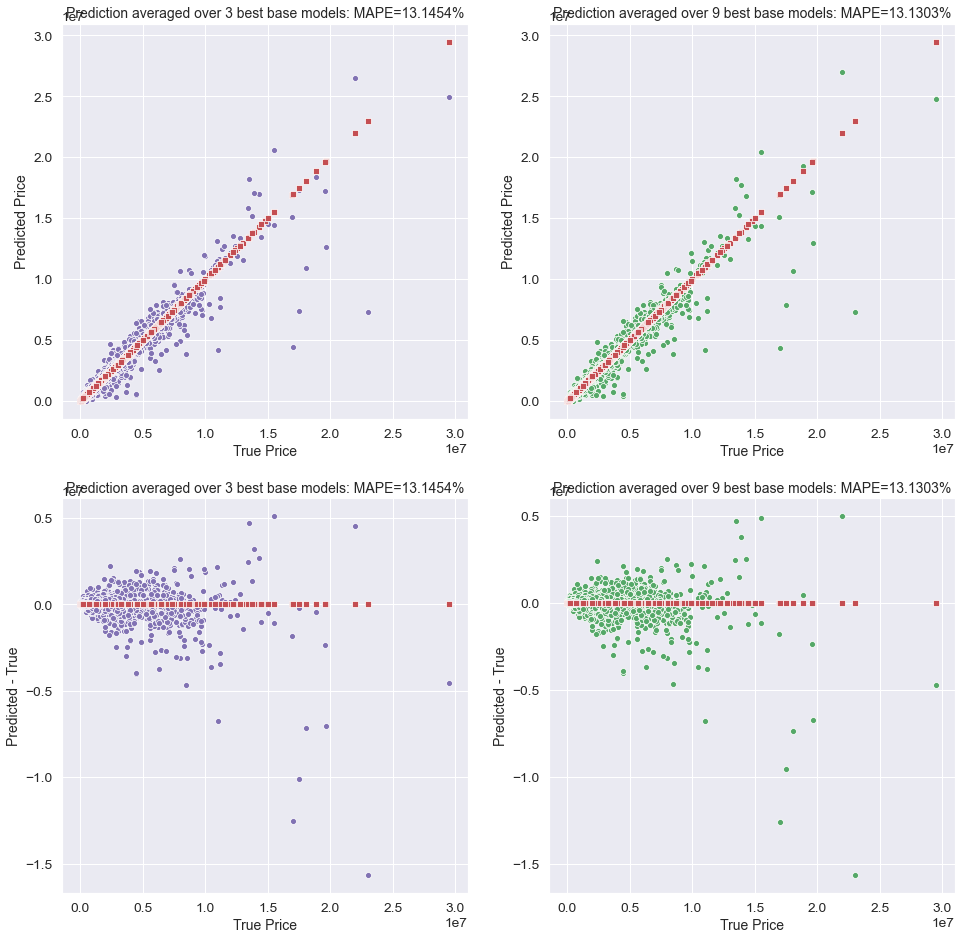

In [107]:
df = base_model_storage

fig, axes = plt.subplots(2, 2, figsize=(16, 16))



### SQRT

n_models = int(np.sqrt(len(df)))

predictions = []

for model in df.loc[:n_models-1, "model"]:
#     prediction = model.predict(data_valid1.drop([target_name], axis=1))
#     prediction_log10 = model.predict(data_valid1.drop([target_name], axis=1))
#     prediction = 10**prediction_log10
    prediction_transformed = model.predict(data_valid1.drop([target_name], axis=1))
    prediction = np.round(target_transform_inv(prediction_transformed, POWER)).astype(int)
    predictions.append(prediction)
    
predictions = np.array(predictions)
mean_prediction_sqrt = predictions.mean(axis=0)
mape_of_mean_sqrt = mean_absolute_percent_error(data_valid1[target_name], mean_prediction_sqrt)


plt.subplot(2, 2, 1)
sns.scatterplot(data_valid1[target_name], mean_prediction_sqrt, marker='o', color='m')
sns.scatterplot(data_valid1[target_name], data_valid1[target_name], marker='s', color='r')
plt.title("Prediction averaged over {} best base models: MAPE={:.4f}%"
          .format(n_models, mape_of_mean_sqrt), fontsize=FONT_SIZE)
plt.xlabel("True Price", fontsize=FONT_SIZE)
plt.ylabel("Predicted Price", fontsize=FONT_SIZE)


plt.subplot(2, 2, 3)
sns.scatterplot(data_valid1[target_name], mean_prediction_sqrt - data_valid1[target_name], marker='o', color='m')
sns.scatterplot(data_valid1[target_name], data_valid1[target_name] - data_valid1[target_name], marker='s', color='r')

plt.title("Prediction averaged over {} best base models: MAPE={:.4f}%"
          .format(n_models, mape_of_mean_sqrt), fontsize=FONT_SIZE)
plt.xlabel("True Price", fontsize=FONT_SIZE)
plt.ylabel("Predicted - True", fontsize=FONT_SIZE)



### ALL

n_models = len(df)

predictions = []
for model in df.loc[:n_models-1, "model"]:
#     prediction = model.predict(data_valid1.drop([target_name], axis=1))
#     prediction_log10 = model.predict(data_valid1.drop([target_name], axis=1))
#     prediction = 10**prediction_log10
    prediction_transformed = model.predict(data_valid1.drop([target_name], axis=1))
    prediction = np.round(target_transform_inv(prediction_transformed, POWER)).astype(int)
    predictions.append(prediction)
    
predictions = np.array(predictions)
mean_prediction_all = predictions.mean(axis=0)
mape_of_mean_all = mean_absolute_percent_error(data_valid1[target_name], mean_prediction_all)


plt.subplot(2, 2, 2)
sns.scatterplot(data_valid1[target_name], mean_prediction_all, marker='o', color='g')
sns.scatterplot(data_valid1[target_name], data_valid1[target_name], marker='s', color='r')
plt.title("Prediction averaged over {} best base models: MAPE={:.4f}%"
          .format(n_models, mape_of_mean_all), fontsize=FONT_SIZE)
plt.xlabel("True Price", fontsize=FONT_SIZE)
plt.ylabel("Predicted Price", fontsize=FONT_SIZE)


plt.subplot(2, 2, 4)
sns.scatterplot(data_valid1[target_name], mean_prediction_all - data_valid1[target_name], marker='o', color='g')
sns.scatterplot(data_valid1[target_name], data_valid1[target_name] - data_valid1[target_name], marker='s', color='r')

plt.title("Prediction averaged over {} best base models: MAPE={:.4f}%"
          .format(n_models, mape_of_mean_all), fontsize=FONT_SIZE)
plt.xlabel("True Price", fontsize=FONT_SIZE)
plt.ylabel("Predicted - True", fontsize=FONT_SIZE)

In [108]:
running_time(time.time(), total_time_start)

[***] This is Houston. The MET is : 0:22:28.201    (H:MM:SS)


<div class="alert alert-block alert-danger">
<div style="border:solid red 2px; padding: 20px"> <h1 style="color:red; margin-bottom:20px">
7 STACKING</h1>

</div>

In [109]:
target_train_2 = data_train2[target_name].reset_index(drop=True)
target_valid_2 = data_valid2[target_name].reset_index(drop=True)

In [110]:
%%time

predictions_train_type = []
predictions_valid_type = []
predictions_train = []
predictions_valid = []

features_train_2 = data_train2.drop([target_name], axis=1)
features_valid_2 = data_valid2.drop([target_name], axis=1)


for k, model in enumerate(base_model_storage['model']):
    t0 = time.time()
#     prediction = model.predict(features_train_2)
#     prediction_log10 = model.predict(features_train_2)
#     prediction = 10**prediction_log10
    prediction_transformed = model.predict(features_train_2)
    prediction = np.round(target_transform_inv(prediction_transformed, POWER)).astype(int)
    predictions_train.append(prediction)
    
#     prediction = model.predict(features_valid_2)
#     prediction_log10 = model.predict(features_valid_2)
#     prediction = 10**prediction_log10
    prediction_transformed = model.predict(features_valid_2)
    prediction = np.round(target_transform_inv(prediction_transformed, POWER)).astype(int)
    predictions_valid.append(prediction)
    print("[{}/{}] : {:.2f} sec".format( k+1, len(base_model_storage), time.time()-t0 ))

data_meta_train = pd.DataFrame(predictions_train).T
data_meta_valid = pd.DataFrame(predictions_valid).T


###  Aceraged prediction

averaged_meta_prediction_train = data_meta_train.mean(axis=1)
data_meta_train['Averaged'] = averaged_meta_prediction_train

averaged_meta_prediction_valid = data_meta_valid.mean(axis=1)
data_meta_valid['Averaged'] = averaged_meta_prediction_valid

data_meta_train[target_name] = target_train_2
data_meta_valid[target_name] = target_valid_2

print(data_meta_train.shape, target_train_2.shape, data_meta_valid.shape, target_valid_2.shape)
running_time(time.time(), total_time_start)

[1/9] : 10.25 sec
[2/9] : 10.12 sec
[3/9] : 9.88 sec
[4/9] : 10.04 sec
[5/9] : 9.91 sec
[6/9] : 9.62 sec
[7/9] : 10.64 sec
[8/9] : 12.17 sec
[9/9] : 10.65 sec
(41453, 11) (41453,) (13818, 11) (13818,)
[***] This is Houston. The MET is : 0:24:06.736    (H:MM:SS)
Wall time: 1min 38s


In [111]:
print("Number of meta-features :", data_meta_valid.shape[1]-1)
data_meta_valid

Number of meta-features : 10


0        1        2        3        4        5        6        7  \
0       431877   431879   431878   431473   431461   431470   435146   435149   
1       329905   329907   329906   331477   331475   331481   327194   327196   
2       315582   315573   315616   314140   314141   314144   315496   315495   
3       386537   386539   386535   381666   381332   381663   377969   377968   
4       433090   433093   433092   427165   427159   427161   436343   436346   
...        ...      ...      ...      ...      ...      ...      ...      ...   
13813  2926659  2926329  2926320  2953741  2953750  2953779  2931055  2931049   
13814   607306   607310   607308   612127   612180   612122   610733   610737   
13815   795103   795108   795105   795705   795774   795698   793908   793913   
13816   108184   108181   108062   106947   106944   106946   116979   116980   
13817    55822    55822    55822    62747    62746    62747    64183    64177   

             8      Averaged    price  
0       435153  4.328318e+05   465000  
1       327184  3.295250e+05   290000  
2       315486  3.150748e+05   309000  
3       377974  3.820203e+05   370000  
4       436330  4.321977e+05   540000  
...        ...           ...      ...  
13813  2931344  2.937114e+06  2645000  
13814   610714  6.100597e+05   475000  
13815   793883  7.949108e+05   820000  
13816   116981  1.106893e+05   180000  
13817    64184  6.091667e+04   110000  

[13818 rows x 11 columns]

<div class="alert alert-block alert-danger">
<div style="border:solid red 2px; padding: 20px"> <h2 style="color:red; margin-bottom:20px">
7.1 BLENDING</h2>

</div>

### 7.1.1 Average prediction (Bagging)

In [112]:
mape_averaged_meta_valid = mean_absolute_percent_error(data_meta_valid[target_name], data_meta_valid['Averaged'])
print("We have MAPE={:.4f} for the prediction which is averaged over all meta-predictions".format(mape_averaged_meta_valid))

We have MAPE=13.2659 for the prediction which is averaged over all meta-predictions


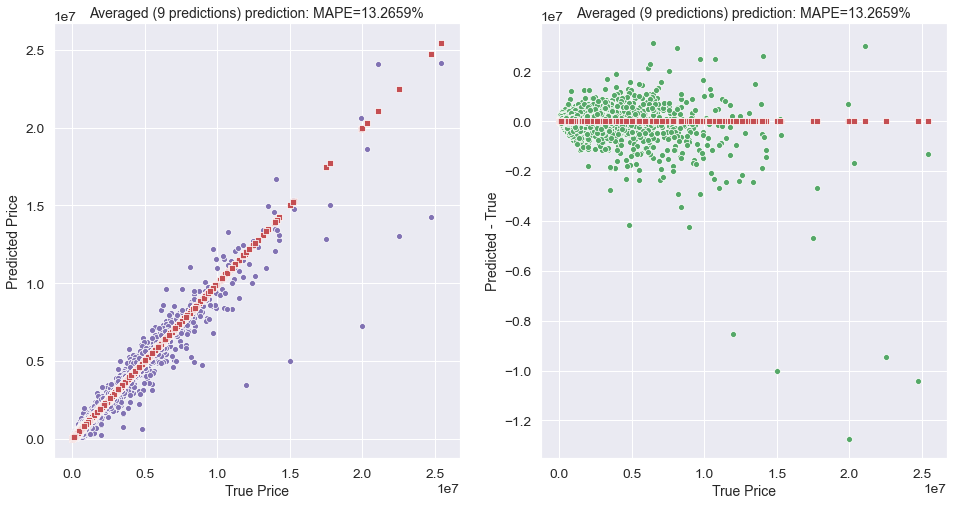

In [113]:
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

plt.subplot(1, 2, 1)
sns.scatterplot(data_meta_valid[target_name], data_meta_valid['Averaged'], marker='o', color='m')
sns.scatterplot(data_meta_valid[target_name], data_meta_valid[target_name], marker='s', color='r')

plt.title("Averaged ({} predictions) prediction: MAPE={:.4f}%"
          .format(data_meta_valid.shape[1]-2, mape_averaged_meta_valid), fontsize=FONT_SIZE)
plt.xlabel("True Price", fontsize=FONT_SIZE)
plt.ylabel("Predicted Price", fontsize=FONT_SIZE)


plt.subplot(1, 2, 2)
sns.scatterplot(data_meta_valid[target_name], data_meta_valid['Averaged']-data_meta_valid[target_name], marker='o', color='g')
sns.scatterplot(data_meta_valid[target_name], data_meta_valid[target_name]-data_meta_valid[target_name], marker='s', color='r')

plt.title("Averaged ({} predictions) prediction: MAPE={:.4f}%"
          .format(data_meta_valid.shape[1]-2, mape_averaged_meta_valid), fontsize=FONT_SIZE)
plt.xlabel("True Price", fontsize=FONT_SIZE)
plt.ylabel("Predicted - True", fontsize=FONT_SIZE)
plt.show()

### 7.1.2 Weighted average prediction  (*LinearRegression*)

In [114]:
%%time

model = LinearRegression()
model.fit(data_meta_train.drop([target_name], axis=1), data_meta_train[target_name])
prediction_blend = model.predict(data_meta_valid.drop([target_name], axis=1))
mape_blend = mean_absolute_percent_error(data_meta_valid[target_name], prediction_blend)

print("With the simplest blending procedure we got MAPE = {:.4f}".format(mape_blend))

running_time(time.time(), total_time_start)

With the simplest blending procedure we got MAPE = 13.5475
[***] This is Houston. The MET is : 0:24:08.65    (H:MM:SS)
Wall time: 76 ms


In [115]:
%%time

target_meta_linear_train = target_transform(data_meta_train[target_name], POWER)
features_meta_linear_train = data_meta_train.drop([target_name], axis=1)
for item in features_meta_linear_train.columns:
    features_meta_linear_train[item] = target_transform(features_meta_linear_train[item], POWER)

target_meta_linear_valid = target_transform(data_meta_valid[target_name], POWER)
features_meta_linear_valid = data_meta_valid.drop([target_name], axis=1)
for item in features_meta_linear_valid.columns:
    features_meta_linear_valid[item] = target_transform(features_meta_linear_valid[item], POWER)

model = LinearRegression()
model.fit(features_meta_linear_train, target_meta_linear_train)

prediction_transformed = model.predict(features_meta_linear_valid)
prediction_blend_transform =  np.round(target_transform_inv(prediction_transformed, POWER)).astype(int)

mape_blend_transform = mean_absolute_percent_error(data_meta_valid[target_name], prediction_blend_transform)

print("With the simplest blending procedure with transformation of target we got MAPE = {:.4f}"
      .format(mape_blend_transform))

running_time(time.time(), total_time_start)

With the simplest blending procedure with transformation of target we got MAPE = 13.3410
[***] This is Houston. The MET is : 0:24:08.669    (H:MM:SS)
Wall time: 591 ms


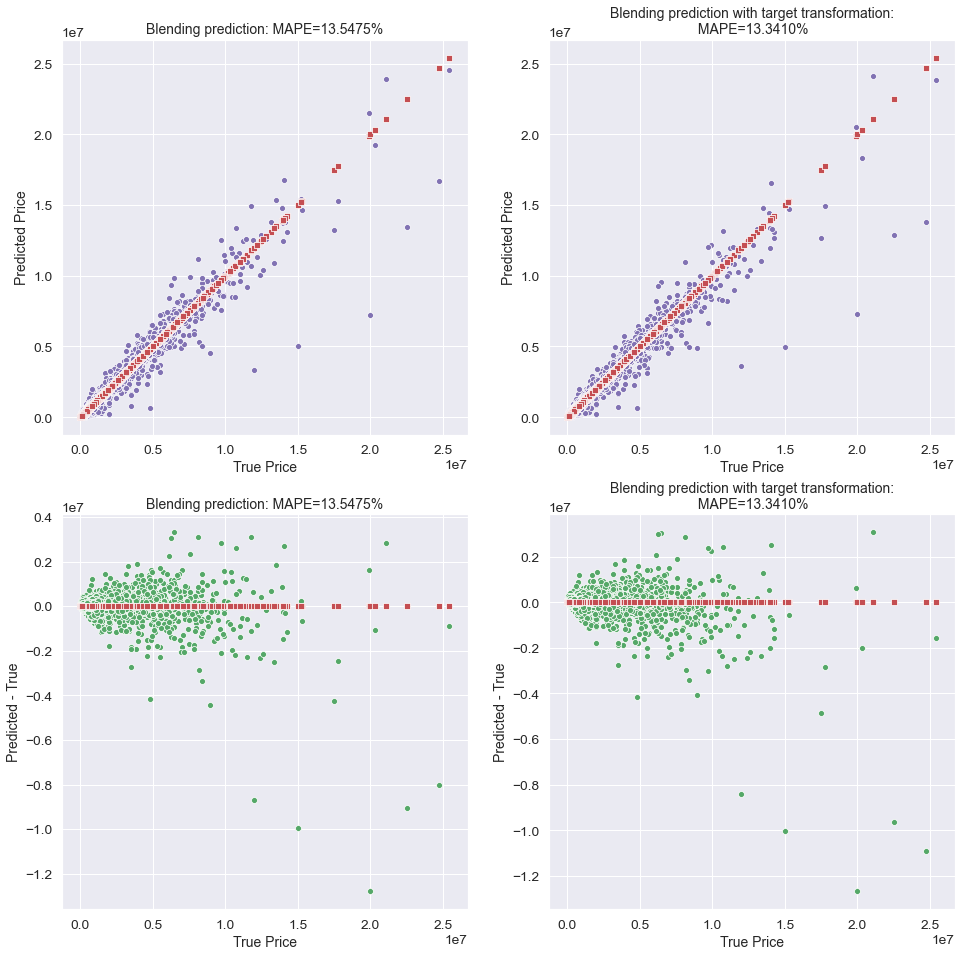

In [116]:
fig, axes = plt.subplots(2, 2, figsize=(16, 16))


plt.subplot(2, 2, 1)
sns.scatterplot(data_meta_valid[target_name], prediction_blend, marker='o', color='m')
sns.scatterplot(data_meta_valid[target_name], data_meta_valid[target_name], marker='s', color='r')

plt.title("Blending prediction: MAPE={:.4f}%".format(mape_blend), fontsize=FONT_SIZE)
plt.xlabel("True Price", fontsize=FONT_SIZE)
plt.ylabel("Predicted Price", fontsize=FONT_SIZE)


plt.subplot(2, 2, 2)
sns.scatterplot(data_meta_valid[target_name], prediction_blend_transform, marker='o', color='m')
sns.scatterplot(data_meta_valid[target_name], data_meta_valid[target_name], marker='s', color='r')

plt.title("Blending prediction with target transformation:\n MAPE={:.4f}%"
          .format(mape_blend_transform), fontsize=FONT_SIZE)
plt.xlabel("True Price", fontsize=FONT_SIZE)
plt.ylabel("Predicted Price", fontsize=FONT_SIZE)


plt.subplot(2, 2, 3)
sns.scatterplot(data_meta_valid[target_name], prediction_blend-data_meta_valid[target_name], marker='o', color='g')
sns.scatterplot(data_meta_valid[target_name], data_meta_valid[target_name]-data_meta_valid[target_name], marker='s', color='r')

plt.title("Blending prediction: MAPE={:.4f}%".format(mape_blend), fontsize=FONT_SIZE)
plt.xlabel("True Price", fontsize=FONT_SIZE)
plt.ylabel("Predicted - True", fontsize=FONT_SIZE)


plt.subplot(2, 2, 4)
sns.scatterplot(data_meta_valid[target_name], prediction_blend_transform-data_meta_valid[target_name], 
                marker='o', color='g')
sns.scatterplot(data_meta_valid[target_name], data_meta_valid[target_name]-data_meta_valid[target_name], 
                marker='s', color='r')

plt.title("Blending prediction with target transformation:\n MAPE={:.4f}%"
          .format(mape_blend_transform), fontsize=FONT_SIZE)
plt.xlabel("True Price", fontsize=FONT_SIZE)
plt.ylabel("Predicted - True", fontsize=FONT_SIZE)
plt.show()

In [117]:
# running_time(time.time(), total_time_start)

<div class="alert alert-block alert-danger">
<div style="border:solid red 2px; padding: 20px"> <h2 style="color:red; margin-bottom:20px">
7.2 Stacking  with LightGBM</h2>

</div>

### 7.2.1 Optimization of  meta model

In [118]:
EstimatorClass = 'lgbm'

model_type = 'LGBM'

### fixed parameters

try:
    param_dict_fix
except NameError:
    pass
else:
    del param_dict_fix

param_dict_fix = {}

param_dict_fix['objective'] = OBJECTIVE
# param_dict_fix['boosting_type'] = 'gbdt'
param_dict_fix['random_state'] = RANDOM_STATE
# param_dict_fix['silent'] = False
param_dict_fix['free_raw_data'] = False

param_dict_fix['n_estimators'] = 1002
param_dict_fix['learning_rate'] = 0.101
# param_dict_fix['num_leaves'] = 8
# param_dict_fix['min_data_in_leaf'] = 107
param_dict_fix['max_depth'] = 3
# param_dict_fix['max_depth'] = -1, ## no limit
### limit the max depth for tree model. This is used to deal with over-fitting when #data is small. Tree still grows leaf-wise
### <= 0 means no limit



### variable parameters

params_lim = {}

params_lim['n_estimators'] = [2, 4002, 'int']
params_lim['learning_rate'] = [0.001, 2.001, 'float']
params_lim['max_depth'] = [2, 102, 'int']
# params_lim['num_leaves'] = [2, 127, 'int']
# params_lim['min_data_in_leaf'] = [2, 1002, 'int']

[0]
params_limits : {'n_estimators': [2, 4002, 'int'], 'learning_rate': [0.001, 2.001, 'float'], 'max_depth': [2, 102, 'int']}


C:\Users\DNS\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


OUT [0]: M(i) = 1000000000.000000; M(i+1) = 13.449901 (tol=0.0001)
result_dict {'n_estimators': 202, 'learning_rate': 0.101, 'max_depth': 7}
Iteration time = 61.62 sec

 ~ ~ ~ ~ ~ ~ ~ ~ ~  

[1]
params_limits : {'n_estimators': [2, 402, 'int'], 'learning_rate': [0.0010000000000000009, 0.201, 'float'], 'max_depth': [2, 12, 'int']}
OUT [1]: M(i) = 13.449901; M(i+1) = 13.391199 (tol=0.0001)
result_dict {'n_estimators': 122, 'learning_rate': 0.061, 'max_depth': 4}
Iteration time = 16.55 sec

 ~ ~ ~ ~ ~ ~ ~ ~ ~  

[2]
params_limits : {'n_estimators': [102, 142, 'int'], 'learning_rate': [0.051, 0.071, 'float'], 'max_depth': [3, 5, 'int']}
OUT [2]: M(i) = 13.391199; M(i+1) = 13.392328 (tol=0.0001)
result_dict {'n_estimators': 124, 'learning_rate': 0.059, 'max_depth': 4}
Iteration time = 10.43 sec

 ~ ~ ~ ~ ~ ~ ~ ~ ~  

13.391199184947302


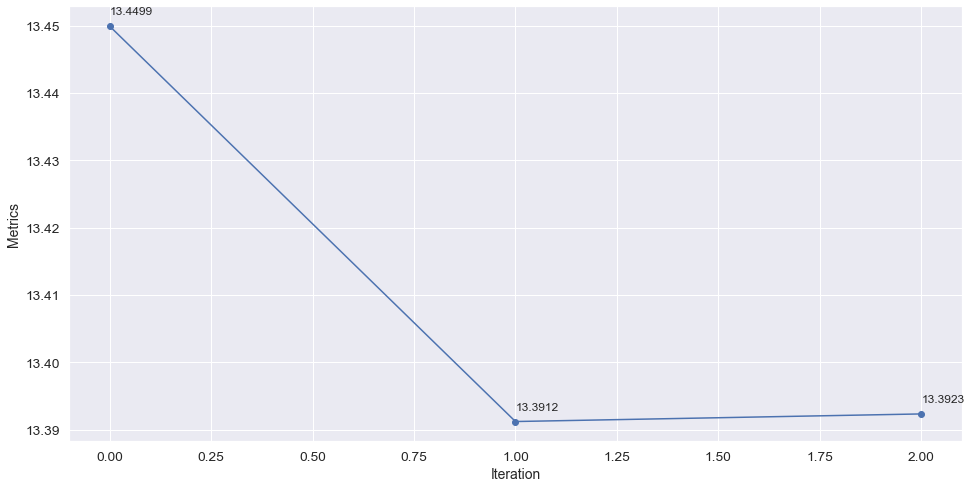


Done. Congratulations!
[***] This is Houston. The MET is : 0:25:40.120    (H:MM:SS)
==== ==== ==== ==== ==== 
The parameters of the best meta model are:  {'n_estimators': 122, 'learning_rate': 0.061, 'max_depth': 4}
The best meta model has MAPE=13.3912
Wall time: 1min 29s


In [119]:
%%time

result = model_coord_search(EstimatorClass, param_dict_fix, params_lim, 
                            data_meta_train, data_meta_valid, target_name, N_SAMPLE_META, 
                            metrics_func=mean_absolute_percent_error, tol=0.0001, iter_lim=100, 
                            lgb_categorical_feature_list=CATEGORICAL_FEATURE_LIST_LGBM,  ## lgb_categorical_feature_list='auto',
                            verbose_cycle=True, verbose_detail=False, 
                            visualize_cycle=True, visualize_detail=False)

result_dict, metrics_out = result

running_time(time.time(), total_time_start)

print("==== "*5)
print("The parameters of the best meta model are: ", result_dict)
print("The best meta model has MAPE={:.4f}".format(metrics_out))

In [120]:
best_meta_model_mape = metrics_out
best_parameters_meta = result_dict
print("The best parameters for the meta model are: ", best_parameters_meta)
print("We have the MAPE = {:.4f} for the best meta model. ".format(best_meta_model_mape))

The best parameters for the meta model are:  {'n_estimators': 122, 'learning_rate': 0.061, 'max_depth': 4}
We have the MAPE = 13.3912 for the best meta model. 


### 7.2.2 Collect an ensemle of nearly best meta models

In [121]:
N_grid = 3

In [122]:
EstimatorClass = 'lgbm'



### fixed parameters

try:
    param_dict_fix
except NameError:
    pass
else:
    del param_dict_fix

param_dict_fix = {}

param_dict_fix['objective'] = OBJECTIVE
# param_dict_fix['boosting_type'] = 'gbdt'
# param_dict_fix['random_state'] = RANDOM_STATE
# param_dict_fix['silent'] = False
param_dict_fix['free_raw_data'] = False

param_dict_fix['n_estimators'] = 31
param_dict_fix['learning_rate'] = np.round(best_parameters_meta['learning_rate'], 9)
# param_dict_fix['num_leaves'] = 26
# param_dict_fix['min_data_in_leaf'] = 21
param_dict_fix['max_depth'] = 4


# param_dict_fix['max_depth'] = -1, ## no limit
# param_dict_fix['n_estimators'] = 100
# param_dict_fix['learning_rate'] = 0.01



### best optimised parameters

n_es_0 = best_parameters_meta['n_estimators']
md_0 = best_parameters_meta['max_depth']
lr_0 = np.round(best_parameters_meta['learning_rate'], 9)
# n_l_0 = best_parameters_meta['num_leaves']
# mdil_0 = best_parameters_meta['min_data_in_leaf']

params_optim = {}

params_optim['n_estimators'] = np.linspace( max( [2, n_es_0-STEP_INT*(N_grid-1)/2] ),
                                           max( [2, n_es_0-STEP_INT*(N_grid-1)/2] ) + STEP_INT*(N_grid-1), 
                                           num=N_grid, dtype='int' )
params_optim['max_depth'] = np.linspace( max( [2, md_0-STEP_INT*(N_grid-1)/2] ), 
                                        max( [2, md_0-STEP_INT*(N_grid-1)/2] ) + STEP_INT*(N_grid-1),
                                        num = N_grid, dtype='int'  )

# params_optim['n_estimators'] = [max([2, n_es_0-200*STEP_INT]), n_es_0-100*STEP_INT,
#                                 n_es_0, n_es_0+100*STEP_INT, n_es_0+200*STEP_INT ]
# params_optim['max_depth'] = [ max([2, md_0-STEP_INT]), md_0, md_0+STEP_INT, md_0+2*STEP_INT, md_0+3*STEP_INT ]

# params_optim['n_estimators'] = [max([2, n_es_0-100*STEP_INT]), n_es_0, n_es_0+100*STEP_INT ]
# params_optim['max_depth'] = [ max([2, md_0-STEP_INT]), md_0, md_0+STEP_INT ]

# params_optim['learning_rate'] = [ max(0.0001, np.round(lr_0-STEP_LR, 9)), lr_0, np.round(lr_0+STEP_LR, 9) ]
# params_optim['num_leaves'] = [max([2, n_l_0-STEP_INT]), n_l_0, n_l_0+STEP_INT ]
# params_optim['min_data_in_leaf'] = [max([2, mdil_0-STEP_INT]), mdil_0, mdil_0+STEP_INT ]

params_optim

{'n_estimators': array([121, 122, 123]), 'max_depth': array([3, 4, 5])}

In [123]:
%%time
meta_model_storage =  model_collector(EstimatorClass, param_dict_fix, params_optim, 
                                      data_meta_train, data_meta_valid, target_name, N_SAMPLE_META, 
                                      metrics_func=mean_absolute_percent_error,
                                      lgb_categorical_feature_list=CATEGORICAL_FEATURE_LIST_LGBM)  ## lgb_categorical_feature_list='auto')

running_time(time.time(), total_time_start)

['n_estimators', 'max_depth', 'metrics', 'performance_time', 'model']


C:\Users\DNS\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[121, 3, 13.393953543882747, 0.28402066230773926, <lightgbm.basic.Booster object at 0x000001E7804E9088>]
[121, 4, 13.391295820316696, 0.34102344512939453, <lightgbm.basic.Booster object at 0x000001E780CD3BC8>]
[121, 5, 13.406000409165491, 0.4130284786224365, <lightgbm.basic.Booster object at 0x000001E780CD3DC8>]
[122, 3, 13.393673477858476, 0.2850198745727539, <lightgbm.basic.Booster object at 0x000001E7800AE508>]
[122, 4, 13.391199184947302, 0.33103394508361816, <lightgbm.basic.Booster object at 0x000001E7802E1148>]
[122, 5, 13.405934127698949, 0.4701099395751953, <lightgbm.basic.Booster object at 0x000001E7804C7A88>]
[123, 3, 13.393319098088982, 0.2086944580078125, <lightgbm.basic.Booster object at 0x000001E7804C0508>]
[123, 4, 13.390723271476142, 0.339022159576416, <lightgbm.basic.Booster object at 0x000001E7804D8B08>]
[123, 5, 13.406131511158865, 0.35747647285461426, <lightgbm.basic.Booster object at 0x000001E78133D408>]
[***] This is Houston. The MET is : 0:25:43.360    (H:MM:SS)


In [124]:
meta_model_storage = meta_model_storage[ -meta_model_storage['metrics'].duplicated() ]
meta_model_storage.reset_index(inplace=True)
meta_model_storage

index n_estimators max_depth    metrics  performance_time  \
0      0          123         4  13.390723          0.339022   
1      1          122         4  13.391199          0.331034   
2      2          121         4  13.391296          0.341023   
3      3          123         3  13.393319          0.208694   
4      4          122         3  13.393673          0.285020   
5      5          121         3  13.393954          0.284021   
6      6          122         5  13.405934          0.470110   
7      7          121         5  13.406000          0.413028   
8      8          123         5  13.406132          0.357476   

                                               model  
0  <lightgbm.basic.Booster object at 0x000001E780...  
1  <lightgbm.basic.Booster object at 0x000001E780...  
2  <lightgbm.basic.Booster object at 0x000001E780...  
3  <lightgbm.basic.Booster object at 0x000001E780...  
4  <lightgbm.basic.Booster object at 0x000001E780...  
5  <lightgbm.basic.Booster object at 0x000001E780...  
6  <lightgbm.basic.Booster object at 0x000001E780...  
7  <lightgbm.basic.Booster object at 0x000001E780...  
8  <lightgbm.basic.Booster object at 0x000001E781...

### 7.2.3. About the best meta model. Feature importance.

In [125]:
best_meta_model = meta_model_storage.loc[0, "model"]
print("Best base model demonstrates MAPE = {:.4f} with 'valid1' sample."
      .format(meta_model_storage.loc[0, "metrics"]))

Best base model demonstrates MAPE = 13.3907 with 'valid1' sample.


In [126]:
features_importances_best_meta_model = pd.DataFrame(
    data=100*best_meta_model.feature_importance()/best_meta_model.feature_importance().sum(), 
    index=data_meta_train.drop([target_name], axis=1).columns, columns=['Importance_(%)'])

features_importances_best_meta_model = features_importances_best_meta_model.sort_values(by='Importance_(%)', 
                                                                                        ascending=False)

features_importances_best_meta_model.head(20)

Importance_(%)
3              17.727543
6              15.407496
Averaged       14.515170
0              13.146936
4              10.232005
1               9.339679
7               7.317073
8               5.056514
2               4.580607
5               2.676978

In [127]:
z = features_importances_best_meta_model[(features_importances_best_meta_model['Importance_(%)'] != 0) & 
                                         (features_importances_best_meta_model['Importance_(%)'].notna())].values.flatten()
y = np.log(z)
x = np.arange(0, len(y))

p = np.polyfit(x, y, 1)
length = float(-1/p[0])
feature_deficiency = 1/( np.exp(len(y)/length) - 1  )

print("The 'exponential decay length' is {:.2f} 'features'.".format( length ))
print("A lack od features is about {:.1%}.".format(float(feature_deficiency)))
print("\n If you see 'nan', it means that at least one of feature has a zero-importance.")

real_importance = np.exp( np.polyval(p, x) )

The 'exponential decay length' is 5.06 'features'.
A lack od features is about 16.1%.

 If you see 'nan', it means that at least one of feature has a zero-importance.


In [128]:
feature_deficient = 0.01
print("We need {} instead of {} now for feature sufficiency of {:.1%}, while now we have {:.1%}."
      .format( int(np.ceil( -length*np.log(feature_deficiency) )), len(x), 
              1-feature_deficient, 1-feature_deficiency ))

We need 10 instead of 10 now for feature sufficiency of 99.0%, while now we have 83.9%.


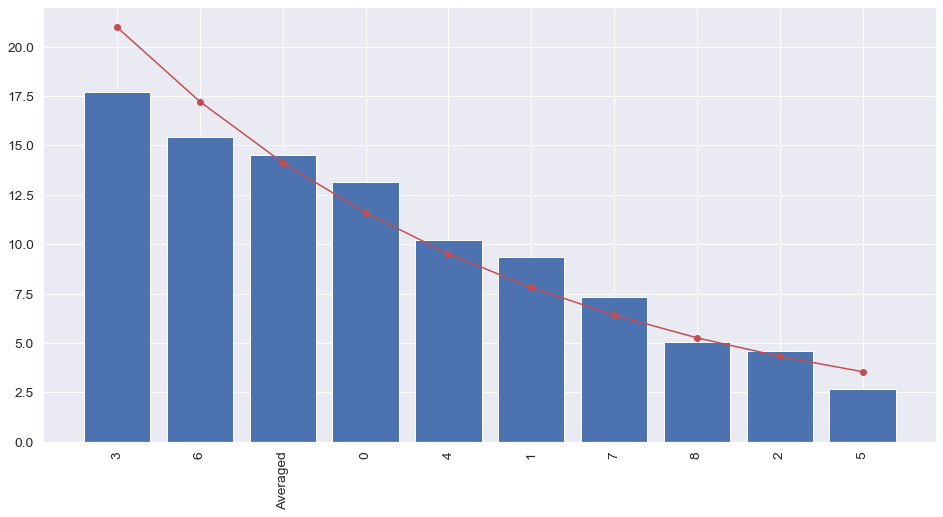

In [129]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))

plt.bar(x, z)
plt.plot(x, real_importance, '-ro')
plt.xticks(x, features_importances_best_meta_model.index, rotation=90)

plt.show()

In [130]:
feature_deficiency, len(x), int( len(x)*( 1 + int(feature_deficiency)) )

(0.16067334734686795, 10, 10)

The range of prediction for Model No. 0 are: [48099.0, 12939718.0] with the width of 12891619.0
The range of prediction for Model No. 1 are: [48106.0, 12939515.0] with the width of 12891409.0
The range of prediction for Model No. 2 are: [48107.0, 12936457.0] with the width of 12888350.0


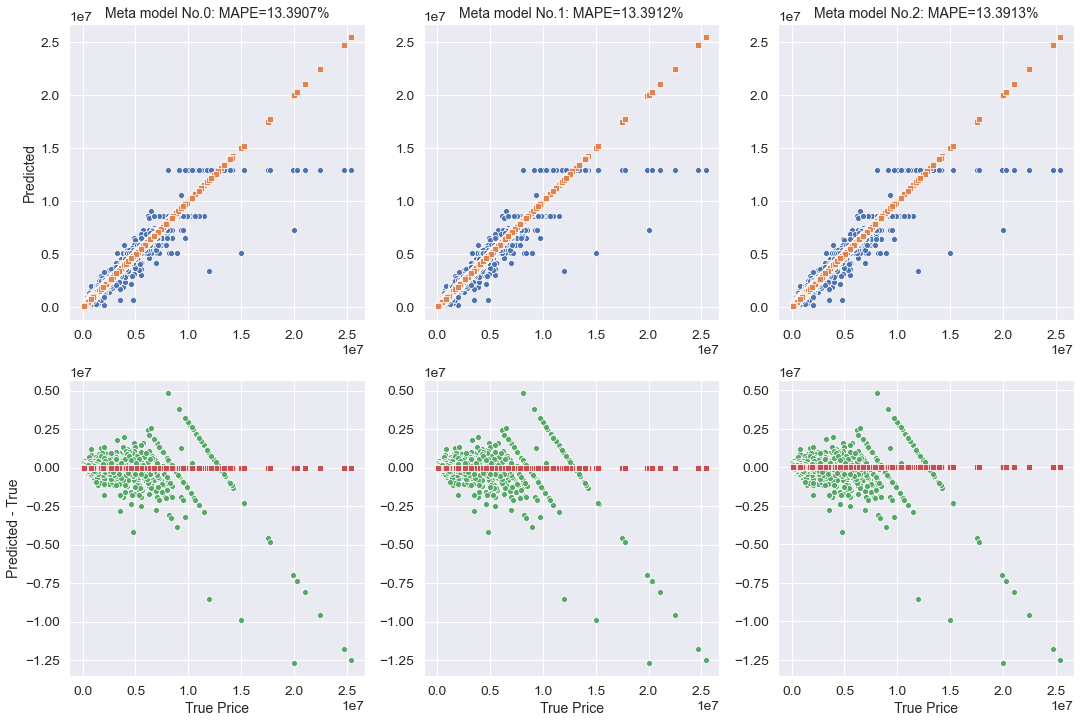

In [131]:
df = meta_model_storage


n = min(3, len(df))

fig, axes = plt.subplots(2, n, figsize=(6*n, 12) )

for i in range(n):
    model = df.loc[i, "model"]
#     prediction = model.predict(data_meta_valid.drop([target_name], axis=1))
#     prediction_log10 = model.predict(data_meta_valid.drop([target_name], axis=1))
#     prediction = 10**prediction_log10
    prediction_transformed = model.predict(data_meta_valid.drop([target_name], axis=1))
    prediction = np.round(target_transform_inv(prediction_transformed, POWER)).astype(int)
    print("The range of prediction for Model No. {} are: [{:.1f}, {:.1f}] with the width of {:.1f}"
          .format( i, prediction.min(), prediction.max(), prediction.max()-prediction.min() ))
    
    plt.subplot(2, n, i+1)
    sns.scatterplot(data_meta_valid[target_name], prediction)
    sns.scatterplot(data_meta_valid[target_name], data_meta_valid[target_name], marker='s')
    plt.title("Meta model No.{}: MAPE={:.4f}%".format(i, df.loc[i, "metrics"]), fontsize=FONT_SIZE)
    plt.xlabel("", fontsize=FONT_SIZE)
    if i == 0:
        plt.ylabel("Predicted", fontsize=FONT_SIZE)
    else:
        plt.ylabel("", fontsize=FONT_SIZE)
        
    plt.subplot(2, n, n+i+1)
    sns.scatterplot(data_meta_valid[target_name], prediction - data_meta_valid[target_name], color='g')
    sns.scatterplot(data_meta_valid[target_name], data_meta_valid[target_name] - data_meta_valid[target_name], 
                    marker='s', color='r')
    plt.xlabel("True Price", fontsize=FONT_SIZE)
    if i == 0:
        plt.ylabel("Predicted - True", fontsize=FONT_SIZE)
    else:
        plt.ylabel("", fontsize=FONT_SIZE)

##  7.3 Averaged over $\sqrt{N}$ and $N$ best meta models prediction (*LGBMRegressor*)

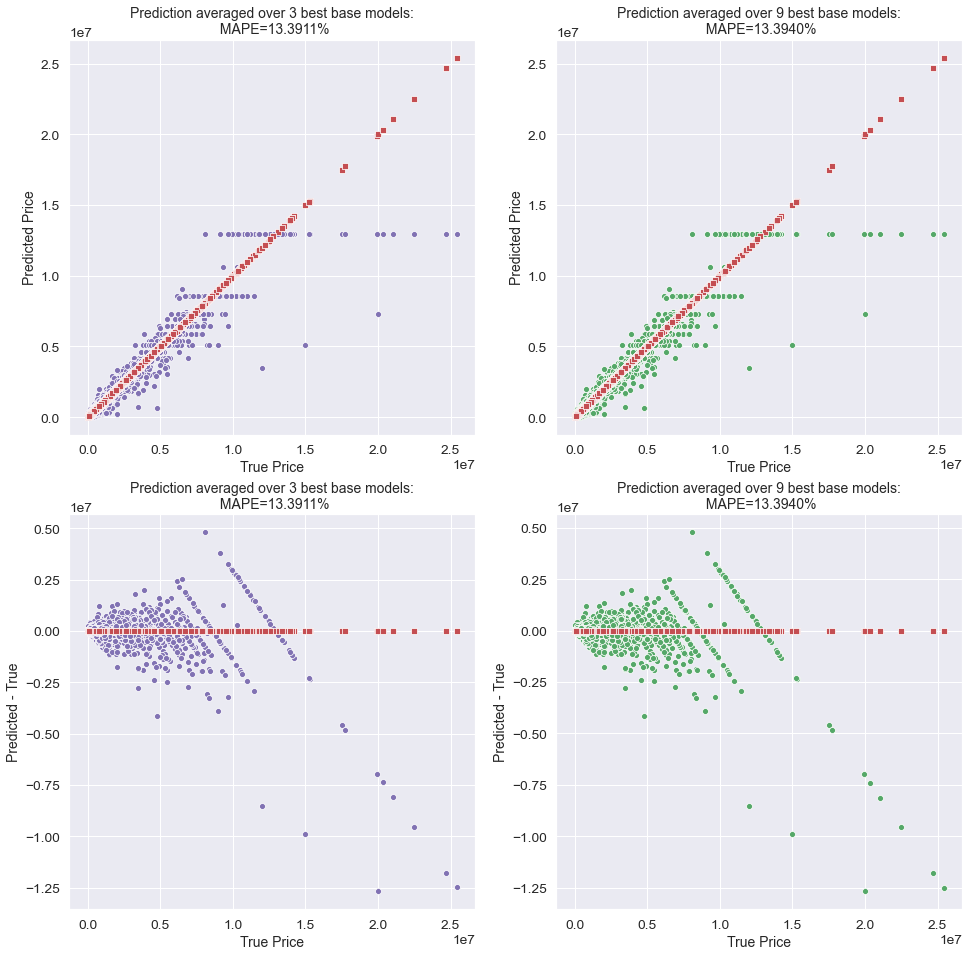

In [132]:
df = meta_model_storage

fig, axes = plt.subplots(2, 2, figsize=(16, 16))



### SQRT

n_models = int(np.sqrt(len(df)))

predictions = []
for model in df.loc[:n_models-1, "model"]:
#     prediction = model.predict(data_meta_valid.drop([target_name], axis=1))
#     prediction_log10 = model.predict(data_meta_valid.drop([target_name], axis=1))
#     prediction = 10**prediction_log10
    prediction_transformed = model.predict(data_meta_valid.drop([target_name], axis=1))
    prediction = np.round(target_transform_inv(prediction_transformed, POWER)).astype(int)
    predictions.append(prediction)
    
predictions = np.array(predictions)
meta_mean_prediction_sqrt = predictions.mean(axis=0)
meta_mape_of_mean_sqrt = mean_absolute_percent_error(data_meta_valid[target_name], meta_mean_prediction_sqrt)


plt.subplot(2, 2, 1)
sns.scatterplot(data_meta_valid[target_name], meta_mean_prediction_sqrt, marker='o', color='m')
sns.scatterplot(data_meta_valid[target_name], data_meta_valid[target_name], marker='s', color='r')
plt.title("Prediction averaged over {} best base models:\n MAPE={:.4f}%"
          .format(n_models, meta_mape_of_mean_sqrt), fontsize=FONT_SIZE)
plt.xlabel("True Price", fontsize=FONT_SIZE)
plt.ylabel("Predicted Price", fontsize=FONT_SIZE)


plt.subplot(2, 2, 3)
sns.scatterplot(data_meta_valid[target_name], meta_mean_prediction_sqrt - data_meta_valid[target_name], 
                marker='o', color='m')
sns.scatterplot(data_meta_valid[target_name], data_meta_valid[target_name] - data_meta_valid[target_name], 
                marker='s', color='r')

plt.title("Prediction averaged over {} best base models:\n MAPE={:.4f}%"
          .format(n_models, meta_mape_of_mean_sqrt), fontsize=FONT_SIZE)
plt.xlabel("True Price", fontsize=FONT_SIZE)
plt.ylabel("Predicted - True", fontsize=FONT_SIZE)



### ALL

n_models = len(df)

predictions = []
for model in df.loc[:n_models-1, "model"]:
#     prediction = model.predict(data_meta_valid.drop([target_name], axis=1))
#     prediction_log10 = model.predict(data_meta_valid.drop([target_name], axis=1))
#     prediction = 10**prediction_log10
    prediction_transformed = model.predict(data_meta_valid.drop([target_name], axis=1))
    prediction = np.round(target_transform_inv(prediction_transformed, POWER)).astype(int)
    predictions.append(prediction)
    
predictions = np.array(predictions)
meta_mean_prediction_all = predictions.mean(axis=0)
meta_mape_of_mean_all = mean_absolute_percent_error(data_meta_valid[target_name], meta_mean_prediction_all)


plt.subplot(2, 2, 2)
sns.scatterplot(data_meta_valid[target_name], meta_mean_prediction_all, marker='o', color='g')
sns.scatterplot(data_meta_valid[target_name], data_meta_valid[target_name], marker='s', color='r')
plt.title("Prediction averaged over {} best base models:\n MAPE={:.4f}%"
          .format(n_models, meta_mape_of_mean_all), fontsize=FONT_SIZE)
plt.xlabel("True Price", fontsize=FONT_SIZE)
plt.ylabel("Predicted Price", fontsize=FONT_SIZE)


plt.subplot(2, 2, 4)
sns.scatterplot(data_meta_valid[target_name], meta_mean_prediction_all - data_meta_valid[target_name], 
                marker='o', color='g')
sns.scatterplot(data_meta_valid[target_name], data_meta_valid[target_name] - data_meta_valid[target_name], 
                marker='s', color='r')

plt.title("Prediction averaged over {} best base models:\n MAPE={:.4f}%"
          .format(n_models, meta_mape_of_mean_all), fontsize=FONT_SIZE)
plt.xlabel("True Price", fontsize=FONT_SIZE)
plt.ylabel("Predicted - True", fontsize=FONT_SIZE)

plt.show()

In [133]:
performance_time = time.time() - total_time_start

running_time(time.time(), total_time_start)

[***] This is Houston. The MET is : 0:25:48.797    (H:MM:SS)


In [134]:
final_results = pd.DataFrame({'Action': ["Unoptimized model",
                                         "Best base model", "Best base averaged (sqrt 1)", 
                                         "Best base averaged (all 1)", "Best base averaged (all 2)", 
                                         "Blending with LinearRegression", 
                                         "Blending with LinearRegression with transformed target", 
                                         "Best meta model", 
                                         "Meta averaged (sqrt 2)", "Meta averaged (all 2)]"],
                              "MAPE": [mape_unoptimized,
                                       base_model_storage.loc[0, "metrics"],  mape_of_mean_sqrt, 
                                       mape_of_mean_all, mape_averaged_meta_valid, 
                                       mape_blend, 
                                       mape_blend_transform, 
                                       meta_model_storage.loc[0, "metrics"], 
                                       meta_mape_of_mean_sqrt, meta_mape_of_mean_all],
                              "Description": ["LightGBM with default parameters",
                                              "Calculated with valid_1.", 
                                              "Averaged over {} best models [valid_1]."
                                              .format( int(np.sqrt( len(base_model_storage) )) ), 
                                              ##
                                              "Averaged over {} best models [valid_1]."
                                              .format( len(base_model_storage) ), 
                                              "Averaged over {} best models [valid_2]."
                                              .format( len(base_model_storage) ), 
                                              ##
                                              "Weighted mean for {} predictions (with averaged) [valid_2]."
                                              .format( data_meta_valid.shape[1]-1 ), 
                                              "Weighted mean for {} predictions with transformed target (with averaged) [valid_2]."
                                              .format( data_meta_valid.shape[1]-1 ), 
                                              "Calculated with valid_2.",
                                              ##
                                              "Averaged over {} best meta models [valid_2]."
                                              .format( int(np.sqrt( len(base_model_storage) )) ), 
                                              "Averaged over {} best meta models [valid_2]."
                                              .format( len(base_model_storage) ) ],
                              "Phase" : ["", "", "BAGGING", 
                                         "BAGGING", "BLENDING", 
                                         "STACKING", 
                                         "BLENDING", 
                                         "BLENDING", 
                                         "STACKING", "STACKING"]})
final_results

Action       MAPE  \
0                                  Unoptimized model  13.924588   
1                                    Best base model  13.145233   
2                        Best base averaged (sqrt 1)  13.145413   
3                         Best base averaged (all 1)  13.130335   
4                         Best base averaged (all 2)  13.265925   
5                     Blending with LinearRegression  13.547514   
6  Blending with LinearRegression with transforme...  13.341029   
7                                    Best meta model  13.390723   
8                             Meta averaged (sqrt 2)  13.391070   
9                             Meta averaged (all 2)]  13.393966   

                                         Description     Phase  
0                   LightGBM with default parameters            
1                           Calculated with valid_1.            
2             Averaged over 3 best models [valid_1].   BAGGING  
3             Averaged over 9 best models [valid_1].   BAGGING  
4             Averaged over 9 best models [valid_2].  BLENDING  
5  Weighted mean for 10 predictions (with average...  STACKING  
6  Weighted mean for 10 predictions with transfor...  BLENDING  
7                           Calculated with valid_2.  BLENDING  
8        Averaged over 3 best meta models [valid_2].  STACKING  
9        Averaged over 9 best meta models [valid_2].  STACKING

In [135]:
final_results.sort_values('MAPE', ascending=True)

Action       MAPE  \
3                         Best base averaged (all 1)  13.130335   
1                                    Best base model  13.145233   
2                        Best base averaged (sqrt 1)  13.145413   
4                         Best base averaged (all 2)  13.265925   
6  Blending with LinearRegression with transforme...  13.341029   
7                                    Best meta model  13.390723   
8                             Meta averaged (sqrt 2)  13.391070   
9                             Meta averaged (all 2)]  13.393966   
5                     Blending with LinearRegression  13.547514   
0                                  Unoptimized model  13.924588   

                                         Description     Phase  
3             Averaged over 9 best models [valid_1].   BAGGING  
1                           Calculated with valid_1.            
2             Averaged over 3 best models [valid_1].   BAGGING  
4             Averaged over 9 best models [valid_2].  BLENDING  
6  Weighted mean for 10 predictions with transfor...  BLENDING  
7                           Calculated with valid_2.  BLENDING  
8        Averaged over 3 best meta models [valid_2].  STACKING  
9        Averaged over 9 best meta models [valid_2].  STACKING  
5  Weighted mean for 10 predictions (with average...  STACKING  
0                   LightGBM with default parameters

# 8 Приведение в соответствие данных обучающей и внешней тестовой выборок

Приведение в сооветствиие данных обучающей и внешней тестовой выборок предполагает соответсвие признаков по сути, названию и содержанию.

Загрузим внешние данные ("представленные заказчиком для прогнозирования").

In [136]:
test = pd.read_csv(FILEPATH + "test.csv")
test

bodyType brand       color fuelType  modelDate  \
0                 седан   BMW      чёрный   дизель     2016.0   
1                 седан   BMW       белый   дизель     2018.0   
2                 седан   BMW       синий   бензин     2009.0   
3     внедорожник 5 дв.   BMW       белый   дизель     2014.0   
4     внедорожник 5 дв.   BMW       синий   дизель     2014.0   
...                 ...   ...         ...      ...        ...   
3832              седан   BMW      чёрный   бензин     2013.0   
3833  внедорожник 5 дв.   BMW      чёрный   дизель     2013.0   
3834              седан   BMW      чёрный   бензин     2002.0   
3835              седан   BMW  коричневый   бензин     2009.0   
3836  внедорожник 5 дв.   BMW      чёрный   бензин     2007.0   

                                   name  numberOfDoors  productionDate  \
0               520d 2.0d AT (190 л.с.)            4.0          2017.0   
1               318d 2.0d AT (150 л.с.)            4.0          2019.0   
2     550i xDrive 4.4 AT (407 л.с.) 4WD            4.0          2012.0   
3            30d 3.0d AT (249 л.с.) 4WD            5.0          2015.0   
4           M50d 3.0d AT (381 л.с.) 4WD            5.0          2019.0   
...                                 ...            ...             ...   
3832             520i 2.0 AT (184 л.с.)            4.0          2013.0   
3833         30d 3.0d AT (249 л.с.) 4WD            5.0          2016.0   
3834        525xi 2.5 AT (218 л.с.) 4WD            4.0          2006.0   
3835  528i xDrive 2.0 AT (245 л.с.) 4WD            4.0          2012.0   
3836          50i 4.4 AT (407 л.с.) 4WD            5.0          2010.0   

               vehicleConfiguration vehicleTransmission  ...   mileage  \
0               SEDAN AUTOMATIC 2.0      автоматическая  ...  158836.0   
1               SEDAN AUTOMATIC 2.0      автоматическая  ...      10.0   
2               SEDAN AUTOMATIC 4.4      автоматическая  ...  120000.0   
3     ALLROAD_5_DOORS AUTOMATIC 3.0      автоматическая  ...  111466.0   
4     ALLROAD_5_DOORS AUTOMATIC 3.0      автоматическая  ...   11891.0   
...                             ...                 ...  ...       ...   
3832            SEDAN AUTOMATIC 2.0      автоматическая  ...   98000.0   
3833  ALLROAD_5_DOORS AUTOMATIC 3.0      автоматическая  ...  169615.0   
3834            SEDAN AUTOMATIC 2.5      автоматическая  ...  180000.0   
3835            SEDAN AUTOMATIC 2.0      автоматическая  ...  137500.0   
3836  ALLROAD_5_DOORS AUTOMATIC 4.4      автоматическая  ...   89905.0   

                                           Комплектация  Привод   Руль  \
0     ['[{"name":"Безопасность","values":["Антипробу...  задний  Левый   
1     ['[{"name":"Комфорт","values":["Круиз-контроль...  задний  Левый   
2     ['[{"name":"Комфорт","values":["Круиз-контроль...  полный  Левый   
3     ['[{"name":"Комфорт","values":["Круиз-контроль...  полный  Левый   
4     ['[{"name":"Комфорт","values":["Круиз-контроль...  полный  Левый   
...                                                 ...     ...    ...   
3832  ['[{"name":"Комфорт","values":["Круиз-контроль...  задний  Левый   
3833  ['[{"name":"Комфорт","values":["Круиз-контроль...  полный  Левый   
3834  ['[{"name":"Комфорт","values":["Круиз-контроль...  полный  Левый   
3835  ['[{"name":"Комфорт","values":["Круиз-контроль...  полный  Левый   
3836  ['[{"name":"Комфорт","values":["Круиз-контроль...  полный  Левый   

               Состояние    Владельцы       ПТС     Таможня  \
0     Не требует ремонта   1 владелец  Оригинал  Растаможен   
1     Не требует ремонта   1 владелец  Оригинал  Растаможен   
2     Не требует ремонта  2 владельца  Оригинал  Растаможен   
3     Не требует ремонта  2 владельца  Оригинал  Растаможен   
4     Не требует ремонта   1 владелец  Оригинал  Растаможен   
...                  ...          ...       ...         ...   
3832  Не требует ремонта  3 или более  Оригинал  Растаможен   
3833  Не требует ремонта   1 владелец  Оригинал  Растаможен   


In [137]:
test.columns

Index(['bodyType', 'brand', 'color', 'fuelType', 'modelDate', 'name',
       'numberOfDoors', 'productionDate', 'vehicleConfiguration',
       'vehicleTransmission', 'engineDisplacement', 'enginePower',
       'description', 'mileage', 'Комплектация', 'Привод', 'Руль', 'Состояние',
       'Владельцы', 'ПТС', 'Таможня', 'Владение', 'id'],
      dtype='object')

Внешние данные содержат 3837 записей. По сути данные совпадают с данными, которые мы будем использовать для построения общей модели. 

Требуется приведение в соответствие:
- названий признаков
- формата представления данных

In [138]:
print("\n 1.", "="*30, "\n")

print("vehicleConfiguration    :", test.loc[0, 'vehicleConfiguration'])
print("-"*30)
print("bodyType                :", test.loc[0, 'bodyType'])
print("vehicleTransmission     :", test.loc[0, 'vehicleTransmission'])
print("engineDisplacement      :", test.loc[0, 'engineDisplacement'])



print("\n 2.", "="*30, "\n")

print("description             :", test.loc[0, 'description'])
print("-"*30)
print("ПТС                     :", test.loc[0, 'ПТС'])
print("Комплектация            :", test.loc[0, 'Комплектация'])



print("\n 3.", "="*30, "\n")

print("Состояние               :", test.loc[0, 'Состояние'])
print("-"*30)
test['Состояние'].value_counts()



print("\n 4.", "="*30, "\n")

print("ПТС                     :", test.loc[0, 'ПТС'])
print("-"*30)
test['ПТС'].value_counts()



print("\n 5.", "="*30, "\n")

print("Таможня                 :", test.loc[0, 'Таможня'])
print("-"*30)
test['Таможня'].value_counts()



print("\n 5.", "="*30, "\n")

print("Владение                :", test.loc[0, 'Владение'])
print("-"*30)
test['Владение'].value_counts()



 1. ============================== 

vehicleConfiguration    : SEDAN AUTOMATIC 2.0
------------------------------
bodyType                : седан
vehicleTransmission     : автоматическая
engineDisplacement      : 2.0 LTR

 2. ============================== 

description             : В РОЛЬФ Ясенево представлено более 500 автомобилей с пробегом и более 300 комплектов шин, дисков, колес в сборе.

Специальные условия на Автокредит от 9,9% годовых.
Оригинальный ПТС. 1 владелец.
Дилерское обслуживание. Сервисная книжка.
Полный комплект ключей.

Дополнительная комплектация:

- Климат-контроль 2-х зонный
- Датчики парковки спереди и сзади
- Светодиодный головной свет
- Мультифункциональный руль с подогревом
- Передние сиденья с подогревом и электрорегулировками
- Система старт/стоп
- Круиз-контроль
------------------------------
ПТС                     : Оригинал
Комплектация            : ['[{"name":"Безопасность","values":["Антипробуксовочная система (ASR)","Система стабилизации (ESP)","По

1 год и 1 месяц       40
1 год и 4 месяца      39
1 год и 3 месяца      37
1 год и 2 месяца      36
1 год и 8 месяцев     33
                      ..
16 лет и 8 месяцев     1
15 лет и 5 месяцев     1
11 лет и 1 месяц       1
15 лет и 8 месяцев     1
11 лет и 8 месяцев     1
Name: Владение, Length: 157, dtype: int64

Удаляем следующие признаки:

1. `vehicleConfiguration` - данные дублируют `bodyType`, `vehicleTransmission` и `engineDisplacement`
2. `description` - частично соодержит ненужную информацию, в остальном дублируют данные 
3. `Состояние` - как и обучающий набор содержит только одно значение - это не значащий признак.
4. `ПТС` - как и обучающий набор содержит только одно значение - это не значащий признак.
5. `Таможня` - как и обучающий набор содержит только одно значение - это не значащий признак.
6. `Владение` - содержит ненужные нам данные
7. `id` - содержит ненужные нам данные
8. `modelDate` - информация о дате появления модели нам не нужна: 1) её нет в нашей обучающей выборке, 2) дате появления модели имманентна названию модели

In [139]:
test = test.drop(['vehicleConfiguration', 'description', 'Состояние', 'ПТС', 
                  'Таможня', 'Владение', 'id', 'modelDate'], axis=1)
# test.columns

## 8.1 Приведение в соответствие признаков обучающей и внешней тестовой выборок

### bodyType

In [140]:
test['bodyType'].unique()

array(['седан', 'внедорожник 5 дв.', 'хэтчбек 3 дв.', 'хэтчбек 5 дв.',
       'купе', 'родстер', 'лифтбек', 'универсал 5 дв.', 'кабриолет',
       'седан 2 дв.', 'компактвэн'], dtype=object)

In [141]:
data['body_type'].unique()

[ALLROAD, SEDAN, HATCHBACK, NaN, VAN, COUPE, PICKUP, CABRIO, ROADSTER]
Categories (8, object): [ALLROAD, SEDAN, HATCHBACK, VAN, COUPE, PICKUP, CABRIO, ROADSTER]

In [142]:
dict_body_type = {}

dict_body_type['седан'] = 'SEDAN'
dict_body_type['внедорожник 5 дв.'] = 'ALLROAD'
dict_body_type['хэтчбек 3 дв.'] = 'HATCHBACK'
dict_body_type['хэтчбек 5 дв.'] = 'HATCHBACK'
dict_body_type['купе'] = 'COUPE'

dict_body_type['родстер'] = 'ROADSTER'
dict_body_type['седан 2 дв.'] = 'SEDAN'
dict_body_type['лифтбек'] = 'LIFTBACK'
dict_body_type['универсал 5 дв.'] = 'HATCHBACK'
dict_body_type['кабриолет'] = 'CABRIO'
dict_body_type['компактвэн'] = 'VAN'

dict_body_type

{'седан': 'SEDAN',
 'внедорожник 5 дв.': 'ALLROAD',
 'хэтчбек 3 дв.': 'HATCHBACK',
 'хэтчбек 5 дв.': 'HATCHBACK',
 'купе': 'COUPE',
 'родстер': 'ROADSTER',
 'седан 2 дв.': 'SEDAN',
 'лифтбек': 'LIFTBACK',
 'универсал 5 дв.': 'HATCHBACK',
 'кабриолет': 'CABRIO',
 'компактвэн': 'VAN'}

In [143]:
test['body_type'] = test['bodyType'].map(dict_body_type)
test = test.drop(['bodyType'], axis=1)
# test

У BMW нет пикапов - удалим их из обучающей выборки.

### brand

In [144]:
test['brand'].value_counts()

BMW    3837
Name: brand, dtype: int64

В предоставленном для предсказания датасете машины только марки BMW.
То есть, это не вариативный признак - удаляем его из представленного набора, а обучающий сужаем до машин только марки BMW. 

*Все операции с обучающем набором выполним в конце раздела - перед обучением "заточенной под BMW" модели*.

In [145]:
test = test.drop(['brand'], axis=1)
# test

### color

In [146]:
test['color'].value_counts()

чёрный         1395
белый           767
синий           510
серый           453
коричневый      216
серебристый     191
красный         115
бежевый          46
голубой          35
зелёный          33
оранжевый        27
золотистый       23
пурпурный        20
фиолетовый        5
жёлтый            1
Name: color, dtype: int64

In [147]:
dict_color = {}

dict_color['чёрный'] = 'black'
dict_color['белый'] = 'white'
dict_color['синий'] = 'strong-blue'
dict_color['серый'] = 'grey'
dict_color['коричневый'] = 'mostly-black-red'
dict_color['серебристый'] = 'silver'
dict_color['красный'] = 'vivid-red'
dict_color['бежевый'] = 'french-beige'
dict_color['голубой'] = 'vivid-blue'
dict_color['зелёный'] = 'dark-green'
dict_color['оранжевый'] = 'orange'
dict_color['золотистый'] = 'golden'
dict_color['пурпурный'] = 'purple'
dict_color['фиолетовый'] = 'dark-violet'
dict_color['жёлтый'] = 'yellow'

dict_color

{'чёрный': 'black',
 'белый': 'white',
 'синий': 'strong-blue',
 'серый': 'grey',
 'коричневый': 'mostly-black-red',
 'серебристый': 'silver',
 'красный': 'vivid-red',
 'бежевый': 'french-beige',
 'голубой': 'vivid-blue',
 'зелёный': 'dark-green',
 'оранжевый': 'orange',
 'золотистый': 'golden',
 'пурпурный': 'purple',
 'фиолетовый': 'dark-violet',
 'жёлтый': 'yellow'}

In [148]:
test['color'] = test['color'].map(dict_color)
# test

### fuelType

In [149]:
test['fuelType'].value_counts()

бензин     2471
дизель     1358
гибрид        7
электро       1
Name: fuelType, dtype: int64

In [150]:
data['engine_type'].value_counts()

GASOLINE    107178
DIESEL       16718
HYBRID         375
ELECTRO         89
Name: engine_type, dtype: int64

In [151]:
dict_engine_type = {}

dict_engine_type['бензин'] = 'GASOLINE'
dict_engine_type['дизель'] = 'DIESEL'
dict_engine_type['гибрид'] = 'HYBRID'
dict_engine_type['электро'] = 'ELECTRO'

dict_engine_type

{'бензин': 'GASOLINE',
 'дизель': 'DIESEL',
 'гибрид': 'HYBRID',
 'электро': 'ELECTRO'}

In [152]:
test['engine_type'] = test['fuelType'].map(dict_engine_type)
test = test.drop(['fuelType'], axis=1)
# test

### name

In [153]:
test.head(3)

color                               name  numberOfDoors  \
0        black            520d 2.0d AT (190 л.с.)            4.0   
1        white            318d 2.0d AT (150 л.с.)            4.0   
2  strong-blue  550i xDrive 4.4 AT (407 л.с.) 4WD            4.0   

   productionDate vehicleTransmission engineDisplacement enginePower  \
0          2017.0      автоматическая            2.0 LTR     190 N12   
1          2019.0      автоматическая            2.0 LTR     150 N12   
2          2012.0      автоматическая            4.4 LTR     407 N12   

    mileage                                       Комплектация  Привод   Руль  \
0  158836.0  ['[{"name":"Безопасность","values":["Антипробу...  задний  Левый   
1      10.0  ['[{"name":"Комфорт","values":["Круиз-контроль...  задний  Левый   
2  120000.0  ['[{"name":"Комфорт","values":["Круиз-контроль...  полный  Левый   

     Владельцы body_type engine_type  
0   1 владелец     SEDAN      DIESEL  
1   1 владелец     SEDAN      DIESEL  
2  2 владельца     SEDAN    GASOLINE

In [154]:
test['name'].value_counts()

35i 3.0 AT (306 л.с.) 4WD            193
30d 3.0d AT (249 л.с.) 4WD           148
520i 2.0 AT (184 л.с.)               103
320i xDrive 2.0 AT (184 л.с.) 4WD     92
320i 2.0 AT (184 л.с.)                91
                                    ... 
325xi 2.5 MT (218 л.с.) 4WD            1
735Li 3.5 AT (235 л.с.)                1
318i 1.9 MT (140 л.с.)                 1
740i 4.0 AT (286 л.с.)                 1
M40d 3.0d AT (326 л.с.) 4WD            1
Name: name, Length: 384, dtype: int64

In [155]:
data['model'].value_counts()

Focus              3100
Solaris            2333
Rio                2325
Octavia            2194
Astra              1939
                   ... 
Corrado               1
Rocsta                1
Corsica               1
Retona                1
Юрий Долгорукий       1
Name: model, Length: 1398, dtype: int64

In [156]:
def model_extract(x):
    result = re.findall(r'^\w+', x)
    
    return result[0]

# \w     Любая цифра или буква (\W — все, кроме буквы или цифры)
# ^ и $  Начало и конец строки соответственно
# +      1 и более вхождений шаблона слева

In [157]:
test['model'] = test['name'].apply(model_extract)
test = test.drop(['name'], axis=1)
# test

In [158]:
test['model'].unique()

array(['520d', '318d', '550i', '30d', 'M50d', '28i', '20d', '520i',
       '328i', '116i', '730d', '320i', '335i', '25i', '316i', '3', '540i',
       '730Ld', '35d', '20i', '530d', '528i', '35i', 'xDrive20d', '48i',
       '135i', '2', '335xi', '745i', '320d', '530xi', '530i', '325i',
       '30i', '118i', '40i', 'M760Li', '4', '40d', '535d', '420i', '525i',
       '750i', '120i', '330i', '120d', '318i', '725Ld', '760Li', '840d',
       '420d', 'M850i', '523i', '18d', '650i', '18i', '525d', '750Li',
       '630d', '645i', '25d', '535i', '640i', '330xd', 'xDrive20i',
       '525xi', '50i', '740Li', 'M550d', '630i', '520Li', '735i', '730Li',
       '740d', '325xi', '518', 'M235i', '220i', '740i', 'Competition',
       'M50i', '428i', '1', '750Ld', 'M40d', '730i', '528Li', '640d',
       'Electro', '530Li', '740Ld', 'CS', '525xd', 'M40i', '330xi',
       'M340i', 'M550i', '750d', '35is', '760i', '125i', '130i', '218i',
       '5', 'xDrive18d', '728i', '620d', 'sDrive18i', '330d', '430i',


In [159]:
data[ data['mark'] == 'BMW']['model'].unique()

[5 серия, 3 серия, X5, X1, M5, ..., i8, Z3, X4 M, 2 серия Grand Tourer, Z8]
Length: 33
Categories (33, object): [5 серия, 3 серия, X5, X1, ..., Z3, X4 M, 2 серия Grand Tourer, Z8]

In [160]:
dict_model = {}

dict_model['840d'] = '8 серия'

dict_model['725Ld'] = '7 серия'
dict_model['728i'] = '7 серия'
dict_model['750Li'] = '7 серия'
dict_model['730d'] = '7 серия'
dict_model['730i'] = '7 серия'
dict_model['730Ld'] = '7 серия'
dict_model['730Li'] = '7 серия'
dict_model['735i'] = '7 серия'
dict_model['735Li'] = '7 серия'
dict_model['740d'] = '7 серия'
dict_model['740i'] = '7 серия'
dict_model['740Ld'] = '7 серия'
dict_model['740Li'] = '7 серия'
dict_model['745i'] = '7 серия'
dict_model['745Li'] = '7 серия'
dict_model['750d'] = '7 серия'
dict_model['750i'] = '7 серия'
dict_model['750Ld'] = '7 серия'
dict_model['760i'] = '7 серия'
dict_model['760Li'] = '7 серия'
dict_model['M760Li'] = '7 серия'
dict_model['ActiveHybrid'] = '7 серия'


dict_model['620d'] = '6 серия'
dict_model['630d'] = '6 серия'
dict_model['630i'] = '6 серия'
dict_model['640d'] = '6 серия'
dict_model['640i'] = '6 серия'
dict_model['645i'] = '6 серия'
dict_model['650i'] = '6 серия'

dict_model['5'] = '5 серия'
dict_model['518'] = '5 серия'
dict_model['520d'] = '5 серия'
dict_model['520i'] = '5 серия'
dict_model['520Li'] = '5 серия'
dict_model['523i'] = '5 серия'
dict_model['525d'] = '5 серия'
dict_model['525i'] = '5 серия'
dict_model['525xd'] = '5 серия'
dict_model['525xi'] = '5 серия'
dict_model['528i'] = '5 серия'
dict_model['528Li'] = '5 серия'
dict_model['530d'] = '5 серия'
dict_model['530i'] = '5 серия'
dict_model['530Li'] = '5 серия'
dict_model['530xd'] = '5 серия'
dict_model['530xi'] = '5 серия'
dict_model['535d'] = '5 серия'
dict_model['535i'] = '5 серия'
dict_model['540i'] = '5 серия'
dict_model['545i'] = '5 серия'
dict_model['550i'] = '5 серия'

dict_model['4'] = '4 серия'
dict_model['420d'] = '4 серия'
dict_model['420i'] = '4 серия'
dict_model['428i'] = '4 серия'
dict_model['430i'] = '4 серия'
dict_model['440i'] = '4 серия'

dict_model['3'] = '3 серия'
dict_model['316'] = '3 серия'
dict_model['316i'] = '3 серия'
dict_model['318d'] = '3 серия'
dict_model['318i'] = '3 серия'
dict_model['320d'] = '3 серия'
dict_model['320i'] = '3 серия'
dict_model['323i'] = '3 серия'
dict_model['325i'] = '3 серия'
dict_model['325xi'] = '3 серия'
dict_model['328i'] = '3 серия'
dict_model['330d'] = '3 серия'
dict_model['330i'] = '3 серия'
dict_model['330xd'] = '3 серия'
dict_model['330xi'] = '3 серия'
dict_model['335i'] = '3 серия'
dict_model['335xi'] = '3 серия'
dict_model['340i'] = '3 серия'

dict_model['2'] = '2 серия'
dict_model['220i'] = '2 серия'
dict_model['218i'] = '2 серия Active Tourer'
dict_model['Active'] = '2 серия Active Tourer'
dict_model['M235i'] = '2 серия Grand Tourer'

dict_model['1'] = '1 серия'
dict_model['116i'] = '1 серия'
dict_model['118i'] = '1 серия'
dict_model['118d'] = '1 серия'
dict_model['120d'] = '1 серия'
dict_model['120i'] = '1 серия'
dict_model['125i'] = '1 серия'
dict_model['130i'] = '1 серия'
dict_model['135i'] = '1 серия'
dict_model['M135i'] = '1 серия'

dict_model['25d'] = 'X5'
dict_model['30d'] = 'X5'
dict_model['35d'] = 'X5'
dict_model['35i'] = 'X5'
dict_model['40i'] = 'X5'
dict_model['40d'] = 'X5'
dict_model['48i'] = 'X5'

dict_model['M50d'] = 'X5 M'
dict_model['M50i'] = 'X5 M'

dict_model['20d'] = 'X3'
dict_model['25i'] = 'X3'
dict_model['28i'] = 'X3'
dict_model['50i'] = 'X3'
dict_model['30i'] = 'X3'
dict_model['xDrive20d'] = 'X3'

dict_model['M40d'] = 'X3 M'
dict_model['M40i'] = 'X3 M'

dict_model['18d'] = 'X1'
dict_model['18i'] = 'X1'
dict_model['20i'] = 'X1'
dict_model['23d'] = 'X1'
dict_model['sDrive18i'] = 'X1'
dict_model['xDrive18d'] = 'X1'
dict_model['xDrive20i'] = 'X1'

dict_model['35is'] = 'Z4'
dict_model['23i'] = 'Z4'

dict_model['M850i'] = 'M8'
dict_model['M550d'] = 'M5'
dict_model['M550i'] = 'M5'
dict_model['Competition'] = 'M5'
dict_model['CS'] = 'M4'
dict_model['M340i'] = 'M3'

dict_model['Electro'] = 'i3'

# dict_model

In [161]:
test['model'] = test['model'].map(dict_model)
# test

В обучающей выборке есть модели отсутствующие в выборке, предоставленной для предсказания. Удалим их из обучающей выборки.

### numberOfDoors

In [162]:
test['doors_count'] = test['numberOfDoors'].astype('int')
test = test.drop(['numberOfDoors'], axis=1)
# test

### productionDate

In [163]:
test['year'] = test['productionDate'].astype('int')
test = test.drop(['productionDate'], axis=1)
# test

### vehicleTransmission

In [164]:
test['vehicleTransmission'].value_counts()

автоматическая      3677
механическая         111
роботизированная      49
Name: vehicleTransmission, dtype: int64

In [165]:
data['transmission'].value_counts()

AUTOMATIC     63606
MECHANICAL    42042
ROBOT         10471
VARIATOR       8241
Name: transmission, dtype: int64

In [166]:
dict_transmission = {}

dict_transmission['автоматическая'] = 'AUTOMATIC'
dict_transmission['механическая'] = 'MECHANICAL'
dict_transmission['роботизированная'] = 'ROBOT'

In [167]:
test['transmission'] = test['vehicleTransmission'].map(dict_transmission)
test = test.drop(['vehicleTransmission'], axis=1)
# test

### engineDisplacement

In [168]:
test['engineDisplacement'].value_counts()

2.0 LTR          1538
3.0 LTR          1353
4.4 LTR           305
2.5 LTR           239
1.6 LTR           173
1.5 LTR            66
4.8 LTR            64
2.2 LTR            20
2.8 LTR            14
4.0 LTR            13
1.8 LTR            10
1.9 LTR             7
5.4 LTR             6
6.0 LTR             5
2.9 LTR             4
6.6 LTR             4
3.5 LTR             4
4.6 LTR             4
3.6 LTR             3
5.0 LTR             3
undefined LTR       1
3.4 LTR             1
Name: engineDisplacement, dtype: int64

In [169]:
data['displacement'].value_counts()

1598    12511
1596     7195
1998     6188
1591     5756
1997     4136
        ...  
2267        1
1945        1
2489        1
3318        1
3813        1
Name: displacement, Length: 682, dtype: int64

In [170]:
def displacement_extract(x):
    try:
        return int(float(x[:-4])*1000)
    except:
        ### it's an electro
        return 0

In [171]:
x = test.loc[0, 'engineDisplacement']
x, displacement_extract(x)

('2.0 LTR', 2000)

In [172]:
test['displacement'] = test['engineDisplacement'].apply(displacement_extract)#.astype('int')
test = test.drop(['engineDisplacement'], axis=1)
# test['displacement'].value_counts()
# test

### enginePower

In [173]:
test['enginePower'].unique()

array(['190 N12', '150 N12', '407 N12', '249 N12', '381 N12', '245 N12',
       '177 N12', '184 N12', '115 N12', '231 N12', '156 N12', '306 N12',
       '218 N12', '136 N12', '235 N12', '286 N12', '122 N12', '265 N12',
       '258 N12', '340 N12', '355 N12', '170 N12', '333 N12', '192 N12',
       '610 N12', '264 N12', '555 N12', '313 N12', '272 N12', '450 N12',
       '445 N12', '400 N12', '320 N12', '530 N12', '204 N12', '269 N12',
       '560 N12', '143 N12', '431 N12', '575 N12', '193 N12', '140 N12',
       '420 N12', '163 N12', '105 N12', '326 N12', '625 N12', '300 N12',
       '329 N12', '367 N12', '460 N12', '197 N12', '360 N12', '113 N12',
       '100 N12', '370 N12', '374 N12', '462 N12', '188 N12', '544 N12',
       '129 N12', '102 N12', '600 N12', '118 N12', '125 N12', '507 N12',
       '609 N12', '252 N12', '410 N12', '347 N12', '449 N12', '243 N12',
       '230 N12', '211 N12', '90 N12'], dtype=object)

In [174]:
def power_extract(x):
    try:
        return int(x[:-4])
    except:
        return x

In [175]:
test['power'] = test['enginePower'].apply(power_extract)
test = test.drop(['enginePower'], axis=1)
# test

### mileage

In [176]:
test['mileage'] = test['mileage'].astype('int')
# test

### Привод

In [177]:
test['Привод'].value_counts()

полный      2444
задний      1378
передний      15
Name: Привод, dtype: int64

In [178]:
data['gear_type'].value_counts()

FORWARD_CONTROL    68743
ALL_WHEEL_DRIVE    45315
REAR_DRIVE         10302
Name: gear_type, dtype: int64

In [179]:
dict_gear_type = {}

dict_gear_type['полный'] = 'ALL_WHEEL_DRIVE'
dict_gear_type['задний'] = 'REAR_DRIVE'
dict_gear_type['передний'] = 'FORWARD_CONTROL'

dict_gear_type

{'полный': 'ALL_WHEEL_DRIVE',
 'задний': 'REAR_DRIVE',
 'передний': 'FORWARD_CONTROL'}

In [180]:
test['gear_type'] = test['Привод'].map(dict_gear_type)
test = test.drop(['Привод'], axis=1)
# test

### Руль

In [181]:
test['Руль'].value_counts()

Левый    3837
Name: Руль, dtype: int64

In [182]:
test = test.drop(['Руль'], axis=1)
# test

In [183]:
data['steering_wheel'].value_counts()

LEFT     122352
RIGHT      2008
Name: steering_wheel, dtype: int64

In [184]:
data[ (data['steering_wheel'] == 'RIGHT') & (data['mark'] == 'BMW')] 

body_type  doors_count mark                 model engine_type  \
92831       VAN            5  BMW  2 серия Grand Tourer      DIESEL   
33471     SEDAN            4  BMW               3 серия    GASOLINE   

       displacement  power transmission        gear_type steering_wheel  ...  \
92831          1995    150    AUTOMATIC  FORWARD_CONTROL          RIGHT  ...   
33471          2497    218    AUTOMATIC       REAR_DRIVE          RIGHT  ...   

      airbag-1  airbag-2  airbag-4 airbag-6  airbag-curtain  airbag-driver  \
92831        0         0         0        0               0              1   
33471        0         0         0        0               0              1   

      airbag-passenger airbag-rear-side airbag-side knee-airbag  
92831                1                1           1           0  
33471                1                0           1           0  

[2 rows x 62 columns]

В предоставленном для предсказания набора только  леворульные машины, а в обучающем есть 2 праворульные BMW. Удалим признак и из внешнео набора (только одно значение - неиформативен), и из "заточенного под BMW" обучающего набора (нет нужды обучать предсказатель под машины, для которых не надо предсказывать).

### Владельцы

In [185]:
test['Владельцы'].value_counts()

3 или более    1516
1 владелец     1309
2 владельца    1012
Name: Владельцы, dtype: int64

In [186]:
data['owners'].value_counts()

3    49750
2    31832
1    29977
0    12801
Name: owners, dtype: int64

In [187]:
dict_owners = {}

dict_owners['1 владелец'] = 1
dict_owners['2 владельца'] = 2
dict_owners['3 или более'] = 3

In [188]:
test['owners'] = test['Владельцы'].map(dict_owners)
test = test.drop(['Владельцы'], axis=1)
test

color  mileage  \
0                black   158836   
1                white       10   
2          strong-blue   120000   
3                white   111466   
4          strong-blue    11891   
...                ...      ...   
3832             black    98000   
3833             black   169615   
3834             black   180000   
3835  mostly-black-red   137500   
3836             black    89905   

                                           Комплектация body_type engine_type  \
0     ['[{"name":"Безопасность","values":["Антипробу...     SEDAN      DIESEL   
1     ['[{"name":"Комфорт","values":["Круиз-контроль...     SEDAN      DIESEL   
2     ['[{"name":"Комфорт","values":["Круиз-контроль...     SEDAN    GASOLINE   
3     ['[{"name":"Комфорт","values":["Круиз-контроль...   ALLROAD      DIESEL   
4     ['[{"name":"Комфорт","values":["Круиз-контроль...   ALLROAD      DIESEL   
...                                                 ...       ...         ...   
3832  ['[{"name":"Комфорт","values":["Круиз-контроль...     SEDAN    GASOLINE   
3833  ['[{"name":"Комфорт","values":["Круиз-контроль...   ALLROAD      DIESEL   
3834  ['[{"name":"Комфорт","values":["Круиз-контроль...     SEDAN    GASOLINE   
3835  ['[{"name":"Комфорт","values":["Круиз-контроль...     SEDAN    GASOLINE   
3836  ['[{"name":"Комфорт","values":["Круиз-контроль...   ALLROAD    GASOLINE   

        model  doors_count  year transmission  displacement  power  \
0     5 серия            4  2017    AUTOMATIC          2000    190   
1     3 серия            4  2019    AUTOMATIC          2000    150   
2     5 серия            4  2012    AUTOMATIC          4400    407   
3          X5            5  2015    AUTOMATIC          3000    249   
4        X5 M            5  2019    AUTOMATIC          3000    381   
...       ...          ...   ...          ...           ...    ...   
3832  5 серия            4  2013    AUTOMATIC          2000    184   
3833       X5            5  2016    AUTOMATIC          3000    249   
3834  5 серия            4  2006    AUTOMATIC          2500    218   
3835  5 серия            4  2012    AUTOMATIC          2000    245   
3836       X3            5  2010    AUTOMATIC          4400    407   

            gear_type  owners  
0          REAR_DRIVE     NaN  
1          REAR_DRIVE     NaN  
2     ALL_WHEEL_DRIVE     NaN  
3     ALL_WHEEL_DRIVE     NaN  
4     ALL_WHEEL_DRIVE     NaN  
...               ...     ...  
3832       REAR_DRIVE     3.0  
3833  ALL_WHEEL_DRIVE     NaN  
3834  ALL_WHEEL_DRIVE     3.0  
3835  ALL_WHEEL_DRIVE     3.0  
3836  ALL_WHEEL_DRIVE     NaN  

[3837 rows x 13 columns]

In [189]:
test.isna().sum()

color              0
mileage            0
Комплектация       0
body_type          0
engine_type        0
model              0
doors_count        0
year               0
transmission       0
displacement       0
power              0
gear_type          0
owners          2321
dtype: int64

In [190]:
test[ test['owners'].isna() ]

color  mileage                                       Комплектация  \
0           black   158836  ['[{"name":"Безопасность","values":["Антипробу...   
1           white       10  ['[{"name":"Комфорт","values":["Круиз-контроль...   
2     strong-blue   120000  ['[{"name":"Комфорт","values":["Круиз-контроль...   
3           white   111466  ['[{"name":"Комфорт","values":["Круиз-контроль...   
4     strong-blue    11891  ['[{"name":"Комфорт","values":["Круиз-контроль...   
...           ...      ...                                                ...   
3828        white    23597  ['[{"name":"Комфорт","values":["Круиз-контроль...   
3829        white    11400  ['[{"name":"Безопасность","values":["Антипробу...   
3831  strong-blue   100720  ['[{"name":"Безопасность","values":["Система с...   
3833        black   169615  ['[{"name":"Комфорт","values":["Круиз-контроль...   
3836        black    89905  ['[{"name":"Комфорт","values":["Круиз-контроль...   

     body_type engine_type    model  doors_count  year transmission  \
0        SEDAN      DIESEL  5 серия            4  2017    AUTOMATIC   
1        SEDAN      DIESEL  3 серия            4  2019    AUTOMATIC   
2        SEDAN    GASOLINE  5 серия            4  2012    AUTOMATIC   
3      ALLROAD      DIESEL       X5            5  2015    AUTOMATIC   
4      ALLROAD      DIESEL     X5 M            5  2019    AUTOMATIC   
...        ...         ...      ...          ...   ...          ...   
3828   ALLROAD      DIESEL     X5 M            5  2018    AUTOMATIC   
3829  LIFTBACK      DIESEL  3 серия            5  2019    AUTOMATIC   
3831   ALLROAD    GASOLINE       X3            5  2012    AUTOMATIC   
3833   ALLROAD      DIESEL       X5            5  2016    AUTOMATIC   
3836   ALLROAD    GASOLINE       X3            5  2010    AUTOMATIC   

      displacement  power        gear_type  owners  
0             2000    190       REAR_DRIVE     NaN  
1             2000    150       REAR_DRIVE     NaN  
2             4400    407  ALL_WHEEL_DRIVE     NaN  
3             3000    249  ALL_WHEEL_DRIVE     NaN  
4             3000    381  ALL_WHEEL_DRIVE     NaN  
...            ...    ...              ...     ...  
3828          3000    400  ALL_WHEEL_DRIVE     NaN  
3829          2000    190  ALL_WHEEL_DRIVE     NaN  
3831          3000    258  ALL_WHEEL_DRIVE     NaN  
3833          3000    249  ALL_WHEEL_DRIVE     NaN  
3836          4400    407  ALL_WHEEL_DRIVE     NaN  

[2321 rows x 13 columns]

Иного выхода как заполнить пропуски в числе владельцев нулями не видно.

In [191]:
test = test.fillna(0)
test['owners'] =  test['owners'].astype('int')
test

color  mileage  \
0                black   158836   
1                white       10   
2          strong-blue   120000   
3                white   111466   
4          strong-blue    11891   
...                ...      ...   
3832             black    98000   
3833             black   169615   
3834             black   180000   
3835  mostly-black-red   137500   
3836             black    89905   

                                           Комплектация body_type engine_type  \
0     ['[{"name":"Безопасность","values":["Антипробу...     SEDAN      DIESEL   
1     ['[{"name":"Комфорт","values":["Круиз-контроль...     SEDAN      DIESEL   
2     ['[{"name":"Комфорт","values":["Круиз-контроль...     SEDAN    GASOLINE   
3     ['[{"name":"Комфорт","values":["Круиз-контроль...   ALLROAD      DIESEL   
4     ['[{"name":"Комфорт","values":["Круиз-контроль...   ALLROAD      DIESEL   
...                                                 ...       ...         ...   
3832  ['[{"name":"Комфорт","values":["Круиз-контроль...     SEDAN    GASOLINE   
3833  ['[{"name":"Комфорт","values":["Круиз-контроль...   ALLROAD      DIESEL   
3834  ['[{"name":"Комфорт","values":["Круиз-контроль...     SEDAN    GASOLINE   
3835  ['[{"name":"Комфорт","values":["Круиз-контроль...     SEDAN    GASOLINE   
3836  ['[{"name":"Комфорт","values":["Круиз-контроль...   ALLROAD    GASOLINE   

        model  doors_count  year transmission  displacement  power  \
0     5 серия            4  2017    AUTOMATIC          2000    190   
1     3 серия            4  2019    AUTOMATIC          2000    150   
2     5 серия            4  2012    AUTOMATIC          4400    407   
3          X5            5  2015    AUTOMATIC          3000    249   
4        X5 M            5  2019    AUTOMATIC          3000    381   
...       ...          ...   ...          ...           ...    ...   
3832  5 серия            4  2013    AUTOMATIC          2000    184   
3833       X5            5  2016    AUTOMATIC          3000    249   
3834  5 серия            4  2006    AUTOMATIC          2500    218   
3835  5 серия            4  2012    AUTOMATIC          2000    245   
3836       X3            5  2010    AUTOMATIC          4400    407   

            gear_type  owners  
0          REAR_DRIVE       0  
1          REAR_DRIVE       0  
2     ALL_WHEEL_DRIVE       0  
3     ALL_WHEEL_DRIVE       0  
4     ALL_WHEEL_DRIVE       0  
...               ...     ...  
3832       REAR_DRIVE       3  
3833  ALL_WHEEL_DRIVE       0  
3834  ALL_WHEEL_DRIVE       3  
3835  ALL_WHEEL_DRIVE       3  
3836  ALL_WHEEL_DRIVE       0  

[3837 rows x 13 columns]

## 8.2 Извлечение данных из признака 'Комплектация'

In [192]:
print(type(test.loc[0, 'Комплектация']))

<class 'str'>


In [193]:
def complect_splitter(x):
    bag = []
    for sign in x:
        if sign not in [ "[", "]", "'", '"', "{", "}"]:
            bag.append(sign)
        new_text = "".join(bag)
        new_set = set()
    for word in new_text.split(","):
        try:
            splitted = word.split(":")
            word = splitted[1]
        except:
            pass

        if word not in[ 'name:Безопасность', 'name:Защита от угона', 'name:Комфорт', 
                       'name:Мультимедиа', 'name:Обзор', 'name:Салон']:
            new_set.add(word)
            
    return list(new_set)

In [194]:
%%time
test['complect_list'] = test['Комплектация'].apply(complect_splitter)
test

Wall time: 1min 7s


color  mileage  \
0                black   158836   
1                white       10   
2          strong-blue   120000   
3                white   111466   
4          strong-blue    11891   
...                ...      ...   
3832             black    98000   
3833             black   169615   
3834             black   180000   
3835  mostly-black-red   137500   
3836             black    89905   

                                           Комплектация body_type engine_type  \
0     ['[{"name":"Безопасность","values":["Антипробу...     SEDAN      DIESEL   
1     ['[{"name":"Комфорт","values":["Круиз-контроль...     SEDAN      DIESEL   
2     ['[{"name":"Комфорт","values":["Круиз-контроль...     SEDAN    GASOLINE   
3     ['[{"name":"Комфорт","values":["Круиз-контроль...   ALLROAD      DIESEL   
4     ['[{"name":"Комфорт","values":["Круиз-контроль...   ALLROAD      DIESEL   
...                                                 ...       ...         ...   
3832  ['[{"name":"Комфорт","values":["Круиз-контроль...     SEDAN    GASOLINE   
3833  ['[{"name":"Комфорт","values":["Круиз-контроль...   ALLROAD      DIESEL   
3834  ['[{"name":"Комфорт","values":["Круиз-контроль...     SEDAN    GASOLINE   
3835  ['[{"name":"Комфорт","values":["Круиз-контроль...     SEDAN    GASOLINE   
3836  ['[{"name":"Комфорт","values":["Круиз-контроль...   ALLROAD    GASOLINE   

        model  doors_count  year transmission  displacement  power  \
0     5 серия            4  2017    AUTOMATIC          2000    190   
1     3 серия            4  2019    AUTOMATIC          2000    150   
2     5 серия            4  2012    AUTOMATIC          4400    407   
3          X5            5  2015    AUTOMATIC          3000    249   
4        X5 M            5  2019    AUTOMATIC          3000    381   
...       ...          ...   ...          ...           ...    ...   
3832  5 серия            4  2013    AUTOMATIC          2000    184   
3833       X5            5  2016    AUTOMATIC          3000    249   
3834  5 серия            4  2006    AUTOMATIC          2500    218   
3835  5 серия            4  2012    AUTOMATIC          2000    245   
3836       X3            5  2010    AUTOMATIC          4400    407   

            gear_type  owners  \
0          REAR_DRIVE       0   
1          REAR_DRIVE       0   
2     ALL_WHEEL_DRIVE       0   
3     ALL_WHEEL_DRIVE       0   
4     ALL_WHEEL_DRIVE       0   
...               ...     ...   
3832       REAR_DRIVE       3   
3833  ALL_WHEEL_DRIVE       0   
3834  ALL_WHEEL_DRIVE       3   
3835  ALL_WHEEL_DRIVE       3   
3836  ALL_WHEEL_DRIVE       0   

                                          complect_list  
0     [Bluetooth, Безопасность, Подушки безопасности...  
1     [Bluetooth, Безопасность, Круиз-контроль, Поду...  
2     [Проекционный дисплей, Bluetooth, Безопасность...  
3     [Безопасность, Круиз-контроль, Подушки безопас...  
4     [Bluetooth, Безопасность, Круиз-контроль, Обог...  
...                                                 ...  
3832  [Bluetooth, Безопасность, Круиз-контроль, Обог...  
3833  [Bluetooth, Складывающееся заднее сиденье, Кру...  
3834  [Безопасность, Круиз-контроль, Подушки безопас...  
3835  [Bluetooth, Безопасность, Круиз-контроль, Поду...  
3836  [Безопасность, Круиз-контроль, Подушки безопас...  

[3837 rows x 14 columns]

Посмотрим какие дополнительные опции получились.

In [195]:
complect_complete_set = set()

for entity in test['complect_list']:
    for item in entity:
        complect_complete_set.add(item)

complect_complete_set

{'',
 ' 2',
 ' 4',
 ' 5',
 ' 6',
 ' 7',
 ' EBD)',
 'AUX',
 'Android Auto',
 'Bluetooth',
 'CarPlay',
 'USB',
 'Автоматический корректор фар',
 'Адаптивный круиз-контроль',
 'Активная подвеска',
 'Активный усилитель руля',
 'Алькантара (Материал салона)',
 'Антиблокировочная система (ABS)',
 'Антипробуксовочная система (ASR)',
 'Аудиоподготовка',
 'Аудиосистема',
 'Аудиосистема Hi-Fi',
 'Аудиосистема с TV',
 'Аэрография',
 'Безопасность',
 'Беспроводная зарядка для смартфона',
 'Блокировка замков задних дверей',
 'Бортовой компьютер',
 'Бронированный кузов',
 'Велюр (Материал салона)',
 'Вентиляция задних сидений',
 'Вентиляция передних сидений',
 'Газобаллонное оборудование',
 'Голосовое управление',
 'Датчик давления в шинах',
 'Датчик дождя',
 'Датчик проникновения в салон (датчик объема)',
 'Датчик света',
 'Датчик усталости водителя',
 'Декоративная подсветка салона',
 'Декоративные молдинги',
 'Декоративные накладки на педали',
 'Диски 14',
 'Диски 15',
 'Диски 16',
 'Диски 17',
 

Сделаем словарь соответствия и по нему создадим 'one-hot' переменные. Некоторые переменные присутствующие в обучающей выборке в предложенной тестовой не определились - удалим их в нужном месте из обучающей выборки.

In [196]:
equipment

['abs',
 'activ-suspension',
 'air-suspension',
 'asr',
 'collision-prevention-assist',
 'esp',
 'lane-keeping-assist',
 'park-assist-f',
 'park-assist-r',
 'sport-suspension',
 'vsm',
 'climate-control',
 'climate-control-1',
 'climate-control-2',
 'climate-control-3',
 'condition',
 'multizone-climate-control',
 'auto-cruise',
 'auto-park',
 'computer',
 'cruise-control',
 'drowsy-driver-alert-system',
 'front-camera',
 'navigation',
 'night-vision',
 'parktronik',
 'projection-display',
 'rear-camera',
 'adaptive-light',
 'automatic-lighting-control',
 'advanced-frontlighting-system',
 'decorative-interior-lighting',
 'halogen',
 'laser-lights',
 'led-lights',
 'xenon',
 'airbag-1',
 'airbag-2',
 'airbag-4',
 'airbag-6',
 'airbag-curtain',
 'airbag-driver',
 'airbag-passenger',
 'airbag-rear-side',
 'airbag-side',
 'knee-airbag']

In [197]:
dict_equip = {}

dict_equip['Антиблокировочная система (ABS)'] = 'abs'
dict_equip['Активная подвеска'] = 'activ-suspension'
dict_equip['Пневмоподвеска'] = 'air-suspension'
dict_equip['Антипробуксовочная система (ASR)'] = 'asr'
dict_equip['Система предотвращения столкновения'] = 'collision-prevention-assist'
dict_equip['Система стабилизации (ESP)'] = 'esp'
dict_equip['Система контроля за полосой движения'] = 'lane-keeping-assist'
dict_equip['Парктроник передний'] = 'park-assist-f'
dict_equip['Парктроник задний'] = 'park-assist-r'
dict_equip['Спортивная подвеска'] = 'sport-suspension'
dict_equip['Система стабилизации рулевого управления (VSM)'] = 'vsm'

dict_equip['Климат-контроль 1-зонный'] = 'climate-control'
dict_equip['Климат-контроль 2-зонный'] = 'climate-control-1'
dict_equip['Кондиционер'] = 'condition'
dict_equip['Климат-контроль многозонный'] = 'multizone-climate-control'

dict_equip['Адаптивный круиз-контроль'] = 'auto-cruise'
dict_equip['Система автоматической парковки'] = 'auto-park'
dict_equip['Бортовой компьютер'] = 'computer'
dict_equip['Круиз-контроль'] = 'cruise-control'
dict_equip['Датчик усталости водителя'] = 'drowsy-driver-alert-system'
dict_equip['Камера передняя'] = 'front-camera'
dict_equip['Навигационная система'] = 'navigation'
dict_equip['Система ночного видения'] = 'night-vision'
dict_equip['Проекционный дисплей'] = 'projection-display'
dict_equip['Камера задняя'] = 'rear-camera'

dict_equip['Система адаптивного освещения'] = 'adaptive-light'
dict_equip['Система управления дальним светом'] = 'advanced-frontlighting-system'
dict_equip['Декоративная подсветка салона'] = 'decorative-interior-lighting'
dict_equip['Лазерные фары'] = 'laser-lights'
dict_equip['Светодиодные фары'] = 'led-lights'
dict_equip['Ксеноновые/Биксеноновые фары'] = 'xenon'

dict_equip['Подушка безопасности водителя'] = 'airbag-1'
dict_equip['Подушка безопасности пассажира'] = 'airbag-2'
dict_equip['Подушки безопасности оконные (шторки)'] = 'airbag-curtain'
dict_equip['Подушка безопасности водителя'] = 'airbag-driver'
dict_equip['Подушка безопасности пассажира'] = 'airbag-passenger'
dict_equip['Подушки безопасности боковые задние'] = 'airbag-rear-side'
dict_equip['Подушки безопасности боковые'] = 'airbag-side'
dict_equip['Подушка безопасности для защиты коленей водителя'] = 'knee-airbag'

# dict_equip

In [198]:
%%time

t0 = time.time()

for n, entity in enumerate(test['complect_list']):
    for item in dict_equip.keys():
        if item in entity:
            test.loc[n, dict_equip[item]] = 1
        else:
            test.loc[n, dict_equip[item]] = 0    
    if n%100 == 0:
        print(n, len(test), time.time()-t0)

0 3837 0.11815404891967773
100 3837 1.5821692943572998
200 3837 2.7954511642456055
300 3837 4.230642080307007
400 3837 5.549557447433472
500 3837 6.684818506240845
600 3837 7.866060972213745
700 3837 9.342745542526245
800 3837 10.631568908691406
900 3837 11.859556674957275
1000 3837 13.187559843063354
1100 3837 14.358789443969727
1200 3837 16.1584632396698
1300 3837 18.035223484039307
1400 3837 19.81144952774048
1500 3837 21.654969215393066
1600 3837 23.449519395828247
1700 3837 24.797953367233276
1800 3837 25.957571744918823
1900 3837 27.00016760826111
2000 3837 28.26858878135681
2100 3837 29.285061359405518
2200 3837 30.447245597839355
2300 3837 32.07041358947754
2400 3837 34.03437280654907
2500 3837 35.8140127658844
2600 3837 37.430431842803955
2700 3837 38.55888819694519
2800 3837 39.87736892700195
2900 3837 41.11614394187927
3000 3837 42.10869646072388
3100 3837 43.265044927597046
3200 3837 44.37662172317505
3300 3837 45.543328523635864
3400 3837 46.72485113143921
3500 3837 47.719

In [199]:
test = test.drop(['Комплектация', 'complect_list'], axis=1)
# test

## 8.3 Приведение в соотвествие типов данных

In [200]:
test.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3837 entries, 0 to 3836
Data columns (total 49 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   color                          3837 non-null   object 
 1   mileage                        3837 non-null   int32  
 2   body_type                      3837 non-null   object 
 3   engine_type                    3837 non-null   object 
 4   model                          3837 non-null   object 
 5   doors_count                    3837 non-null   int32  
 6   year                           3837 non-null   int32  
 7   transmission                   3837 non-null   object 
 8   displacement                   3837 non-null   int64  
 9   power                          3837 non-null   int64  
 10  gear_type                      3837 non-null   object 
 11  owners                         3837 non-null   int32  
 12  abs                            3837 non-null   f

In [201]:
is_num = ['mileage', 'doors_count', 'year', 'displacement', 'power', 'owners']
    
as_category = list(set(test.columns) - set(is_num))
# as_category

In [202]:
for item in as_category:
    test[item] = test[item].astype('category')

In [203]:
test.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3837 entries, 0 to 3836
Data columns (total 49 columns):
 #   Column                         Non-Null Count  Dtype   
---  ------                         --------------  -----   
 0   color                          3837 non-null   category
 1   mileage                        3837 non-null   int32   
 2   body_type                      3837 non-null   category
 3   engine_type                    3837 non-null   category
 4   model                          3837 non-null   category
 5   doors_count                    3837 non-null   int32   
 6   year                           3837 non-null   int32   
 7   transmission                   3837 non-null   category
 8   displacement                   3837 non-null   int64   
 9   power                          3837 non-null   int64   
 10  gear_type                      3837 non-null   category
 11  owners                         3837 non-null   int32   
 12  abs                            383

## 8.4 Создание "заточенного под BMW" обучающего набора

In [204]:
# data = data_whole.copy()

In [205]:
### MARK : DATA CUT

data_whole = data.copy()

print("INITIAL          :", len(data))

data_bmw = data[ data['body_type'] != 'PICKUP' ]
print("DROP PICKUP      :", len(data_bmw))

data_bmw = data_bmw[ data_bmw['mark'] == 'BMW']
print("ONLY BMW         :  ", len(data_bmw))

data_bmw = data_bmw[ data_bmw['model'].isin(test['model'].unique()) ]
print("DROP SOME MODELS :  ", len(data_bmw))

data_bmw = data_bmw[ data_bmw['steering_wheel'] == 'LEFT' ]
print("DROP RIGHT WHEEL :  ", len(data_bmw))

INITIAL          : 124360
DROP PICKUP      : 118616
ONLY BMW         :   8266
DROP SOME MODELS :   6987
DROP RIGHT WHEEL :   6985


In [206]:
target_bmw = data_bmw['price'].copy()

data_bmw_col = set(data_bmw.columns)
test_col = set(test.columns)

data_bmw = data_bmw.drop(list(data_bmw_col - test_col), axis=1)
data_bmw['price'] = target_bmw

In [207]:
data_bmw.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6985 entries, 71761 to 52464
Data columns (total 50 columns):
 #   Column                         Non-Null Count  Dtype   
---  ------                         --------------  -----   
 0   body_type                      6985 non-null   category
 1   doors_count                    6985 non-null   int64   
 2   model                          6985 non-null   category
 3   engine_type                    6985 non-null   category
 4   displacement                   6985 non-null   int64   
 5   power                          6985 non-null   int64   
 6   transmission                   6985 non-null   category
 7   gear_type                      6985 non-null   category
 8   color                          6985 non-null   category
 9   mileage                        6985 non-null   int64   
 10  year                           6985 non-null   int64   
 11  owners                         6985 non-null   int32   
 12  abs                          

В результате, датасет, предназначенный для предсказания содержит 3837 записей и 49 признаков.

Обучающий датасет содержит 6985 записей, те же 49 признаков и целевой признак - цену.

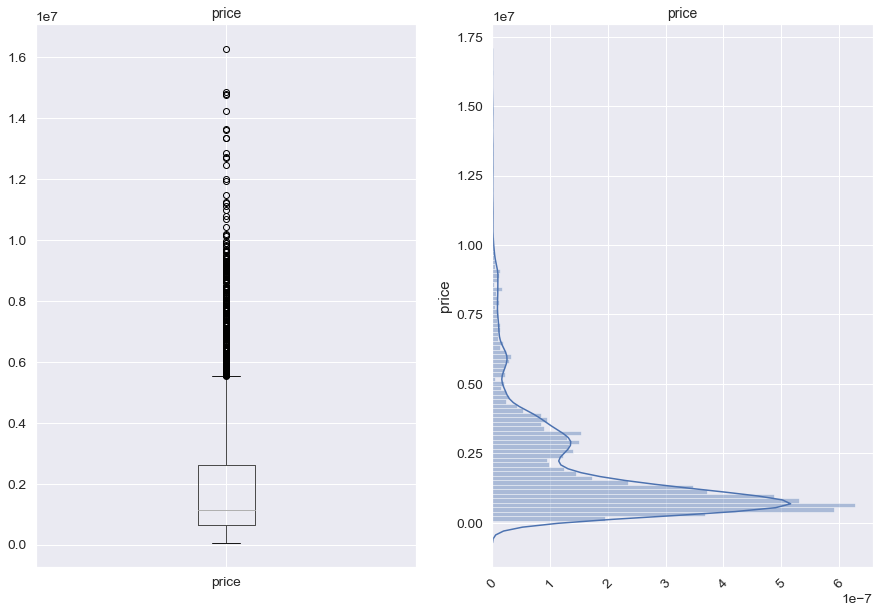

==== price ====
        count          mean           std      min       25%        50%  \
price  6985.0  1.854757e+06  1.843000e+06  60000.0  650000.0  1150000.0   

             75%         max  
price  2603800.0  16290000.0   

There are 0 missing values in 'price'. 




In [208]:
num_variable_analysis(data_bmw, target_name, target_name)

**Важно!** Порядок столбцов в `test` и `data_bmw` (за исключением целевого признака) должен совпадать!

In [209]:
test = test[ (data_bmw.drop([target_name], axis=1)).columns ]

In [210]:
data_bmw.to_csv(FILEPATH + "cars_train_bmw.csv")

# 9 Реализация предсказателя для конкретной задачи - предсказание цен на BMW (Estimator realization for BMW price prediction)

Поскольку предоставленные для предсказания данные имеют меньшее число признаков (как и, в общем-то, меньшее число имеющихся признаков) стоит обучить нашу модель на данных, соответствующих задаче - предсказать цены на автомобили BMW.

## 9.1 Создание обучающих и валидационных выборок

In [211]:
data_train_bmw, data_valid_bmw = train_test_split(data_bmw, test_size=0.25, random_state=RANDOM_STATE)

print("We have {} entities total.".format( len(data_bmw) ))
print("We took {} entities for train dataset and".format( len(data_train_bmw)))
print("        {} entities for valid dataset.\n".format( len(data_valid_bmw) ))

print("The target values in train are in range         [{}, {}] "
      .format( data_train_bmw[target_name].min(), data_train_bmw[target_name].max() ))
print("The target values in valid are in range         [{}, {}] "
      .format( data_valid_bmw[target_name].min(), data_valid_bmw[target_name].max() ))
print("The target values in whole dataset are in range [{}, {}] "
      .format( data_bmw[target_name].min(), data_bmw[target_name].max() ))

We have 6985 entities total.
We took 5238 entities for train dataset and
        1747 entities for valid dataset.

The target values in train are in range         [60000, 16290000] 
The target values in valid are in range         [90000, 13350700] 
The target values in whole dataset are in range [60000, 16290000] 


## 9.2 Оптимизация 'BMW'-предсказателя

In [212]:
EstimatorClass = 'lgbm'



### fixed parameters

param_dict_fix = {}

param_dict_fix['objective'] = OBJECTIVE
# param_dict_fix['boosting_type'] = 'gbdt'
param_dict_fix['random_state'] = RANDOM_STATE
# param_dict_fix['silent'] = False
param_dict_fix['free_raw_data'] = False

param_dict_fix['n_estimators'] = 606
param_dict_fix['learning_rate'] = 0.1128
# param_dict_fix['num_leaves'] = 26
# param_dict_fix['min_data_in_leaf'] = 21
param_dict_fix['max_depth'] = 3
# param_dict_fix['max_depth'] = -1, ## no limit
### limit the max depth for tree model. This is used to deal with over-fitting when #data is small. Tree still grows leaf-wise
### <= 0 means no limit



### variable parameters

params_lim = {}

params_lim['n_estimators'] = [502, 702, 'int']
params_lim['learning_rate'] = [0.100, 0.2, 'float']
params_lim['max_depth'] = [2, 42, 'int']
# params_lim['num_leaves'] = [2, 127, 'int']
# params_lim['min_data_in_leaf'] = [2, 1002, 'int']

[0]
params_limits : {'n_estimators': [502, 702, 'int'], 'learning_rate': [0.1, 0.2, 'float'], 'max_depth': [2, 42, 'int']}


C:\Users\DNS\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


OUT [0]: M(i) = 1000000000.000000; M(i+1) = 11.621218 (tol=0.0001)
result_dict {'n_estimators': 602, 'learning_rate': 0.1, 'max_depth': 4}
Iteration time = 43.31 sec

 ~ ~ ~ ~ ~ ~ ~ ~ ~  

[1]
params_limits : {'n_estimators': [592, 612, 'int'], 'learning_rate': [0.1, 0.10500000000000001, 'float'], 'max_depth': [2, 6, 'int']}
OUT [1]: M(i) = 11.621218; M(i+1) = 11.250455 (tol=0.0001)
result_dict {'n_estimators': 602, 'learning_rate': 0.10300000000000001, 'max_depth': 3}
Iteration time = 26.92 sec

 ~ ~ ~ ~ ~ ~ ~ ~ ~  

[2]
params_limits : {'n_estimators': [601, 603, 'int'], 'learning_rate': [0.10275000000000001, 0.10325000000000001, 'float'], 'max_depth': [2, 4, 'int']}
OUT [2]: M(i) = 11.250455; M(i+1) = 11.245862 (tol=0.0001)
result_dict {'n_estimators': 602, 'learning_rate': 0.1028, 'max_depth': 3}
Iteration time = 15.72 sec

 ~ ~ ~ ~ ~ ~ ~ ~ ~  

[3]
params_limits : {'n_estimators': [601, 603, 'int'], 'learning_rate': [0.102775, 0.102825, 'float'], 'max_depth': [2, 4, 'int']}
OUT [3

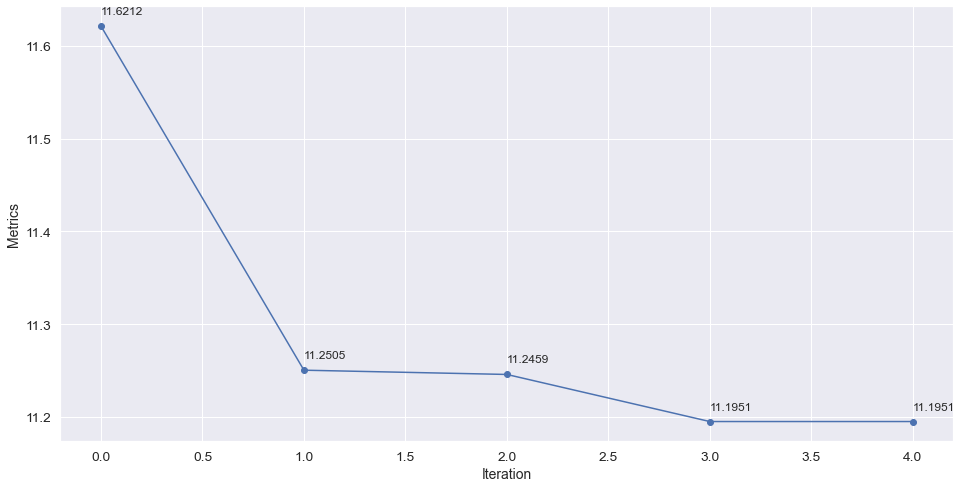


Done. Congratulations!
[***] This is Houston. The MET is : 0:29:51.742    (H:MM:SS)
==== ==== ==== ==== ==== 
The parameters of the best base BMW-model are:  {'n_estimators': 602, 'learning_rate': 0.10281124999999999, 'max_depth': 3}
The best base BMW-model has MAPE=11.1951
Wall time: 2min


In [213]:
%%time

result = model_coord_search(EstimatorClass, param_dict_fix, params_lim, 
                            data_train_bmw, data_valid_bmw, target_name, N_SAMPLE_BASE, 
                            num_points=21,
                            metrics_func=mean_absolute_percent_error, tol=0.0001, iter_lim=100, 
                            lgb_categorical_feature_list=CATEGORICAL_FEATURE_LIST_LGBM,  ## lgb_categorical_feature_list='auto',
                            verbose_cycle=True, verbose_detail=False, 
                            visualize_cycle=True, visualize_detail=False)

result_dict, metrics_out = result

running_time(time.time(), total_time_start)

print("==== "*5)
print("The parameters of the best base BMW-model are: ", result_dict)
print("The best base BMW-model has MAPE={:.4f}".format(metrics_out))

In [214]:
best_base_bmw_model_mape = metrics_out
best_base_bmw_parameters = result_dict
print("The best parameters for the base model are: ", best_base_bmw_parameters)
print("We have the MAPE = {:.4f} for the best base model. ".format(best_base_bmw_model_mape))

The best parameters for the base model are:  {'n_estimators': 602, 'learning_rate': 0.10281124999999999, 'max_depth': 3}
We have the MAPE = 11.1951 for the best base model. 


## 9.3 Создание набора базовых моделей для мета-стадии

In [215]:
N_grid = 11

In [216]:
EstimatorClass = 'lgbm'



### fixed parameters

param_dict_fix = {}

param_dict_fix['objective'] = OBJECTIVE
# param_dict_fix['boosting_type'] = 'gbdt'
param_dict_fix['random_state'] = RANDOM_STATE
# param_dict_fix['silent'] = False
param_dict_fix['free_raw_data'] = False

param_dict_fix['n_estimators'] = 639
param_dict_fix['learning_rate'] = best_base_bmw_parameters['learning_rate']  ## 0.012
# param_dict_fix['num_leaves'] = 26
# param_dict_fix['min_data_in_leaf'] = 21
param_dict_fix['max_depth'] = 6


# param_dict_fix['max_depth'] = -1, ## no limit
# param_dict_fix['n_estimators'] = 100
# param_dict_fix['learning_rate'] = 0.01



### best optimised parameters

n_es_0 = best_base_bmw_parameters['n_estimators']
md_0 = best_base_bmw_parameters['max_depth']
# lr_0 = np.round(best_parameters['learning_rate'], 9)
# n_l_0 = best_parameters['num_leaves']
# mdil_0 = best_parameters['min_data_in_leaf']

params_optim = {}

params_optim['n_estimators'] = np.linspace( max( [2, n_es_0-STEP_INT*(N_grid-1)/2] ),
                                           max( [2, n_es_0-STEP_INT*(N_grid-1)/2] ) + STEP_INT*(N_grid-1), 
                                           num=N_grid, dtype='int' )
params_optim['max_depth'] = np.linspace( max( [2, md_0-STEP_INT*(N_grid-1)/2] ), 
                                        max( [2, md_0-STEP_INT*(N_grid-1)/2] ) + STEP_INT*(N_grid-1),
                                        num = N_grid, dtype='int'  )



# params_optim['n_estimators'] = [max([2, n_es_0-200*STEP_INT]), n_es_0-100*STEP_INT,
#                                 n_es_0, n_es_0+100*STEP_INT, n_es_0+200*STEP_INT ]
# params_optim['max_depth'] = [ max([2, md_0-STEP_INT]), md_0, md_0+STEP_INT, md_0+2*STEP_INT, md_0+3*STEP_INT ]

# params_optim['n_estimators'] = [max([2, n_es_0-100*STEP_INT]), n_es_0, n_es_0+100*STEP_INT ]
# params_optim['max_depth'] = [ max([2, md_0-STEP_INT]), md_0, md_0+STEP_INT ]

# params_optim['num_leaves'] = [max([2, n_l_0-STEP_INT]), n_l_0, n_l_0+STEP_INT ]
# params_optim['min_data_in_leaf'] = [max([2, mdil_0-STEP_INT]), mdil_0, mdil_0+STEP_INT ]
# params_optim['learning_rate'] = [ max(0.0001, np.round(lr_0-STEP_LR, 9)), lr_0, np.round(lr_0+STEP_LR, 9) ]

# params_optim = {}
# params_optim['n_estimators'] = [1482, 1483, 1484] ##2264
# params_optim['max_depth'] = [10, 11, 12] ## 12
# params_optim['learning_rate'] = [0.067, 0.068, 0.069] ## 0.099

params_optim

{'n_estimators': array([597, 598, 599, 600, 601, 602, 603, 604, 605, 606, 607]),
 'max_depth': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12])}

In [217]:
%%time
base_bmw_model_storage =  model_collector(EstimatorClass, param_dict_fix, params_optim, 
                          data_train_bmw, data_valid_bmw, target_name, N_SAMPLE_BASE, 
                          metrics_func=mean_absolute_percent_error,
                          lgb_categorical_feature_list=CATEGORICAL_FEATURE_LIST_LGBM)  ## lgb_categorical_feature_list='auto',)

running_time(time.time(), total_time_start)

['n_estimators', 'max_depth', 'metrics', 'performance_time', 'model']


C:\Users\DNS\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[597, 2, 11.669044023625244, 0.5010366439819336, <lightgbm.basic.Booster object at 0x000001E7800AE988>]
[597, 3, 11.200473651830556, 0.6280481815338135, <lightgbm.basic.Booster object at 0x000001E7801C15C8>]
[597, 4, 11.604110658859623, 0.7870926856994629, <lightgbm.basic.Booster object at 0x000001E78030C748>]
[597, 5, 11.792012227011758, 1.0440778732299805, <lightgbm.basic.Booster object at 0x000001E7802222C8>]
[597, 6, 11.909504444417102, 1.281095266342163, <lightgbm.basic.Booster object at 0x000001E78008EA08>]
[597, 7, 11.68071673214228, 1.254117488861084, <lightgbm.basic.Booster object at 0x000001E780C18448>]
[597, 8, 11.636380569084814, 1.5151467323303223, <lightgbm.basic.Booster object at 0x000001E780C93888>]
[597, 9, 11.768261588740298, 1.3491017818450928, <lightgbm.basic.Booster object at 0x000001E7F340BAC8>]
[597, 10, 11.785858057699665, 1.3906328678131104, <lightgbm.basic.Booster object at 0x000001E780855788>]
[597, 11, 11.742487043026022, 1.4141123294830322, <lightgbm.basic.

In [218]:
# base_bmw_model_storage = base_bmw_model_storage[ -base_bmw_model_storage['metrics'].duplicated() ]
base_bmw_model_storage.reset_index(inplace=True)
base_bmw_model_storage = base_bmw_model_storage.drop(['index'], axis=1)
base_bmw_model_storage

n_estimators max_depth    metrics  performance_time  \
0            606         3  11.185870          0.514614   
1            607         3  11.186270          0.510039   
2            605         3  11.187532          0.506038   
3            604         3  11.193909          0.490036   
4            601         3  11.194755          0.609045   
..           ...       ...        ...               ...   
116          602         6  11.914782          0.871502   
117          607         6  11.915829          0.849062   
118          606         6  11.915970          0.837157   
119          604         6  11.916621          0.990979   
120          603         6  11.917916          0.842063   

                                                 model  
0    <lightgbm.basic.Booster object at 0x000001E787...  
1    <lightgbm.basic.Booster object at 0x000001E787...  
2    <lightgbm.basic.Booster object at 0x000001E787...  
3    <lightgbm.basic.Booster object at 0x000001E787...  
4    <lightgbm.basic.Booster object at 0x000001E780...  
..                                                 ...  
116  <lightgbm.basic.Booster object at 0x000001E787...  
117  <lightgbm.basic.Booster object at 0x000001E788...  
118  <lightgbm.basic.Booster object at 0x000001E787...  
119  <lightgbm.basic.Booster object at 0x000001E787...  
120  <lightgbm.basic.Booster object at 0x000001E787...  

[121 rows x 5 columns]

## 9.4 About the best 'BMW' base model. Feature importance.

In [219]:
best_base_bmw_model = base_bmw_model_storage.loc[0, "model"]
print("Best base 'BMW' model demonstrates MAPE = {:.4f} with valid sample."
      .format(base_bmw_model_storage.loc[0, "metrics"]))

Best base 'BMW' model demonstrates MAPE = 11.1859 with valid sample.


In [220]:
feat_importances_best_base_bmw_model = pd.DataFrame(
    data=100*best_base_bmw_model.feature_importance()/best_base_bmw_model.feature_importance().sum(), 
    index=data_train_bmw.drop([target_name], axis=1).columns, columns=['Importance_(%)'])

feat_importances_best_base_bmw_model = feat_importances_best_base_bmw_model.sort_values(by='Importance_(%)', 
                                                                                        ascending=False)
feat_importances_best_base_bmw_model.head(20)

Importance_(%)
year                    21.720196
mileage                 17.719107
power                   12.874251
displacement             9.961894
model                    6.886228
color                    4.627109
body_type                2.395210
gear_type                1.932499
doors_count              1.878062
transmission             1.497006
abs                      1.360915
cruise-control           1.306478
owners                   1.197605
engine_type              1.143168
navigation               0.870985
air-suspension           0.870985
climate-control-1        0.734894
rear-camera              0.707676
asr                      0.680457
night-vision             0.626021

In [221]:
z = feat_importances_best_base_bmw_model[(feat_importances_best_base_bmw_model['Importance_(%)'] != 0) & 
                                         (feat_importances_best_base_bmw_model['Importance_(%)'].notna())].values.flatten()
y = np.log(z)
x = np.arange(0, len(y))

p = np.polyfit(x, y, 1)
length = float(-1/p[0])
feature_deficiency = 1/( np.exp(len(y)/length) - 1  )

print("The 'exponential decay length' is {:.2f} 'features'.".format( length ))
print("A lack od features is about {:.1%}.".format(float(feature_deficiency)))
print("\n If you see 'nan', it means that at least one of feature has a zero-importance.")

real_importance = np.exp( np.polyval(p, x) )

The 'exponential decay length' is 10.11 'features'.
A lack od features is about 1.2%.

 If you see 'nan', it means that at least one of feature has a zero-importance.


In [222]:
feature_deficient = 0.01
print("We need {} instead of {} now for feature sufficiency of {:.1%}, while now we have {:.1%}."
      .format( int(np.ceil( -length*np.log(feature_deficiency) )), len(x), 
              1-feature_deficient, 1-feature_deficiency ))

We need 45 instead of 45 now for feature sufficiency of 99.0%, while now we have 98.8%.


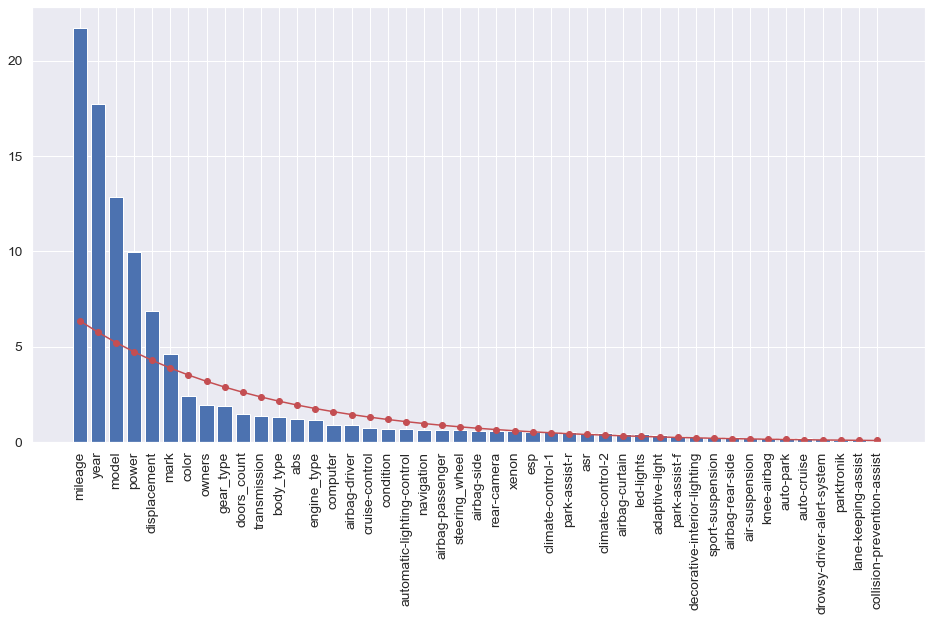

In [223]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))

plt.bar(x, z)
plt.plot(x, real_importance, '-ro')
plt.xticks(x, features_importances_best_base_model.index, rotation=90)

plt.show()

The range of prediction for Model No. 0 are: [110693.0, 12206864.0] with the width of 12096171.0
The range of prediction for Model No. 1 are: [110697.0, 12207314.0] with the width of 12096617.0
The range of prediction for Model No. 2 are: [110659.0, 12207202.0] with the width of 12096543.0


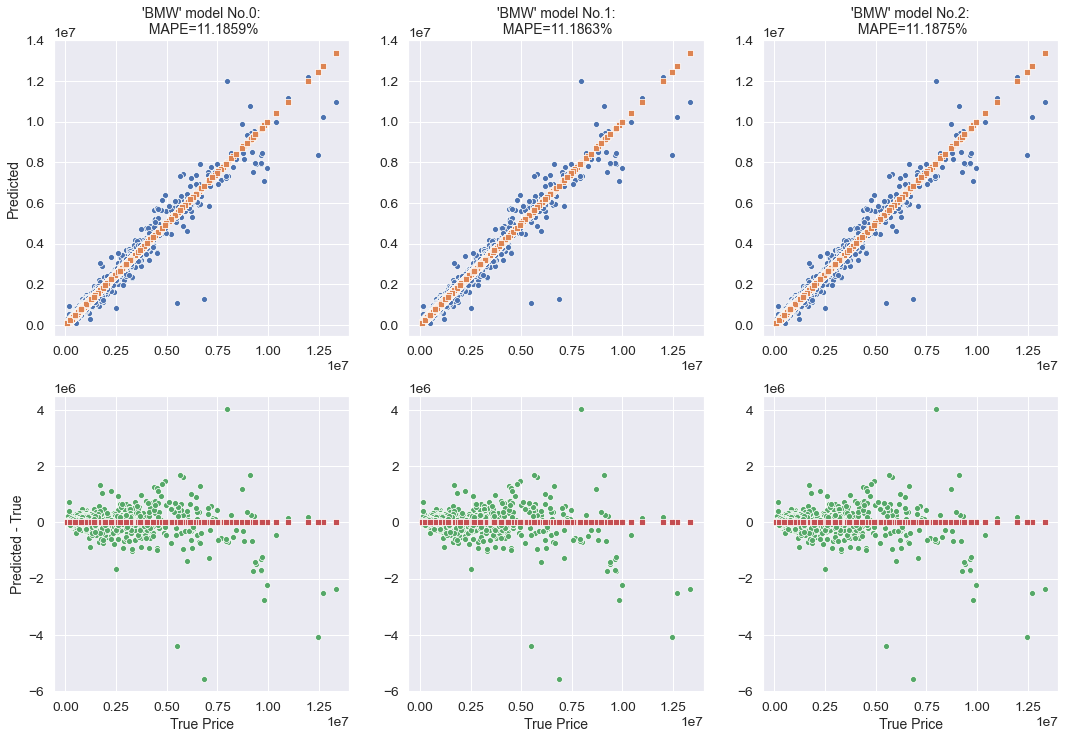

In [224]:
df = base_bmw_model_storage


n = min(3, len(df))

fig, axes = plt.subplots(2, n, figsize=(6*n, 12) )

for i in range(n):
    model = df.loc[i, "model"]
#     prediction = model.predict(data_valid1.drop([target_name], axis=1))
#     prediction_log10 = model.predict(data_valid_bmw.drop([target_name], axis=1))
#     prediction = 10**prediction_log10
    prediction_transformed = model.predict(data_valid_bmw.drop([target_name], axis=1))
    prediction = np.round(target_transform_inv(prediction_transformed, POWER)).astype(int)
    
    print("The range of prediction for Model No. {} are: [{:.1f}, {:.1f}] with the width of {:.1f}"
          .format( i, prediction.min(), prediction.max(), prediction.max()-prediction.min() ))
    
    plt.subplot(2, n, i+1)
    sns.scatterplot(data_valid_bmw[target_name], prediction)
    sns.scatterplot(data_valid_bmw[target_name], data_valid_bmw[target_name], marker='s')
    plt.title("'BMW' model No.{}:\n MAPE={:.4f}%".format(i, df.loc[i, "metrics"]), fontsize=FONT_SIZE)
    plt.xlabel("", fontsize=FONT_SIZE)
    if i == 0:
        plt.ylabel("Predicted", fontsize=FONT_SIZE)
    else:
        plt.ylabel("", fontsize=FONT_SIZE)
        
    plt.subplot(2, n, n+i+1)
    sns.scatterplot(data_valid_bmw[target_name], prediction - data_valid_bmw[target_name], color='g')
    sns.scatterplot(data_valid_bmw[target_name], data_valid_bmw[target_name] - data_valid_bmw[target_name], 
                    marker='s', color='r')
    plt.xlabel("True Price", fontsize=FONT_SIZE)
    if i == 0:
        plt.ylabel("Predicted - True", fontsize=FONT_SIZE)
    else:
        plt.ylabel("", fontsize=FONT_SIZE)

## 9.5 Мета-фаза. Бэггинг.

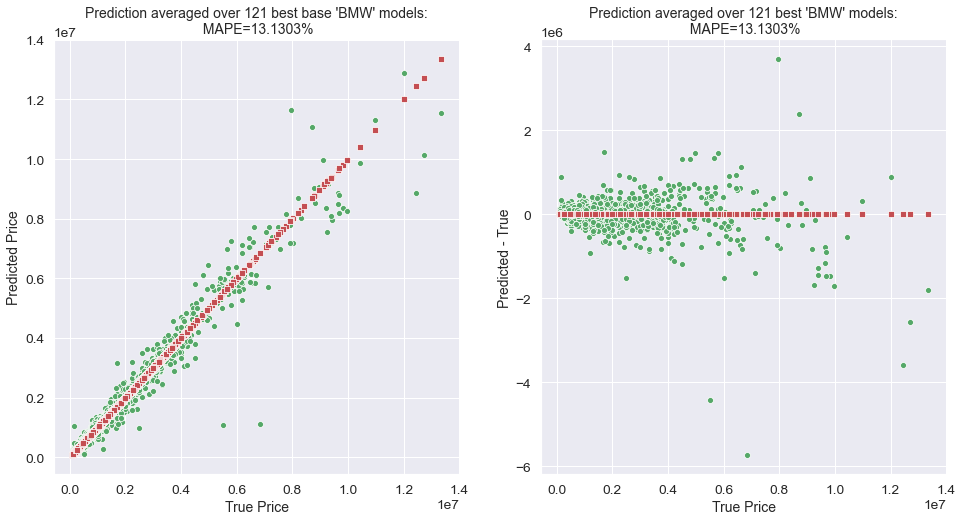

In [225]:
df = base_bmw_model_storage

fig, axes = plt.subplots(1, 2, figsize=(16, 8))


### ALL

n_models = len(df)

predictions = []
for model in df.loc[:n_models-1, "model"]:
#     prediction = model.predict(data_valid1.drop([target_name], axis=1))
#     prediction_log10 = model.predict(data_valid1.drop([target_name], axis=1))
#     prediction = 10**prediction_log10
    prediction_transformed = model.predict(data_valid_bmw.drop([target_name], axis=1))
    prediction = np.round(target_transform_inv(prediction_transformed, POWER)).astype(int)
    
    predictions.append(prediction)
    
predictions = np.array(predictions)
mean_bmw_prediction_all = predictions.mean(axis=0)
mape_of_mean_bmw_all = mean_absolute_percent_error(data_valid_bmw[target_name], mean_bmw_prediction_all)


plt.subplot(1, 2, 1)
sns.scatterplot(data_valid_bmw[target_name], mean_bmw_prediction_all, marker='o', color='g')
sns.scatterplot(data_valid_bmw[target_name], data_valid_bmw[target_name], marker='s', color='r')
plt.title("Prediction averaged over {} best base 'BMW' models:\n MAPE={:.4f}%"
          .format(n_models, mape_of_mean_all), fontsize=FONT_SIZE)
plt.xlabel("True Price", fontsize=FONT_SIZE)
plt.ylabel("Predicted Price", fontsize=FONT_SIZE)


plt.subplot(1, 2, 2)
sns.scatterplot(data_valid_bmw[target_name], mean_bmw_prediction_all - data_valid_bmw[target_name], 
                marker='o', color='g')
sns.scatterplot(data_valid_bmw[target_name], data_valid_bmw[target_name] - data_valid_bmw[target_name], 
                marker='s', color='r')

plt.title("Prediction averaged over {} best 'BMW' models:\n MAPE={:.4f}%"
          .format(n_models, mape_of_mean_all), fontsize=FONT_SIZE)
plt.xlabel("True Price", fontsize=FONT_SIZE)
plt.ylabel("Predicted - True", fontsize=FONT_SIZE)

plt.show()

In [226]:
test.columns

Index(['body_type', 'doors_count', 'model', 'engine_type', 'displacement',
       'power', 'transmission', 'gear_type', 'color', 'mileage', 'year',
       'owners', 'abs', 'activ-suspension', 'air-suspension', 'asr',
       'collision-prevention-assist', 'esp', 'lane-keeping-assist',
       'park-assist-f', 'park-assist-r', 'sport-suspension', 'vsm',
       'climate-control', 'climate-control-1', 'condition',
       'multizone-climate-control', 'auto-cruise', 'auto-park', 'computer',
       'cruise-control', 'drowsy-driver-alert-system', 'front-camera',
       'navigation', 'night-vision', 'projection-display', 'rear-camera',
       'adaptive-light', 'advanced-frontlighting-system',
       'decorative-interior-lighting', 'laser-lights', 'led-lights', 'xenon',
       'airbag-curtain', 'airbag-driver', 'airbag-passenger',
       'airbag-rear-side', 'airbag-side', 'knee-airbag'],
      dtype='object')

In [227]:
data_valid_bmw.drop([target_name], axis=1).columns

Index(['body_type', 'doors_count', 'model', 'engine_type', 'displacement',
       'power', 'transmission', 'gear_type', 'color', 'mileage', 'year',
       'owners', 'abs', 'activ-suspension', 'air-suspension', 'asr',
       'collision-prevention-assist', 'esp', 'lane-keeping-assist',
       'park-assist-f', 'park-assist-r', 'sport-suspension', 'vsm',
       'climate-control', 'climate-control-1', 'condition',
       'multizone-climate-control', 'auto-cruise', 'auto-park', 'computer',
       'cruise-control', 'drowsy-driver-alert-system', 'front-camera',
       'navigation', 'night-vision', 'projection-display', 'rear-camera',
       'adaptive-light', 'advanced-frontlighting-system',
       'decorative-interior-lighting', 'laser-lights', 'led-lights', 'xenon',
       'airbag-curtain', 'airbag-driver', 'airbag-passenger',
       'airbag-rear-side', 'airbag-side', 'knee-airbag'],
      dtype='object')

In [228]:
new_test = test[data_valid_bmw.drop([target_name], axis=1).columns]

new_test

body_type  doors_count    model engine_type  displacement  power  \
0        SEDAN            4  5 серия      DIESEL          2000    190   
1        SEDAN            4  3 серия      DIESEL          2000    150   
2        SEDAN            4  5 серия    GASOLINE          4400    407   
3      ALLROAD            5       X5      DIESEL          3000    249   
4      ALLROAD            5     X5 M      DIESEL          3000    381   
...        ...          ...      ...         ...           ...    ...   
3832     SEDAN            4  5 серия    GASOLINE          2000    184   
3833   ALLROAD            5       X5      DIESEL          3000    249   
3834     SEDAN            4  5 серия    GASOLINE          2500    218   
3835     SEDAN            4  5 серия    GASOLINE          2000    245   
3836   ALLROAD            5       X3    GASOLINE          4400    407   

     transmission        gear_type             color  mileage  ...  \
0       AUTOMATIC       REAR_DRIVE             black   158836  ...   
1       AUTOMATIC       REAR_DRIVE             white       10  ...   
2       AUTOMATIC  ALL_WHEEL_DRIVE       strong-blue   120000  ...   
3       AUTOMATIC  ALL_WHEEL_DRIVE             white   111466  ...   
4       AUTOMATIC  ALL_WHEEL_DRIVE       strong-blue    11891  ...   
...           ...              ...               ...      ...  ...   
3832    AUTOMATIC       REAR_DRIVE             black    98000  ...   
3833    AUTOMATIC  ALL_WHEEL_DRIVE             black   169615  ...   
3834    AUTOMATIC  ALL_WHEEL_DRIVE             black   180000  ...   
3835    AUTOMATIC  ALL_WHEEL_DRIVE  mostly-black-red   137500  ...   
3836    AUTOMATIC  ALL_WHEEL_DRIVE             black    89905  ...   

      decorative-interior-lighting  laser-lights led-lights xenon  \
0                              0.0           0.0        1.0   0.0   
1                              1.0           0.0        1.0   0.0   
2                              0.0           0.0        0.0   0.0   
3                              0.0           0.0        0.0   1.0   
4                              0.0           0.0        1.0   0.0   
...                            ...           ...        ...   ...   
3832                           0.0           0.0        1.0   0.0   
3833                           0.0           0.0        1.0   1.0   
3834                           0.0           0.0        0.0   0.0   
3835                           0.0           0.0        0.0   1.0   
3836                           0.0           0.0        0.0   1.0   

     airbag-curtain airbag-driver airbag-passenger airbag-rear-side  \
0               1.0           1.0              1.0              1.0   
1               1.0           1.0              1.0              0.0   
2               1.0           1.0              1.0              0.0   
3               1.0           1.0              1.0              0.0   
4               0.0           0.0              0.0              0.0   
...             ...           ...              ...              ...   
3832            0.0           0.0              0.0              0.0   
3833            1.0           1.0              1.0              0.0   
3834            0.0           1.0              1.0              1.0   
3835            1.0           1.0              1.0              0.0   
3836            0.0           1.0              1.0              0.0   

     airbag-side knee-airbag  
0            1.0         1.0  
1            1.0         0.0  
2            1.0         0.0  
3            1.0         0.0  
4            0.0         0.0  
...          ...         ...  
3832         0.0         0.0  
3833         1.0         0.0  
3834         1.0         1.0  
3835         1.0         0.0  
3836         1.0         0.0  

[3837 rows x 49 columns]

## Blending (LinearRegression)

In [229]:
%%time



target_meta_bmw_linear_valid = target_transform(data_valid_bmw[target_name], POWER)

features_meta_bmw_linear_valid = pd.DataFrame()
for k in range(0, predictions.shape[0]):
    features_meta_bmw_linear_valid[k] = target_transform(predictions[k, :], POWER)

model_meta_blending = LinearRegression()
model_meta_blending.fit(features_meta_bmw_linear_valid, target_meta_bmw_linear_valid)

prediction_transformed = model_meta_blending.predict(features_meta_bmw_linear_valid)
prediction_blend_transformed =  np.round(target_transform_inv(prediction_transformed, POWER)).astype(int)

mape_bmw_blend_transform = mean_absolute_percent_error(data_valid_bmw[target_name], prediction_blend_transformed)

print("With the simplest blending procedure with transformation of target we got MAPE = {:.4f}"
      .format(mape_bmw_blend_transform))

running_time(time.time(), total_time_start)

With the simplest blending procedure with transformation of target we got MAPE = 10.9416
[***] This is Houston. The MET is : 0:32:11.816    (H:MM:SS)
Wall time: 385 ms


## 9.6 Итоговое предсказание

В случае с BMW лучшим оказался блендинг.

In [230]:
%%time

df = base_bmw_model_storage

### ALL
n_models = len(df)

predictions = []
for model in df.loc[:n_models-1, "model"]:
#     prediction = model.predict(data_valid1.drop([target_name], axis=1))
#     prediction_log10 = model.predict(data_valid1.drop([target_name], axis=1))
#     prediction = 10**prediction_log10
    prediction_transformed = model.predict(test)
    prediction = np.round(target_transform_inv(prediction_transformed, POWER)).astype(int)
    
    predictions.append(prediction)
    
predictions = np.array(predictions)




features_final = pd.DataFrame()
for k in range(0, predictions.shape[0]):
    features_final[k] = target_transform(predictions[k, :], POWER)

prediction_transformed = model_meta_blending.predict(features_meta_bmw_linear_valid)
prediction_blend_transformed =  np.round(target_transform_inv(prediction_transformed, POWER)).astype(int)

running_time(time.time(), total_time_start)

[***] This is Houston. The MET is : 0:32:32.918    (H:MM:SS)
Wall time: 21.1 s


In [231]:
our_prediction = prediction_blend_transformed

# print(prediction_transformed.min(), prediction_transformed.mean(), prediction_transformed.max())
print("Our predictions:")
print("Min =     " , our_prediction.min())
print("Mean =   ", int(our_prediction.mean()))
print("Median = ", int(np.median(our_prediction)))
print("Max =   ", int(our_prediction.max()))

Our predictions:
Min =      114911
Mean =    1823106
Median =  1145868
Max =    13961726


In [232]:
# Однако в случае с BMW бэггинг не сработал. Поэтому возьмём предсказание лучшей модели.

# prediction_transformed = best_base_bmw_model.predict(test)
# our_prediction = np.round(target_transform_inv(prediction_transformed, POWER)).astype(int)

# # print(prediction_transformed.min(), prediction_transformed.mean(), prediction_transformed.max())
# print("Our predictions:")
# print("Min =     " , our_prediction.min())
# print("Mean =   ", int(our_prediction.mean()))
# print("Median = ", int(np.median(our_prediction)))
# print("Max =   ", int(our_prediction.max()))

In [233]:
sample_submission = pd.read_csv(FILEPATH + "sample_submission.csv")
sample_submission

id      price
0        0  5299000.0
1        1  1580000.0
2        2  2000000.0
3        3  2199000.0
4        4   935000.0
...    ...        ...
3832  3832   969000.0
3833  3833  1750000.0
3834  3834  1100000.0
3835  3835  2939000.0
3836  3836  1510000.0

[3837 rows x 2 columns]

In [234]:
our_prediction_df = pd.DataFrame([our_prediction]).T
our_prediction_df = our_prediction_df.reset_index()
our_prediction_df.columns=["id", target_name]
our_prediction_df

id    price
0        0   288617
1        1  1160596
2        2  2504044
3        3  2284765
4        4   865407
...    ...      ...
1742  1742  4846928
1743  1743  1448235
1744  1744  1463379
1745  1745  8232342
1746  1746   485858

[1747 rows x 2 columns]

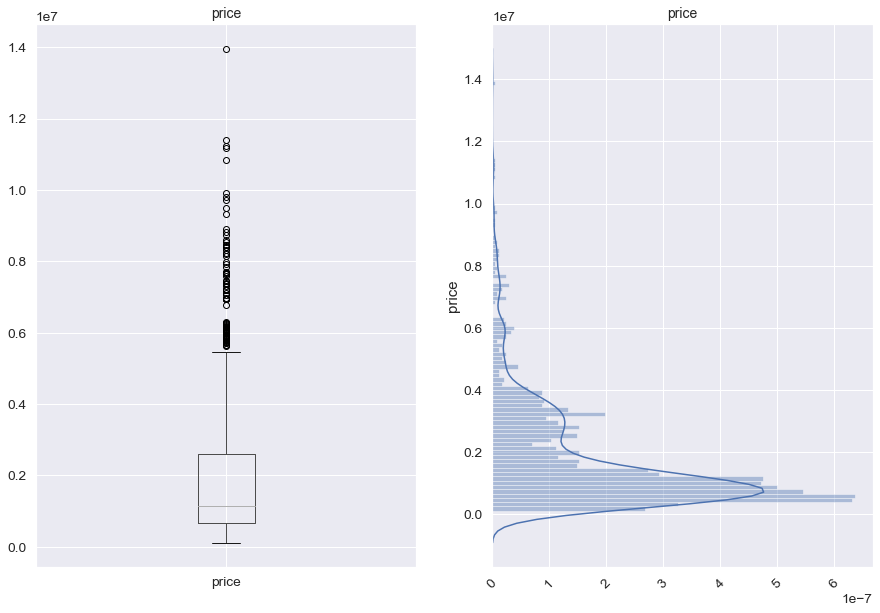

==== price ====
        count          mean           std       min       25%        50%  \
price  1747.0  1.823107e+06  1.747946e+06  114911.0  656413.5  1145868.0   

             75%         max  
price  2603368.0  13961726.0   

There are 0 missing values in 'price'. 




In [235]:
num_variable_analysis(our_prediction_df, target_name, target_name)

In [236]:
our_prediction_df.to_csv(FILEPATH + "our_prediction.csv")
running_time(time.time(), total_time_start)

[***] This is Houston. The MET is : 0:32:34.401    (H:MM:SS)


<div class="alert alert-block alert-info">
<div style="border:solid blue 2px; padding: 20px"> <h1 style="color:blue; margin-bottom:20px">
99 Results</h1>

</div>

In [237]:
best_base_bmw_model = base_bmw_model_storage.loc[0, "model"]
print("Best base 'BMW' model demonstrates                                    MAPE = {:.4f} with valid sample."
      .format(base_bmw_model_storage.loc[0, "metrics"]))
print("Blending with LinearRegression over {} base 'BMW' models demonstrates MAPE = {:.4f} with valid sample."
      .format(predictions.shape[0], mape_bmw_blend_transform))

Best base 'BMW' model demonstrates                                    MAPE = 11.1859 with valid sample.
Blending with LinearRegression over 121 base 'BMW' models demonstrates MAPE = 10.9416 with valid sample.


In [238]:
def two_digit_presentation(x):
    if x < 10:
        return "0" + str(x)
    else:
        return str(x)
    

    
def two_digit_time_presentation(x):
    hours = x//3600
    minutes = ( x - 3600*hours) // 60
    seconds = x - 3600*hours - 60*minutes
    if hours > 0:
        ans = (two_digit_presentation(int(hours)) +  " h " 
               + two_digit_presentation(int(minutes)) + " min " 
               + two_digit_presentation(int(seconds)) + " sec")
    elif minutes > 0:
        ans = (two_digit_presentation(int(minutes)) + " min " 
               + two_digit_presentation(int(seconds)) + " sec")
    else:
        ans = (two_digit_presentation(round(seconds, 3)) + " sec")
    return ans

In [239]:
time_string_launch = date_start.strftime("%d %B %Y") + " at " + time_start.strftime("%H:%M")

date_finish = datetime.date.today()
time_finish = datetime.datetime.now().time()
time_string_finish = date_finish.strftime("%d %B %Y") + " at " + time_finish.strftime("%H:%M")


print( "The code was launched on              ", time_string_launch )
print( "The code finished its performance on  ", time_string_finish )
print()
print( "The full performance time is " + two_digit_time_presentation( performance_time ) )

The code was launched on               02 August 2020 at 12:59
The code finished its performance on   02 August 2020 at 13:32

The full performance time is 25 min 48 sec


## Appendix: Что ещё можно было бы сделать

1. Сделать `prediction` типа `int`.
2. Объединить `model` и `mark` в один признак для общего случая.
3. Рефакторинг кода: есть остатки от предыдущих исследований с "висящими хвостами".
4. Сделать класс `LGBMBaging`:
  - принимает на вход параметры;
  - имеет метод `fit` (input: features_train, target_train);
  - имеет метод `predict` (input: features);
  - имеет метод `optimize` (желательно);
  - имеет метод `feature_importance` (желательно).

### VERSIONS

**Ver. 12 :** `Target is $\log_{10}({\rm price})$ instead of ${\rm price}$`
  - MAPE is decreased from 14.6% to 13.4% (the distributions turned to be smoother)

**Ver. 13 :** `Full dataset with data for 2006-2009`
  - MAPE is increased from 13.4% to 13.63% (more data, more variance)
  
**Ver. 14 :** 
1. `Testing various OBJECTIVEs`:
  - 'mse' (aka regression') - default: 13.63% 
  - 'mape' - same result as the best one, but much more longer (3 hrs vs 1 hr): 13.63% 
  - 'mae' - close to the best result (same time - aboun 56 min): 13.68% 
    - **Result:** OBJECTIVE = 'mse'
2. Does the qualification of `'doors_count' and 'owners' in dtype='category'` helps LGBM to determine them as categorical feanures automatically and leads to gain?
  - **Result:** Negative. 13.66% vs old 13.63%. Let them hold the dtype='int'.
3.  If I `drop 'owners'`, will it hepl? The LGBM always says that the importance of 'owners' is zero.
  - **Result:** Negative.
4. Data are normalized:
   - Only numerical
     - **Result:** Negative: 13.68% vs 13.63%.
5. Increase the distance between models in hyperparameter-space: 
    - from 1 to 3 for 'int'
    - from 0.001 to 0.005 for 'learning rate'
      - **Result:** Negative: 13.65% vs 13.63%.
    - from 1 to 5 for 'int'
    - from 0.001 to 0.01 for 'learning rate'
      - **Result:** Neutral: 13.63% = 13.63%.
    - from 1 to 7 for 'int'
    - from 0.001 to 0.03 for 'learning rate'
      - **Result:** Negative: 13.85% vs 13.46%.
      
**Ver. 15 :** 
  - target transformation
    - POWER = 2
      - **Result:** Neutral: 13.63% = 13.63%.
    - POWER = 1.5 (${\rm mean}\simeq {\rm median}\simeq {\rm center}$)
      - **Result:** Neutral: 13.63% = 13.63%.